## Atabey's Notes

Looks good.

100/100

# Homework #3

## Eren Tümkaya  090190328
                                                        
                                                
                                                        
## Dataset
I used the [data warehouse](https://clerk.house.gov/Votes/) for the [US House of Representatives](https://www.house.gov/). 
                                                       

In [2]:
import xmltodict
import pandas as pd
import logging
from urllib.request import urlopen
from urllib.error import HTTPError
from pandas import json_normalize
import re

from nltk.corpus import stopwords

from scipy import signal
from numpy.fft import rfft

from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from rake_nltk import Rake


In [218]:
from urllib.request import urlopen                           
                                             
                                                              
with urlopen('https://clerk.house.gov/evs/2003/roll188.xml') as url:
    raw = xmltodict.parse(url.read())                        
                                                             
raw                                                          

{'rollcall-vote': {'vote-metadata': {'majority': 'R',
   'congress': '108',
   'session': '1st',
   'chamber': 'U.S. House of Representatives',
   'rollcall-num': '188',
   'legis-num': 'H R 1000',
   'vote-question': 'On Motion to Recommit with Instructions',
   'vote-type': 'YEA-AND-NAY',
   'vote-result': 'Failed',
   'action-date': '14-May-2003',
   'action-time': {'@time-etz': '16:12', '#text': '4:12 PM'},
   'vote-desc': 'Pension Security Act',
   'vote-totals': {'totals-by-party-header': {'party-header': 'Party',
     'yea-header': 'Yeas',
     'nay-header': 'Nays',
     'present-header': 'Answered “Present”',
     'not-voting-header': 'Not Voting'},
    'totals-by-party': [{'party': 'Republican',
      'yea-total': '4',
      'nay-total': '221',
      'present-total': '0',
      'not-voting-total': '3'},
     {'party': 'Democratic',
      'yea-total': '197',
      'nay-total': '5',
      'present-total': '0',
      'not-voting-total': '3'},
     {'party': 'Independent',
      '

I just used this in order to know more about my dataset.

## Q1

### Getting the Data

I started by taking one roll and turning it to dictionary. I analized it and tried to figure out ways to pull it all. Pulling the vote data for each legislator and then combining them seemed so hard at first.I couldn't reach the legislator data in a complete form due to the nature of the dataset. My initial ideas included: 

1) Pulling them all, each as a dictionary in a list, as each of them are list elements. Well this didnt work. After getting the data, it was so much harder to turn it into a dataframe.  

2) Only pulling the "vote data" and then storing each vote data of the rolls with dictionary keys: (the year, the roll number) in a huge dictionary consisting of all the rolls. I believe this was a better idea than the previous one. But it still had many flaws such as : not including other parts of the data which was required for the tasks and my own difficulties with storing it as a dataframe.

3) Finally, I wanted to ingest each one by one and just as I ingest, turn them into dataframes. Afterwards I combined the dataframes(again, one by one) and I got the results I wanted. I added all the neccessary columns for the tasks, so that I don't have to deal with pulling data once again.

*** To find the required columns, I read all the tasks carefully in advance.  

*** I knew that "legislator" part was going to require some seperating and I was ready to do deal with it after I have my dataframe pulled.

I started my trials by pulling only 10 rolls with an if condition. I wanted to see whether I was succesful in the merge. After some error handling, it worked as I wanted. Full data took about 3-4 hours to be pulled. It was clearly correlated with the strength of my internet connection.

I am adding my llm aid to the files (HW3-LLM-LOG.md). I asked many questions, till I got a working and succesfull code. Also it helped me with the error handling.


In [4]:
import xmltodict
import pandas as pd
import logging
from urllib.request import urlopen
from urllib.error import HTTPError

logging.basicConfig(level=logging.INFO)

def fetch_roll_data(year, roll_number):
    formatted_roll_number = f"{roll_number:03d}"  
    
    try:
            with urlopen(f'https://clerk.house.gov/evs/{year}/roll{formatted_roll_number}.xml') as url:
                raw_data = xmltodict.parse(url.read())
                df = pd.DataFrame(raw_data["rollcall-vote"]['vote-data']["recorded-vote"])
                df['Year'] = year
                df['RollNumber'] = roll_number
                df["Type"]=raw_data['rollcall-vote']["vote-metadata"]["vote-type"]
                df["Vote Result"]=raw_data['rollcall-vote']["vote-metadata"]["vote-result"]
                df["The Question"]=raw_data['rollcall-vote']["vote-metadata"]["vote-question"]
                df["Description"]=raw_data["rollcall-vote"]["vote-metadata"]["vote-desc"]
            return df

    except HTTPError as http_err:
            if http_err.code == 404:
                logging.warning(f"Data not found for Year: {year}, Roll: {roll_number}")
                return None
            else:
                logging.error(f"HTTPError for Year: {year}, Roll: {roll_number}: {http_err}")
                return None

    except Exception as e:
            logging.error(f"Error fetching data for Year: {year}, Roll: {roll_number}: {e}")
            return None

all_data = []

start_year = 1990
end_year = 2023

for year in range(start_year, end_year + 1):
    roll_number = 1

    while True:
        data = fetch_roll_data(year, roll_number)

        if data is not None and not data.empty:
            all_data.append(data)
            logging.info(f"Fetched data for Year: {year}, Roll: {roll_number:03d}")
            roll_number += 1
        else:
            logging.info(f"End of rolls for Year: {year}")
            break


if all_data:
    final_dataframe = pd.concat(all_data, ignore_index=True)

INFO:root:Fetched data for Year: 1990, Roll: 001
INFO:root:Fetched data for Year: 1990, Roll: 002
INFO:root:Fetched data for Year: 1990, Roll: 003
INFO:root:Fetched data for Year: 1990, Roll: 004
INFO:root:Fetched data for Year: 1990, Roll: 005
INFO:root:Fetched data for Year: 1990, Roll: 006
INFO:root:Fetched data for Year: 1990, Roll: 007
INFO:root:Fetched data for Year: 1990, Roll: 008
INFO:root:Fetched data for Year: 1990, Roll: 009
INFO:root:Fetched data for Year: 1990, Roll: 010
INFO:root:Fetched data for Year: 1990, Roll: 011
INFO:root:Fetched data for Year: 1990, Roll: 012
INFO:root:Fetched data for Year: 1990, Roll: 013
INFO:root:Fetched data for Year: 1990, Roll: 014
INFO:root:Fetched data for Year: 1990, Roll: 015
INFO:root:Fetched data for Year: 1990, Roll: 016
INFO:root:Fetched data for Year: 1990, Roll: 017
INFO:root:Fetched data for Year: 1990, Roll: 018
INFO:root:Fetched data for Year: 1990, Roll: 019
INFO:root:Fetched data for Year: 1990, Roll: 020
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1990, Roll: 169
INFO:root:Fetched data for Year: 1990, Roll: 170
INFO:root:Fetched data for Year: 1990, Roll: 171
INFO:root:Fetched data for Year: 1990, Roll: 172
INFO:root:Fetched data for Year: 1990, Roll: 173
INFO:root:Fetched data for Year: 1990, Roll: 174
INFO:root:Fetched data for Year: 1990, Roll: 175
INFO:root:Fetched data for Year: 1990, Roll: 176
INFO:root:Fetched data for Year: 1990, Roll: 177
INFO:root:Fetched data for Year: 1990, Roll: 178
INFO:root:Fetched data for Year: 1990, Roll: 179
INFO:root:Fetched data for Year: 1990, Roll: 180
INFO:root:Fetched data for Year: 1990, Roll: 181
INFO:root:Fetched data for Year: 1990, Roll: 182
INFO:root:Fetched data for Year: 1990, Roll: 183
INFO:root:Fetched data for Year: 1990, Roll: 184
INFO:root:Fetched data for Year: 1990, Roll: 185
INFO:root:Fetched data for Year: 1990, Roll: 186
INFO:root:Fetched data for Year: 1990, Roll: 187
INFO:root:Fetched data for Year: 1990, Roll: 188
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1990, Roll: 337
INFO:root:Fetched data for Year: 1990, Roll: 338
INFO:root:Fetched data for Year: 1990, Roll: 339
INFO:root:Fetched data for Year: 1990, Roll: 340
INFO:root:Fetched data for Year: 1990, Roll: 341
INFO:root:Fetched data for Year: 1990, Roll: 342
INFO:root:Fetched data for Year: 1990, Roll: 343
INFO:root:Fetched data for Year: 1990, Roll: 344
INFO:root:Fetched data for Year: 1990, Roll: 345
INFO:root:Fetched data for Year: 1990, Roll: 346
INFO:root:Fetched data for Year: 1990, Roll: 347
INFO:root:Fetched data for Year: 1990, Roll: 348
INFO:root:Fetched data for Year: 1990, Roll: 349
INFO:root:Fetched data for Year: 1990, Roll: 350
INFO:root:Fetched data for Year: 1990, Roll: 351
INFO:root:Fetched data for Year: 1990, Roll: 352
INFO:root:Fetched data for Year: 1990, Roll: 353
INFO:root:Fetched data for Year: 1990, Roll: 354
INFO:root:Fetched data for Year: 1990, Roll: 355
INFO:root:Fetched data for Year: 1990, Roll: 356
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1990, Roll: 505
INFO:root:Fetched data for Year: 1990, Roll: 506
INFO:root:Fetched data for Year: 1990, Roll: 507
INFO:root:Fetched data for Year: 1990, Roll: 508
INFO:root:Fetched data for Year: 1990, Roll: 509
INFO:root:Fetched data for Year: 1990, Roll: 510
INFO:root:Fetched data for Year: 1990, Roll: 511
INFO:root:Fetched data for Year: 1990, Roll: 512
INFO:root:Fetched data for Year: 1990, Roll: 513
INFO:root:Fetched data for Year: 1990, Roll: 514
INFO:root:Fetched data for Year: 1990, Roll: 515
INFO:root:Fetched data for Year: 1990, Roll: 516
INFO:root:Fetched data for Year: 1990, Roll: 517
INFO:root:Fetched data for Year: 1990, Roll: 518
INFO:root:Fetched data for Year: 1990, Roll: 519
INFO:root:Fetched data for Year: 1990, Roll: 520
INFO:root:Fetched data for Year: 1990, Roll: 521
INFO:root:Fetched data for Year: 1990, Roll: 522
INFO:root:Fetched data for Year: 1990, Roll: 523
INFO:root:Fetched data for Year: 1990, Roll: 524
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1991, Roll: 135
INFO:root:Fetched data for Year: 1991, Roll: 136
INFO:root:Fetched data for Year: 1991, Roll: 137
INFO:root:Fetched data for Year: 1991, Roll: 138
INFO:root:Fetched data for Year: 1991, Roll: 139
INFO:root:Fetched data for Year: 1991, Roll: 140
INFO:root:Fetched data for Year: 1991, Roll: 141
INFO:root:Fetched data for Year: 1991, Roll: 142
INFO:root:Fetched data for Year: 1991, Roll: 143
INFO:root:Fetched data for Year: 1991, Roll: 144
INFO:root:Fetched data for Year: 1991, Roll: 145
INFO:root:Fetched data for Year: 1991, Roll: 146
INFO:root:Fetched data for Year: 1991, Roll: 147
INFO:root:Fetched data for Year: 1991, Roll: 148
INFO:root:Fetched data for Year: 1991, Roll: 149
INFO:root:Fetched data for Year: 1991, Roll: 150
INFO:root:Fetched data for Year: 1991, Roll: 151
INFO:root:Fetched data for Year: 1991, Roll: 152
INFO:root:Fetched data for Year: 1991, Roll: 153
INFO:root:Fetched data for Year: 1991, Roll: 154
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1991, Roll: 303
INFO:root:Fetched data for Year: 1991, Roll: 304
INFO:root:Fetched data for Year: 1991, Roll: 305
INFO:root:Fetched data for Year: 1991, Roll: 306
INFO:root:Fetched data for Year: 1991, Roll: 307
INFO:root:Fetched data for Year: 1991, Roll: 308
INFO:root:Fetched data for Year: 1991, Roll: 309
INFO:root:Fetched data for Year: 1991, Roll: 310
INFO:root:Fetched data for Year: 1991, Roll: 311
INFO:root:Fetched data for Year: 1991, Roll: 312
INFO:root:Fetched data for Year: 1991, Roll: 313
INFO:root:Fetched data for Year: 1991, Roll: 314
INFO:root:Fetched data for Year: 1991, Roll: 315
INFO:root:Fetched data for Year: 1991, Roll: 316
INFO:root:Fetched data for Year: 1991, Roll: 317
INFO:root:Fetched data for Year: 1991, Roll: 318
INFO:root:Fetched data for Year: 1991, Roll: 319
INFO:root:Fetched data for Year: 1991, Roll: 320
INFO:root:Fetched data for Year: 1991, Roll: 321
INFO:root:Fetched data for Year: 1991, Roll: 322
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1992, Roll: 025
INFO:root:Fetched data for Year: 1992, Roll: 026
INFO:root:Fetched data for Year: 1992, Roll: 027
INFO:root:Fetched data for Year: 1992, Roll: 028
INFO:root:Fetched data for Year: 1992, Roll: 029
INFO:root:Fetched data for Year: 1992, Roll: 030
INFO:root:Fetched data for Year: 1992, Roll: 031
INFO:root:Fetched data for Year: 1992, Roll: 032
INFO:root:Fetched data for Year: 1992, Roll: 033
INFO:root:Fetched data for Year: 1992, Roll: 034
INFO:root:Fetched data for Year: 1992, Roll: 035
INFO:root:Fetched data for Year: 1992, Roll: 036
INFO:root:Fetched data for Year: 1992, Roll: 037
INFO:root:Fetched data for Year: 1992, Roll: 038
INFO:root:Fetched data for Year: 1992, Roll: 039
INFO:root:Fetched data for Year: 1992, Roll: 040
INFO:root:Fetched data for Year: 1992, Roll: 041
INFO:root:Fetched data for Year: 1992, Roll: 042
INFO:root:Fetched data for Year: 1992, Roll: 043
INFO:root:Fetched data for Year: 1992, Roll: 044
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1992, Roll: 193
INFO:root:Fetched data for Year: 1992, Roll: 194
INFO:root:Fetched data for Year: 1992, Roll: 195
INFO:root:Fetched data for Year: 1992, Roll: 196
INFO:root:Fetched data for Year: 1992, Roll: 197
INFO:root:Fetched data for Year: 1992, Roll: 198
INFO:root:Fetched data for Year: 1992, Roll: 199
INFO:root:Fetched data for Year: 1992, Roll: 200
INFO:root:Fetched data for Year: 1992, Roll: 201
INFO:root:Fetched data for Year: 1992, Roll: 202
INFO:root:Fetched data for Year: 1992, Roll: 203
INFO:root:Fetched data for Year: 1992, Roll: 204
INFO:root:Fetched data for Year: 1992, Roll: 205
INFO:root:Fetched data for Year: 1992, Roll: 206
INFO:root:Fetched data for Year: 1992, Roll: 207
INFO:root:Fetched data for Year: 1992, Roll: 208
INFO:root:Fetched data for Year: 1992, Roll: 209
INFO:root:Fetched data for Year: 1992, Roll: 210
INFO:root:Fetched data for Year: 1992, Roll: 211
INFO:root:Fetched data for Year: 1992, Roll: 212
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1992, Roll: 361
INFO:root:Fetched data for Year: 1992, Roll: 362
INFO:root:Fetched data for Year: 1992, Roll: 363
INFO:root:Fetched data for Year: 1992, Roll: 364
INFO:root:Fetched data for Year: 1992, Roll: 365
INFO:root:Fetched data for Year: 1992, Roll: 366
INFO:root:Fetched data for Year: 1992, Roll: 367
INFO:root:Fetched data for Year: 1992, Roll: 368
INFO:root:Fetched data for Year: 1992, Roll: 369
INFO:root:Fetched data for Year: 1992, Roll: 370
INFO:root:Fetched data for Year: 1992, Roll: 371
INFO:root:Fetched data for Year: 1992, Roll: 372
INFO:root:Fetched data for Year: 1992, Roll: 373
INFO:root:Fetched data for Year: 1992, Roll: 374
INFO:root:Fetched data for Year: 1992, Roll: 375
INFO:root:Fetched data for Year: 1992, Roll: 376
INFO:root:Fetched data for Year: 1992, Roll: 377
INFO:root:Fetched data for Year: 1992, Roll: 378
INFO:root:Fetched data for Year: 1992, Roll: 379
INFO:root:Fetched data for Year: 1992, Roll: 380
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1993, Roll: 039
INFO:root:Fetched data for Year: 1993, Roll: 040
INFO:root:Fetched data for Year: 1993, Roll: 041
INFO:root:Fetched data for Year: 1993, Roll: 042
INFO:root:Fetched data for Year: 1993, Roll: 043
INFO:root:Fetched data for Year: 1993, Roll: 044
INFO:root:Fetched data for Year: 1993, Roll: 045
INFO:root:Fetched data for Year: 1993, Roll: 046
INFO:root:Fetched data for Year: 1993, Roll: 047
INFO:root:Fetched data for Year: 1993, Roll: 048
INFO:root:Fetched data for Year: 1993, Roll: 049
INFO:root:Fetched data for Year: 1993, Roll: 050
INFO:root:Fetched data for Year: 1993, Roll: 051
INFO:root:Fetched data for Year: 1993, Roll: 052
INFO:root:Fetched data for Year: 1993, Roll: 053
INFO:root:Fetched data for Year: 1993, Roll: 054
INFO:root:Fetched data for Year: 1993, Roll: 055
INFO:root:Fetched data for Year: 1993, Roll: 056
INFO:root:Fetched data for Year: 1993, Roll: 057
INFO:root:Fetched data for Year: 1993, Roll: 058
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1993, Roll: 207
INFO:root:Fetched data for Year: 1993, Roll: 208
INFO:root:Fetched data for Year: 1993, Roll: 209
INFO:root:Fetched data for Year: 1993, Roll: 210
INFO:root:Fetched data for Year: 1993, Roll: 211
INFO:root:Fetched data for Year: 1993, Roll: 212
INFO:root:Fetched data for Year: 1993, Roll: 213
INFO:root:Fetched data for Year: 1993, Roll: 214
INFO:root:Fetched data for Year: 1993, Roll: 215
INFO:root:Fetched data for Year: 1993, Roll: 216
INFO:root:Fetched data for Year: 1993, Roll: 217
INFO:root:Fetched data for Year: 1993, Roll: 218
INFO:root:Fetched data for Year: 1993, Roll: 219
INFO:root:Fetched data for Year: 1993, Roll: 220
INFO:root:Fetched data for Year: 1993, Roll: 221
INFO:root:Fetched data for Year: 1993, Roll: 222
INFO:root:Fetched data for Year: 1993, Roll: 223
INFO:root:Fetched data for Year: 1993, Roll: 224
INFO:root:Fetched data for Year: 1993, Roll: 225
INFO:root:Fetched data for Year: 1993, Roll: 226
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1993, Roll: 375
INFO:root:Fetched data for Year: 1993, Roll: 376
INFO:root:Fetched data for Year: 1993, Roll: 377
INFO:root:Fetched data for Year: 1993, Roll: 378
INFO:root:Fetched data for Year: 1993, Roll: 379
INFO:root:Fetched data for Year: 1993, Roll: 380
INFO:root:Fetched data for Year: 1993, Roll: 381
INFO:root:Fetched data for Year: 1993, Roll: 382
INFO:root:Fetched data for Year: 1993, Roll: 383
INFO:root:Fetched data for Year: 1993, Roll: 384
INFO:root:Fetched data for Year: 1993, Roll: 385
INFO:root:Fetched data for Year: 1993, Roll: 386
INFO:root:Fetched data for Year: 1993, Roll: 387
INFO:root:Fetched data for Year: 1993, Roll: 388
INFO:root:Fetched data for Year: 1993, Roll: 389
INFO:root:Fetched data for Year: 1993, Roll: 390
INFO:root:Fetched data for Year: 1993, Roll: 391
INFO:root:Fetched data for Year: 1993, Roll: 392
INFO:root:Fetched data for Year: 1993, Roll: 393
INFO:root:Fetched data for Year: 1993, Roll: 394
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1993, Roll: 543
INFO:root:Fetched data for Year: 1993, Roll: 544
INFO:root:Fetched data for Year: 1993, Roll: 545
INFO:root:Fetched data for Year: 1993, Roll: 546
INFO:root:Fetched data for Year: 1993, Roll: 547
INFO:root:Fetched data for Year: 1993, Roll: 548
INFO:root:Fetched data for Year: 1993, Roll: 549
INFO:root:Fetched data for Year: 1993, Roll: 550
INFO:root:Fetched data for Year: 1993, Roll: 551
INFO:root:Fetched data for Year: 1993, Roll: 552
INFO:root:Fetched data for Year: 1993, Roll: 553
INFO:root:Fetched data for Year: 1993, Roll: 554
INFO:root:Fetched data for Year: 1993, Roll: 555
INFO:root:Fetched data for Year: 1993, Roll: 556
INFO:root:Fetched data for Year: 1993, Roll: 557
INFO:root:Fetched data for Year: 1993, Roll: 558
INFO:root:Fetched data for Year: 1993, Roll: 559
INFO:root:Fetched data for Year: 1993, Roll: 560
INFO:root:Fetched data for Year: 1993, Roll: 561
INFO:root:Fetched data for Year: 1993, Roll: 562
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1994, Roll: 094
INFO:root:Fetched data for Year: 1994, Roll: 095
INFO:root:Fetched data for Year: 1994, Roll: 096
INFO:root:Fetched data for Year: 1994, Roll: 097
INFO:root:Fetched data for Year: 1994, Roll: 098
INFO:root:Fetched data for Year: 1994, Roll: 099
INFO:root:Fetched data for Year: 1994, Roll: 100
INFO:root:Fetched data for Year: 1994, Roll: 101
INFO:root:Fetched data for Year: 1994, Roll: 102
INFO:root:Fetched data for Year: 1994, Roll: 103
INFO:root:Fetched data for Year: 1994, Roll: 104
INFO:root:Fetched data for Year: 1994, Roll: 105
INFO:root:Fetched data for Year: 1994, Roll: 106
INFO:root:Fetched data for Year: 1994, Roll: 107
INFO:root:Fetched data for Year: 1994, Roll: 108
INFO:root:Fetched data for Year: 1994, Roll: 109
INFO:root:Fetched data for Year: 1994, Roll: 110
INFO:root:Fetched data for Year: 1994, Roll: 111
INFO:root:Fetched data for Year: 1994, Roll: 112
INFO:root:Fetched data for Year: 1994, Roll: 113
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1994, Roll: 262
INFO:root:Fetched data for Year: 1994, Roll: 263
INFO:root:Fetched data for Year: 1994, Roll: 264
INFO:root:Fetched data for Year: 1994, Roll: 265
INFO:root:Fetched data for Year: 1994, Roll: 266
INFO:root:Fetched data for Year: 1994, Roll: 267
INFO:root:Fetched data for Year: 1994, Roll: 268
INFO:root:Fetched data for Year: 1994, Roll: 269
INFO:root:Fetched data for Year: 1994, Roll: 270
INFO:root:Fetched data for Year: 1994, Roll: 271
INFO:root:Fetched data for Year: 1994, Roll: 272
INFO:root:Fetched data for Year: 1994, Roll: 273
INFO:root:Fetched data for Year: 1994, Roll: 274
INFO:root:Fetched data for Year: 1994, Roll: 275
INFO:root:Fetched data for Year: 1994, Roll: 276
INFO:root:Fetched data for Year: 1994, Roll: 277
INFO:root:Fetched data for Year: 1994, Roll: 278
INFO:root:Fetched data for Year: 1994, Roll: 279
INFO:root:Fetched data for Year: 1994, Roll: 280
INFO:root:Fetched data for Year: 1994, Roll: 281
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1994, Roll: 430
INFO:root:Fetched data for Year: 1994, Roll: 431
INFO:root:Fetched data for Year: 1994, Roll: 432
INFO:root:Fetched data for Year: 1994, Roll: 433
INFO:root:Fetched data for Year: 1994, Roll: 434
INFO:root:Fetched data for Year: 1994, Roll: 435
INFO:root:Fetched data for Year: 1994, Roll: 436
INFO:root:Fetched data for Year: 1994, Roll: 437
INFO:root:Fetched data for Year: 1994, Roll: 438
INFO:root:Fetched data for Year: 1994, Roll: 439
INFO:root:Fetched data for Year: 1994, Roll: 440
INFO:root:Fetched data for Year: 1994, Roll: 441
INFO:root:Fetched data for Year: 1994, Roll: 442
INFO:root:Fetched data for Year: 1994, Roll: 443
INFO:root:Fetched data for Year: 1994, Roll: 444
INFO:root:Fetched data for Year: 1994, Roll: 445
INFO:root:Fetched data for Year: 1994, Roll: 446
INFO:root:Fetched data for Year: 1994, Roll: 447
INFO:root:Fetched data for Year: 1994, Roll: 448
INFO:root:Fetched data for Year: 1994, Roll: 449
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1995, Roll: 089
INFO:root:Fetched data for Year: 1995, Roll: 090
INFO:root:Fetched data for Year: 1995, Roll: 091
INFO:root:Fetched data for Year: 1995, Roll: 092
INFO:root:Fetched data for Year: 1995, Roll: 093
INFO:root:Fetched data for Year: 1995, Roll: 094
INFO:root:Fetched data for Year: 1995, Roll: 095
INFO:root:Fetched data for Year: 1995, Roll: 096
INFO:root:Fetched data for Year: 1995, Roll: 097
INFO:root:Fetched data for Year: 1995, Roll: 098
INFO:root:Fetched data for Year: 1995, Roll: 099
INFO:root:Fetched data for Year: 1995, Roll: 100
INFO:root:Fetched data for Year: 1995, Roll: 101
INFO:root:Fetched data for Year: 1995, Roll: 102
INFO:root:Fetched data for Year: 1995, Roll: 103
INFO:root:Fetched data for Year: 1995, Roll: 104
INFO:root:Fetched data for Year: 1995, Roll: 105
INFO:root:Fetched data for Year: 1995, Roll: 106
INFO:root:Fetched data for Year: 1995, Roll: 107
INFO:root:Fetched data for Year: 1995, Roll: 108
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1995, Roll: 257
INFO:root:Fetched data for Year: 1995, Roll: 258
INFO:root:Fetched data for Year: 1995, Roll: 259
INFO:root:Fetched data for Year: 1995, Roll: 260
INFO:root:Fetched data for Year: 1995, Roll: 261
INFO:root:Fetched data for Year: 1995, Roll: 262
INFO:root:Fetched data for Year: 1995, Roll: 263
INFO:root:Fetched data for Year: 1995, Roll: 264
INFO:root:Fetched data for Year: 1995, Roll: 265
INFO:root:Fetched data for Year: 1995, Roll: 266
INFO:root:Fetched data for Year: 1995, Roll: 267
INFO:root:Fetched data for Year: 1995, Roll: 268
INFO:root:Fetched data for Year: 1995, Roll: 269
INFO:root:Fetched data for Year: 1995, Roll: 270
INFO:root:Fetched data for Year: 1995, Roll: 271
INFO:root:Fetched data for Year: 1995, Roll: 272
INFO:root:Fetched data for Year: 1995, Roll: 273
INFO:root:Fetched data for Year: 1995, Roll: 274
INFO:root:Fetched data for Year: 1995, Roll: 275
INFO:root:Fetched data for Year: 1995, Roll: 276
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1995, Roll: 425
INFO:root:Fetched data for Year: 1995, Roll: 426
INFO:root:Fetched data for Year: 1995, Roll: 427
INFO:root:Fetched data for Year: 1995, Roll: 428
INFO:root:Fetched data for Year: 1995, Roll: 429
INFO:root:Fetched data for Year: 1995, Roll: 430
INFO:root:Fetched data for Year: 1995, Roll: 431
INFO:root:Fetched data for Year: 1995, Roll: 432
INFO:root:Fetched data for Year: 1995, Roll: 433
INFO:root:Fetched data for Year: 1995, Roll: 434
INFO:root:Fetched data for Year: 1995, Roll: 435
INFO:root:Fetched data for Year: 1995, Roll: 436
INFO:root:Fetched data for Year: 1995, Roll: 437
INFO:root:Fetched data for Year: 1995, Roll: 438
INFO:root:Fetched data for Year: 1995, Roll: 439
INFO:root:Fetched data for Year: 1995, Roll: 440
INFO:root:Fetched data for Year: 1995, Roll: 441
INFO:root:Fetched data for Year: 1995, Roll: 442
INFO:root:Fetched data for Year: 1995, Roll: 443
INFO:root:Fetched data for Year: 1995, Roll: 444
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1995, Roll: 593
INFO:root:Fetched data for Year: 1995, Roll: 594
INFO:root:Fetched data for Year: 1995, Roll: 595
INFO:root:Fetched data for Year: 1995, Roll: 596
INFO:root:Fetched data for Year: 1995, Roll: 597
INFO:root:Fetched data for Year: 1995, Roll: 598
INFO:root:Fetched data for Year: 1995, Roll: 599
INFO:root:Fetched data for Year: 1995, Roll: 600
INFO:root:Fetched data for Year: 1995, Roll: 601
INFO:root:Fetched data for Year: 1995, Roll: 602
INFO:root:Fetched data for Year: 1995, Roll: 603
INFO:root:Fetched data for Year: 1995, Roll: 604
INFO:root:Fetched data for Year: 1995, Roll: 605
INFO:root:Fetched data for Year: 1995, Roll: 606
INFO:root:Fetched data for Year: 1995, Roll: 607
INFO:root:Fetched data for Year: 1995, Roll: 608
INFO:root:Fetched data for Year: 1995, Roll: 609
INFO:root:Fetched data for Year: 1995, Roll: 610
INFO:root:Fetched data for Year: 1995, Roll: 611
INFO:root:Fetched data for Year: 1995, Roll: 612
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1995, Roll: 761
INFO:root:Fetched data for Year: 1995, Roll: 762
INFO:root:Fetched data for Year: 1995, Roll: 763
INFO:root:Fetched data for Year: 1995, Roll: 764
INFO:root:Fetched data for Year: 1995, Roll: 765
INFO:root:Fetched data for Year: 1995, Roll: 766
INFO:root:Fetched data for Year: 1995, Roll: 767
INFO:root:Fetched data for Year: 1995, Roll: 768
INFO:root:Fetched data for Year: 1995, Roll: 769
INFO:root:Fetched data for Year: 1995, Roll: 770
INFO:root:Fetched data for Year: 1995, Roll: 771
INFO:root:Fetched data for Year: 1995, Roll: 772
INFO:root:Fetched data for Year: 1995, Roll: 773
INFO:root:Fetched data for Year: 1995, Roll: 774
INFO:root:Fetched data for Year: 1995, Roll: 775
INFO:root:Fetched data for Year: 1995, Roll: 776
INFO:root:Fetched data for Year: 1995, Roll: 777
INFO:root:Fetched data for Year: 1995, Roll: 778
INFO:root:Fetched data for Year: 1995, Roll: 779
INFO:root:Fetched data for Year: 1995, Roll: 780
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1996, Roll: 042
INFO:root:Fetched data for Year: 1996, Roll: 043
INFO:root:Fetched data for Year: 1996, Roll: 044
INFO:root:Fetched data for Year: 1996, Roll: 045
INFO:root:Fetched data for Year: 1996, Roll: 046
INFO:root:Fetched data for Year: 1996, Roll: 047
INFO:root:Fetched data for Year: 1996, Roll: 048
INFO:root:Fetched data for Year: 1996, Roll: 049
INFO:root:Fetched data for Year: 1996, Roll: 050
INFO:root:Fetched data for Year: 1996, Roll: 051
INFO:root:Fetched data for Year: 1996, Roll: 052
INFO:root:Fetched data for Year: 1996, Roll: 053
INFO:root:Fetched data for Year: 1996, Roll: 054
INFO:root:Fetched data for Year: 1996, Roll: 055
INFO:root:Fetched data for Year: 1996, Roll: 056
INFO:root:Fetched data for Year: 1996, Roll: 057
INFO:root:Fetched data for Year: 1996, Roll: 058
INFO:root:Fetched data for Year: 1996, Roll: 059
INFO:root:Fetched data for Year: 1996, Roll: 060
INFO:root:Fetched data for Year: 1996, Roll: 061
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1996, Roll: 210
INFO:root:Fetched data for Year: 1996, Roll: 211
INFO:root:Fetched data for Year: 1996, Roll: 212
INFO:root:Fetched data for Year: 1996, Roll: 213
INFO:root:Fetched data for Year: 1996, Roll: 214
INFO:root:Fetched data for Year: 1996, Roll: 215
INFO:root:Fetched data for Year: 1996, Roll: 216
INFO:root:Fetched data for Year: 1996, Roll: 217
INFO:root:Fetched data for Year: 1996, Roll: 218
INFO:root:Fetched data for Year: 1996, Roll: 219
INFO:root:Fetched data for Year: 1996, Roll: 220
INFO:root:Fetched data for Year: 1996, Roll: 221
INFO:root:Fetched data for Year: 1996, Roll: 222
INFO:root:Fetched data for Year: 1996, Roll: 223
INFO:root:Fetched data for Year: 1996, Roll: 224
INFO:root:Fetched data for Year: 1996, Roll: 225
INFO:root:Fetched data for Year: 1996, Roll: 226
INFO:root:Fetched data for Year: 1996, Roll: 227
INFO:root:Fetched data for Year: 1996, Roll: 228
INFO:root:Fetched data for Year: 1996, Roll: 229
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1996, Roll: 378
INFO:root:Fetched data for Year: 1996, Roll: 379
INFO:root:Fetched data for Year: 1996, Roll: 380
INFO:root:Fetched data for Year: 1996, Roll: 381
INFO:root:Fetched data for Year: 1996, Roll: 382
INFO:root:Fetched data for Year: 1996, Roll: 383
INFO:root:Fetched data for Year: 1996, Roll: 384
INFO:root:Fetched data for Year: 1996, Roll: 385
INFO:root:Fetched data for Year: 1996, Roll: 386
INFO:root:Fetched data for Year: 1996, Roll: 387
INFO:root:Fetched data for Year: 1996, Roll: 388
INFO:root:Fetched data for Year: 1996, Roll: 389
INFO:root:Fetched data for Year: 1996, Roll: 390
INFO:root:Fetched data for Year: 1996, Roll: 391
INFO:root:Fetched data for Year: 1996, Roll: 392
INFO:root:Fetched data for Year: 1996, Roll: 393
INFO:root:Fetched data for Year: 1996, Roll: 394
INFO:root:Fetched data for Year: 1996, Roll: 395
INFO:root:Fetched data for Year: 1996, Roll: 396
INFO:root:Fetched data for Year: 1996, Roll: 397
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1997, Roll: 089
INFO:root:Fetched data for Year: 1997, Roll: 090
INFO:root:Fetched data for Year: 1997, Roll: 091
INFO:root:Fetched data for Year: 1997, Roll: 092
INFO:root:Fetched data for Year: 1997, Roll: 093
INFO:root:Fetched data for Year: 1997, Roll: 094
INFO:root:Fetched data for Year: 1997, Roll: 095
INFO:root:Fetched data for Year: 1997, Roll: 096
INFO:root:Fetched data for Year: 1997, Roll: 097
INFO:root:Fetched data for Year: 1997, Roll: 098
INFO:root:Fetched data for Year: 1997, Roll: 099
INFO:root:Fetched data for Year: 1997, Roll: 100
INFO:root:Fetched data for Year: 1997, Roll: 101
INFO:root:Fetched data for Year: 1997, Roll: 102
INFO:root:Fetched data for Year: 1997, Roll: 103
INFO:root:Fetched data for Year: 1997, Roll: 104
INFO:root:Fetched data for Year: 1997, Roll: 105
INFO:root:Fetched data for Year: 1997, Roll: 106
INFO:root:Fetched data for Year: 1997, Roll: 107
INFO:root:Fetched data for Year: 1997, Roll: 108
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1997, Roll: 257
INFO:root:Fetched data for Year: 1997, Roll: 258
INFO:root:Fetched data for Year: 1997, Roll: 259
INFO:root:Fetched data for Year: 1997, Roll: 260
INFO:root:Fetched data for Year: 1997, Roll: 261
INFO:root:Fetched data for Year: 1997, Roll: 262
INFO:root:Fetched data for Year: 1997, Roll: 263
INFO:root:Fetched data for Year: 1997, Roll: 264
INFO:root:Fetched data for Year: 1997, Roll: 265
INFO:root:Fetched data for Year: 1997, Roll: 266
INFO:root:Fetched data for Year: 1997, Roll: 267
INFO:root:Fetched data for Year: 1997, Roll: 268
INFO:root:Fetched data for Year: 1997, Roll: 269
INFO:root:Fetched data for Year: 1997, Roll: 270
INFO:root:Fetched data for Year: 1997, Roll: 271
INFO:root:Fetched data for Year: 1997, Roll: 272
INFO:root:Fetched data for Year: 1997, Roll: 273
INFO:root:Fetched data for Year: 1997, Roll: 274
INFO:root:Fetched data for Year: 1997, Roll: 275
INFO:root:Fetched data for Year: 1997, Roll: 276
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1997, Roll: 425
INFO:root:Fetched data for Year: 1997, Roll: 426
INFO:root:Fetched data for Year: 1997, Roll: 427
INFO:root:Fetched data for Year: 1997, Roll: 428
INFO:root:Fetched data for Year: 1997, Roll: 429
INFO:root:Fetched data for Year: 1997, Roll: 430
INFO:root:Fetched data for Year: 1997, Roll: 431
INFO:root:Fetched data for Year: 1997, Roll: 432
INFO:root:Fetched data for Year: 1997, Roll: 433
INFO:root:Fetched data for Year: 1997, Roll: 434
INFO:root:Fetched data for Year: 1997, Roll: 435
INFO:root:Fetched data for Year: 1997, Roll: 436
INFO:root:Fetched data for Year: 1997, Roll: 437
INFO:root:Fetched data for Year: 1997, Roll: 438
INFO:root:Fetched data for Year: 1997, Roll: 439
INFO:root:Fetched data for Year: 1997, Roll: 440
INFO:root:Fetched data for Year: 1997, Roll: 441
INFO:root:Fetched data for Year: 1997, Roll: 442
INFO:root:Fetched data for Year: 1997, Roll: 443
INFO:root:Fetched data for Year: 1997, Roll: 444
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1997, Roll: 593
INFO:root:Fetched data for Year: 1997, Roll: 594
INFO:root:Fetched data for Year: 1997, Roll: 595
INFO:root:Fetched data for Year: 1997, Roll: 596
INFO:root:Fetched data for Year: 1997, Roll: 597
INFO:root:Fetched data for Year: 1997, Roll: 598
INFO:root:Fetched data for Year: 1997, Roll: 599
INFO:root:Fetched data for Year: 1997, Roll: 600
INFO:root:Fetched data for Year: 1997, Roll: 601
INFO:root:Fetched data for Year: 1997, Roll: 602
INFO:root:Fetched data for Year: 1997, Roll: 603
INFO:root:Fetched data for Year: 1997, Roll: 604
INFO:root:Fetched data for Year: 1997, Roll: 605
INFO:root:Fetched data for Year: 1997, Roll: 606
INFO:root:Fetched data for Year: 1997, Roll: 607
INFO:root:Fetched data for Year: 1997, Roll: 608
INFO:root:Fetched data for Year: 1997, Roll: 609
INFO:root:Fetched data for Year: 1997, Roll: 610
INFO:root:Fetched data for Year: 1997, Roll: 611
INFO:root:Fetched data for Year: 1997, Roll: 612
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1998, Roll: 119
INFO:root:Fetched data for Year: 1998, Roll: 120
INFO:root:Fetched data for Year: 1998, Roll: 121
INFO:root:Fetched data for Year: 1998, Roll: 122
INFO:root:Fetched data for Year: 1998, Roll: 123
INFO:root:Fetched data for Year: 1998, Roll: 124
INFO:root:Fetched data for Year: 1998, Roll: 125
INFO:root:Fetched data for Year: 1998, Roll: 126
INFO:root:Fetched data for Year: 1998, Roll: 127
INFO:root:Fetched data for Year: 1998, Roll: 128
INFO:root:Fetched data for Year: 1998, Roll: 129
INFO:root:Fetched data for Year: 1998, Roll: 130
INFO:root:Fetched data for Year: 1998, Roll: 131
INFO:root:Fetched data for Year: 1998, Roll: 132
INFO:root:Fetched data for Year: 1998, Roll: 133
INFO:root:Fetched data for Year: 1998, Roll: 134
INFO:root:Fetched data for Year: 1998, Roll: 135
INFO:root:Fetched data for Year: 1998, Roll: 136
INFO:root:Fetched data for Year: 1998, Roll: 137
INFO:root:Fetched data for Year: 1998, Roll: 138
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1998, Roll: 287
INFO:root:Fetched data for Year: 1998, Roll: 288
INFO:root:Fetched data for Year: 1998, Roll: 289
INFO:root:Fetched data for Year: 1998, Roll: 290
INFO:root:Fetched data for Year: 1998, Roll: 291
INFO:root:Fetched data for Year: 1998, Roll: 292
INFO:root:Fetched data for Year: 1998, Roll: 293
INFO:root:Fetched data for Year: 1998, Roll: 294
INFO:root:Fetched data for Year: 1998, Roll: 295
INFO:root:Fetched data for Year: 1998, Roll: 296
INFO:root:Fetched data for Year: 1998, Roll: 297
INFO:root:Fetched data for Year: 1998, Roll: 298
INFO:root:Fetched data for Year: 1998, Roll: 299
INFO:root:Fetched data for Year: 1998, Roll: 300
INFO:root:Fetched data for Year: 1998, Roll: 301
INFO:root:Fetched data for Year: 1998, Roll: 302
INFO:root:Fetched data for Year: 1998, Roll: 303
INFO:root:Fetched data for Year: 1998, Roll: 304
INFO:root:Fetched data for Year: 1998, Roll: 305
INFO:root:Fetched data for Year: 1998, Roll: 306
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1998, Roll: 455
INFO:root:Fetched data for Year: 1998, Roll: 456
INFO:root:Fetched data for Year: 1998, Roll: 457
INFO:root:Fetched data for Year: 1998, Roll: 458
INFO:root:Fetched data for Year: 1998, Roll: 459
INFO:root:Fetched data for Year: 1998, Roll: 460
INFO:root:Fetched data for Year: 1998, Roll: 461
INFO:root:Fetched data for Year: 1998, Roll: 462
INFO:root:Fetched data for Year: 1998, Roll: 463
INFO:root:Fetched data for Year: 1998, Roll: 464
INFO:root:Fetched data for Year: 1998, Roll: 465
INFO:root:Fetched data for Year: 1998, Roll: 466
INFO:root:Fetched data for Year: 1998, Roll: 467
INFO:root:Fetched data for Year: 1998, Roll: 468
INFO:root:Fetched data for Year: 1998, Roll: 469
INFO:root:Fetched data for Year: 1998, Roll: 470
INFO:root:Fetched data for Year: 1998, Roll: 471
INFO:root:Fetched data for Year: 1998, Roll: 472
INFO:root:Fetched data for Year: 1998, Roll: 473
INFO:root:Fetched data for Year: 1998, Roll: 474
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1999, Roll: 074
INFO:root:Fetched data for Year: 1999, Roll: 075
INFO:root:Fetched data for Year: 1999, Roll: 076
INFO:root:Fetched data for Year: 1999, Roll: 077
INFO:root:Fetched data for Year: 1999, Roll: 078
INFO:root:Fetched data for Year: 1999, Roll: 079
INFO:root:Fetched data for Year: 1999, Roll: 080
INFO:root:Fetched data for Year: 1999, Roll: 081
INFO:root:Fetched data for Year: 1999, Roll: 082
INFO:root:Fetched data for Year: 1999, Roll: 083
INFO:root:Fetched data for Year: 1999, Roll: 084
INFO:root:Fetched data for Year: 1999, Roll: 085
INFO:root:Fetched data for Year: 1999, Roll: 086
INFO:root:Fetched data for Year: 1999, Roll: 087
INFO:root:Fetched data for Year: 1999, Roll: 088
INFO:root:Fetched data for Year: 1999, Roll: 089
INFO:root:Fetched data for Year: 1999, Roll: 090
INFO:root:Fetched data for Year: 1999, Roll: 091
INFO:root:Fetched data for Year: 1999, Roll: 092
INFO:root:Fetched data for Year: 1999, Roll: 093
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1999, Roll: 242
INFO:root:Fetched data for Year: 1999, Roll: 243
INFO:root:Fetched data for Year: 1999, Roll: 244
INFO:root:Fetched data for Year: 1999, Roll: 245
INFO:root:Fetched data for Year: 1999, Roll: 246
INFO:root:Fetched data for Year: 1999, Roll: 247
INFO:root:Fetched data for Year: 1999, Roll: 248
INFO:root:Fetched data for Year: 1999, Roll: 249
INFO:root:Fetched data for Year: 1999, Roll: 250
INFO:root:Fetched data for Year: 1999, Roll: 251
INFO:root:Fetched data for Year: 1999, Roll: 252
INFO:root:Fetched data for Year: 1999, Roll: 253
INFO:root:Fetched data for Year: 1999, Roll: 254
INFO:root:Fetched data for Year: 1999, Roll: 255
INFO:root:Fetched data for Year: 1999, Roll: 256
INFO:root:Fetched data for Year: 1999, Roll: 257
INFO:root:Fetched data for Year: 1999, Roll: 258
INFO:root:Fetched data for Year: 1999, Roll: 259
INFO:root:Fetched data for Year: 1999, Roll: 260
INFO:root:Fetched data for Year: 1999, Roll: 261
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1999, Roll: 410
INFO:root:Fetched data for Year: 1999, Roll: 411
INFO:root:Fetched data for Year: 1999, Roll: 412
INFO:root:Fetched data for Year: 1999, Roll: 413
INFO:root:Fetched data for Year: 1999, Roll: 414
INFO:root:Fetched data for Year: 1999, Roll: 415
INFO:root:Fetched data for Year: 1999, Roll: 416
INFO:root:Fetched data for Year: 1999, Roll: 417
INFO:root:Fetched data for Year: 1999, Roll: 418
INFO:root:Fetched data for Year: 1999, Roll: 419
INFO:root:Fetched data for Year: 1999, Roll: 420
INFO:root:Fetched data for Year: 1999, Roll: 421
INFO:root:Fetched data for Year: 1999, Roll: 422
INFO:root:Fetched data for Year: 1999, Roll: 423
INFO:root:Fetched data for Year: 1999, Roll: 424
INFO:root:Fetched data for Year: 1999, Roll: 425
INFO:root:Fetched data for Year: 1999, Roll: 426
INFO:root:Fetched data for Year: 1999, Roll: 427
INFO:root:Fetched data for Year: 1999, Roll: 428
INFO:root:Fetched data for Year: 1999, Roll: 429
INFO:root:Fetched da

INFO:root:Fetched data for Year: 1999, Roll: 578
INFO:root:Fetched data for Year: 1999, Roll: 579
INFO:root:Fetched data for Year: 1999, Roll: 580
INFO:root:Fetched data for Year: 1999, Roll: 581
INFO:root:Fetched data for Year: 1999, Roll: 582
INFO:root:Fetched data for Year: 1999, Roll: 583
INFO:root:Fetched data for Year: 1999, Roll: 584
INFO:root:Fetched data for Year: 1999, Roll: 585
INFO:root:Fetched data for Year: 1999, Roll: 586
INFO:root:Fetched data for Year: 1999, Roll: 587
INFO:root:Fetched data for Year: 1999, Roll: 588
INFO:root:Fetched data for Year: 1999, Roll: 589
INFO:root:Fetched data for Year: 1999, Roll: 590
INFO:root:Fetched data for Year: 1999, Roll: 591
INFO:root:Fetched data for Year: 1999, Roll: 592
INFO:root:Fetched data for Year: 1999, Roll: 593
INFO:root:Fetched data for Year: 1999, Roll: 594
INFO:root:Fetched data for Year: 1999, Roll: 595
INFO:root:Fetched data for Year: 1999, Roll: 596
INFO:root:Fetched data for Year: 1999, Roll: 597
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2000, Roll: 133
INFO:root:Fetched data for Year: 2000, Roll: 134
INFO:root:Fetched data for Year: 2000, Roll: 135
INFO:root:Fetched data for Year: 2000, Roll: 136
INFO:root:Fetched data for Year: 2000, Roll: 137
INFO:root:Fetched data for Year: 2000, Roll: 138
INFO:root:Fetched data for Year: 2000, Roll: 139
INFO:root:Fetched data for Year: 2000, Roll: 140
INFO:root:Fetched data for Year: 2000, Roll: 141
INFO:root:Fetched data for Year: 2000, Roll: 142
INFO:root:Fetched data for Year: 2000, Roll: 143
INFO:root:Fetched data for Year: 2000, Roll: 144
INFO:root:Fetched data for Year: 2000, Roll: 145
INFO:root:Fetched data for Year: 2000, Roll: 146
INFO:root:Fetched data for Year: 2000, Roll: 147
INFO:root:Fetched data for Year: 2000, Roll: 148
INFO:root:Fetched data for Year: 2000, Roll: 149
INFO:root:Fetched data for Year: 2000, Roll: 150
INFO:root:Fetched data for Year: 2000, Roll: 151
INFO:root:Fetched data for Year: 2000, Roll: 152
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2000, Roll: 301
INFO:root:Fetched data for Year: 2000, Roll: 302
INFO:root:Fetched data for Year: 2000, Roll: 303
INFO:root:Fetched data for Year: 2000, Roll: 304
INFO:root:Fetched data for Year: 2000, Roll: 305
INFO:root:Fetched data for Year: 2000, Roll: 306
INFO:root:Fetched data for Year: 2000, Roll: 307
INFO:root:Fetched data for Year: 2000, Roll: 308
INFO:root:Fetched data for Year: 2000, Roll: 309
INFO:root:Fetched data for Year: 2000, Roll: 310
INFO:root:Fetched data for Year: 2000, Roll: 311
INFO:root:Fetched data for Year: 2000, Roll: 312
INFO:root:Fetched data for Year: 2000, Roll: 313
INFO:root:Fetched data for Year: 2000, Roll: 314
INFO:root:Fetched data for Year: 2000, Roll: 315
INFO:root:Fetched data for Year: 2000, Roll: 316
INFO:root:Fetched data for Year: 2000, Roll: 317
INFO:root:Fetched data for Year: 2000, Roll: 318
INFO:root:Fetched data for Year: 2000, Roll: 319
INFO:root:Fetched data for Year: 2000, Roll: 320
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2000, Roll: 469
INFO:root:Fetched data for Year: 2000, Roll: 470
INFO:root:Fetched data for Year: 2000, Roll: 471
INFO:root:Fetched data for Year: 2000, Roll: 472
INFO:root:Fetched data for Year: 2000, Roll: 473
INFO:root:Fetched data for Year: 2000, Roll: 474
INFO:root:Fetched data for Year: 2000, Roll: 475
INFO:root:Fetched data for Year: 2000, Roll: 476
INFO:root:Fetched data for Year: 2000, Roll: 477
INFO:root:Fetched data for Year: 2000, Roll: 478
INFO:root:Fetched data for Year: 2000, Roll: 479
INFO:root:Fetched data for Year: 2000, Roll: 480
INFO:root:Fetched data for Year: 2000, Roll: 481
INFO:root:Fetched data for Year: 2000, Roll: 482
INFO:root:Fetched data for Year: 2000, Roll: 483
INFO:root:Fetched data for Year: 2000, Roll: 484
INFO:root:Fetched data for Year: 2000, Roll: 485
INFO:root:Fetched data for Year: 2000, Roll: 486
INFO:root:Fetched data for Year: 2000, Roll: 487
INFO:root:Fetched data for Year: 2000, Roll: 488
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2001, Roll: 032
INFO:root:Fetched data for Year: 2001, Roll: 033
INFO:root:Fetched data for Year: 2001, Roll: 034
INFO:root:Fetched data for Year: 2001, Roll: 035
INFO:root:Fetched data for Year: 2001, Roll: 036
INFO:root:Fetched data for Year: 2001, Roll: 037
INFO:root:Fetched data for Year: 2001, Roll: 038
INFO:root:Fetched data for Year: 2001, Roll: 039
INFO:root:Fetched data for Year: 2001, Roll: 040
INFO:root:Fetched data for Year: 2001, Roll: 041
INFO:root:Fetched data for Year: 2001, Roll: 042
INFO:root:Fetched data for Year: 2001, Roll: 043
INFO:root:Fetched data for Year: 2001, Roll: 044
INFO:root:Fetched data for Year: 2001, Roll: 045
INFO:root:Fetched data for Year: 2001, Roll: 046
INFO:root:Fetched data for Year: 2001, Roll: 047
INFO:root:Fetched data for Year: 2001, Roll: 048
INFO:root:Fetched data for Year: 2001, Roll: 049
INFO:root:Fetched data for Year: 2001, Roll: 050
INFO:root:Fetched data for Year: 2001, Roll: 051
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2001, Roll: 200
INFO:root:Fetched data for Year: 2001, Roll: 201
INFO:root:Fetched data for Year: 2001, Roll: 202
INFO:root:Fetched data for Year: 2001, Roll: 203
INFO:root:Fetched data for Year: 2001, Roll: 204
INFO:root:Fetched data for Year: 2001, Roll: 205
INFO:root:Fetched data for Year: 2001, Roll: 206
INFO:root:Fetched data for Year: 2001, Roll: 207
INFO:root:Fetched data for Year: 2001, Roll: 208
INFO:root:Fetched data for Year: 2001, Roll: 209
INFO:root:Fetched data for Year: 2001, Roll: 210
INFO:root:Fetched data for Year: 2001, Roll: 211
INFO:root:Fetched data for Year: 2001, Roll: 212
INFO:root:Fetched data for Year: 2001, Roll: 213
INFO:root:Fetched data for Year: 2001, Roll: 214
INFO:root:Fetched data for Year: 2001, Roll: 215
INFO:root:Fetched data for Year: 2001, Roll: 216
INFO:root:Fetched data for Year: 2001, Roll: 217
INFO:root:Fetched data for Year: 2001, Roll: 218
INFO:root:Fetched data for Year: 2001, Roll: 219
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2001, Roll: 368
INFO:root:Fetched data for Year: 2001, Roll: 369
INFO:root:Fetched data for Year: 2001, Roll: 370
INFO:root:Fetched data for Year: 2001, Roll: 371
INFO:root:Fetched data for Year: 2001, Roll: 372
INFO:root:Fetched data for Year: 2001, Roll: 373
INFO:root:Fetched data for Year: 2001, Roll: 374
INFO:root:Fetched data for Year: 2001, Roll: 375
INFO:root:Fetched data for Year: 2001, Roll: 376
INFO:root:Fetched data for Year: 2001, Roll: 377
INFO:root:Fetched data for Year: 2001, Roll: 378
INFO:root:Fetched data for Year: 2001, Roll: 379
INFO:root:Fetched data for Year: 2001, Roll: 380
INFO:root:Fetched data for Year: 2001, Roll: 381
INFO:root:Fetched data for Year: 2001, Roll: 382
INFO:root:Fetched data for Year: 2001, Roll: 383
INFO:root:Fetched data for Year: 2001, Roll: 384
INFO:root:Fetched data for Year: 2001, Roll: 385
INFO:root:Fetched data for Year: 2001, Roll: 386
INFO:root:Fetched data for Year: 2001, Roll: 387
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2002, Roll: 022
INFO:root:Fetched data for Year: 2002, Roll: 023
INFO:root:Fetched data for Year: 2002, Roll: 024
INFO:root:Fetched data for Year: 2002, Roll: 025
INFO:root:Fetched data for Year: 2002, Roll: 026
INFO:root:Fetched data for Year: 2002, Roll: 027
INFO:root:Fetched data for Year: 2002, Roll: 028
INFO:root:Fetched data for Year: 2002, Roll: 029
INFO:root:Fetched data for Year: 2002, Roll: 030
INFO:root:Fetched data for Year: 2002, Roll: 031
INFO:root:Fetched data for Year: 2002, Roll: 032
INFO:root:Fetched data for Year: 2002, Roll: 033
INFO:root:Fetched data for Year: 2002, Roll: 034
INFO:root:Fetched data for Year: 2002, Roll: 035
INFO:root:Fetched data for Year: 2002, Roll: 036
INFO:root:Fetched data for Year: 2002, Roll: 037
INFO:root:Fetched data for Year: 2002, Roll: 038
INFO:root:Fetched data for Year: 2002, Roll: 039
INFO:root:Fetched data for Year: 2002, Roll: 040
INFO:root:Fetched data for Year: 2002, Roll: 041
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2002, Roll: 190
INFO:root:Fetched data for Year: 2002, Roll: 191
INFO:root:Fetched data for Year: 2002, Roll: 192
INFO:root:Fetched data for Year: 2002, Roll: 193
INFO:root:Fetched data for Year: 2002, Roll: 194
INFO:root:Fetched data for Year: 2002, Roll: 195
INFO:root:Fetched data for Year: 2002, Roll: 196
INFO:root:Fetched data for Year: 2002, Roll: 197
INFO:root:Fetched data for Year: 2002, Roll: 198
INFO:root:Fetched data for Year: 2002, Roll: 199
INFO:root:Fetched data for Year: 2002, Roll: 200
INFO:root:Fetched data for Year: 2002, Roll: 201
INFO:root:Fetched data for Year: 2002, Roll: 202
INFO:root:Fetched data for Year: 2002, Roll: 203
INFO:root:Fetched data for Year: 2002, Roll: 204
INFO:root:Fetched data for Year: 2002, Roll: 205
INFO:root:Fetched data for Year: 2002, Roll: 206
INFO:root:Fetched data for Year: 2002, Roll: 207
INFO:root:Fetched data for Year: 2002, Roll: 208
INFO:root:Fetched data for Year: 2002, Roll: 209
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2002, Roll: 358
INFO:root:Fetched data for Year: 2002, Roll: 359
INFO:root:Fetched data for Year: 2002, Roll: 360
INFO:root:Fetched data for Year: 2002, Roll: 361
INFO:root:Fetched data for Year: 2002, Roll: 362
INFO:root:Fetched data for Year: 2002, Roll: 363
INFO:root:Fetched data for Year: 2002, Roll: 364
INFO:root:Fetched data for Year: 2002, Roll: 365
INFO:root:Fetched data for Year: 2002, Roll: 366
INFO:root:Fetched data for Year: 2002, Roll: 367
INFO:root:Fetched data for Year: 2002, Roll: 368
INFO:root:Fetched data for Year: 2002, Roll: 369
INFO:root:Fetched data for Year: 2002, Roll: 370
INFO:root:Fetched data for Year: 2002, Roll: 371
INFO:root:Fetched data for Year: 2002, Roll: 372
INFO:root:Fetched data for Year: 2002, Roll: 373
INFO:root:Fetched data for Year: 2002, Roll: 374
INFO:root:Fetched data for Year: 2002, Roll: 375
INFO:root:Fetched data for Year: 2002, Roll: 376
INFO:root:Fetched data for Year: 2002, Roll: 377
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2003, Roll: 040
INFO:root:Fetched data for Year: 2003, Roll: 041
INFO:root:Fetched data for Year: 2003, Roll: 042
INFO:root:Fetched data for Year: 2003, Roll: 043
INFO:root:Fetched data for Year: 2003, Roll: 044
INFO:root:Fetched data for Year: 2003, Roll: 045
INFO:root:Fetched data for Year: 2003, Roll: 046
INFO:root:Fetched data for Year: 2003, Roll: 047
INFO:root:Fetched data for Year: 2003, Roll: 048
INFO:root:Fetched data for Year: 2003, Roll: 049
INFO:root:Fetched data for Year: 2003, Roll: 050
INFO:root:Fetched data for Year: 2003, Roll: 051
INFO:root:Fetched data for Year: 2003, Roll: 052
INFO:root:Fetched data for Year: 2003, Roll: 053
INFO:root:Fetched data for Year: 2003, Roll: 054
INFO:root:Fetched data for Year: 2003, Roll: 055
INFO:root:Fetched data for Year: 2003, Roll: 056
INFO:root:Fetched data for Year: 2003, Roll: 057
INFO:root:Fetched data for Year: 2003, Roll: 058
INFO:root:Fetched data for Year: 2003, Roll: 059
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2003, Roll: 208
INFO:root:Fetched data for Year: 2003, Roll: 209
INFO:root:Fetched data for Year: 2003, Roll: 210
INFO:root:Fetched data for Year: 2003, Roll: 211
INFO:root:Fetched data for Year: 2003, Roll: 212
INFO:root:Fetched data for Year: 2003, Roll: 213
INFO:root:Fetched data for Year: 2003, Roll: 214
INFO:root:Fetched data for Year: 2003, Roll: 215
INFO:root:Fetched data for Year: 2003, Roll: 216
INFO:root:Fetched data for Year: 2003, Roll: 217
INFO:root:Fetched data for Year: 2003, Roll: 218
INFO:root:Fetched data for Year: 2003, Roll: 219
INFO:root:Fetched data for Year: 2003, Roll: 220
INFO:root:Fetched data for Year: 2003, Roll: 221
INFO:root:Fetched data for Year: 2003, Roll: 222
INFO:root:Fetched data for Year: 2003, Roll: 223
INFO:root:Fetched data for Year: 2003, Roll: 224
INFO:root:Fetched data for Year: 2003, Roll: 225
INFO:root:Fetched data for Year: 2003, Roll: 226
INFO:root:Fetched data for Year: 2003, Roll: 227
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2003, Roll: 376
INFO:root:Fetched data for Year: 2003, Roll: 377
INFO:root:Fetched data for Year: 2003, Roll: 378
INFO:root:Fetched data for Year: 2003, Roll: 379
INFO:root:Fetched data for Year: 2003, Roll: 380
INFO:root:Fetched data for Year: 2003, Roll: 381
INFO:root:Fetched data for Year: 2003, Roll: 382
INFO:root:Fetched data for Year: 2003, Roll: 383
INFO:root:Fetched data for Year: 2003, Roll: 384
INFO:root:Fetched data for Year: 2003, Roll: 385
INFO:root:Fetched data for Year: 2003, Roll: 386
INFO:root:Fetched data for Year: 2003, Roll: 387
INFO:root:Fetched data for Year: 2003, Roll: 388
INFO:root:Fetched data for Year: 2003, Roll: 389
INFO:root:Fetched data for Year: 2003, Roll: 390
INFO:root:Fetched data for Year: 2003, Roll: 391
INFO:root:Fetched data for Year: 2003, Roll: 392
INFO:root:Fetched data for Year: 2003, Roll: 393
INFO:root:Fetched data for Year: 2003, Roll: 394
INFO:root:Fetched data for Year: 2003, Roll: 395
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2003, Roll: 544
INFO:root:Fetched data for Year: 2003, Roll: 545
INFO:root:Fetched data for Year: 2003, Roll: 546
INFO:root:Fetched data for Year: 2003, Roll: 547
INFO:root:Fetched data for Year: 2003, Roll: 548
INFO:root:Fetched data for Year: 2003, Roll: 549
INFO:root:Fetched data for Year: 2003, Roll: 550
INFO:root:Fetched data for Year: 2003, Roll: 551
INFO:root:Fetched data for Year: 2003, Roll: 552
INFO:root:Fetched data for Year: 2003, Roll: 553
INFO:root:Fetched data for Year: 2003, Roll: 554
INFO:root:Fetched data for Year: 2003, Roll: 555
INFO:root:Fetched data for Year: 2003, Roll: 556
INFO:root:Fetched data for Year: 2003, Roll: 557
INFO:root:Fetched data for Year: 2003, Roll: 558
INFO:root:Fetched data for Year: 2003, Roll: 559
INFO:root:Fetched data for Year: 2003, Roll: 560
INFO:root:Fetched data for Year: 2003, Roll: 561
INFO:root:Fetched data for Year: 2003, Roll: 562
INFO:root:Fetched data for Year: 2003, Roll: 563
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2004, Roll: 033
INFO:root:Fetched data for Year: 2004, Roll: 034
INFO:root:Fetched data for Year: 2004, Roll: 035
INFO:root:Fetched data for Year: 2004, Roll: 036
INFO:root:Fetched data for Year: 2004, Roll: 037
INFO:root:Fetched data for Year: 2004, Roll: 038
INFO:root:Fetched data for Year: 2004, Roll: 039
INFO:root:Fetched data for Year: 2004, Roll: 040
INFO:root:Fetched data for Year: 2004, Roll: 041
INFO:root:Fetched data for Year: 2004, Roll: 042
INFO:root:Fetched data for Year: 2004, Roll: 043
INFO:root:Fetched data for Year: 2004, Roll: 044
INFO:root:Fetched data for Year: 2004, Roll: 045
INFO:root:Fetched data for Year: 2004, Roll: 046
INFO:root:Fetched data for Year: 2004, Roll: 047
INFO:root:Fetched data for Year: 2004, Roll: 048
INFO:root:Fetched data for Year: 2004, Roll: 049
INFO:root:Fetched data for Year: 2004, Roll: 050
INFO:root:Fetched data for Year: 2004, Roll: 051
INFO:root:Fetched data for Year: 2004, Roll: 052
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2004, Roll: 201
INFO:root:Fetched data for Year: 2004, Roll: 202
INFO:root:Fetched data for Year: 2004, Roll: 203
INFO:root:Fetched data for Year: 2004, Roll: 204
INFO:root:Fetched data for Year: 2004, Roll: 205
INFO:root:Fetched data for Year: 2004, Roll: 206
INFO:root:Fetched data for Year: 2004, Roll: 207
INFO:root:Fetched data for Year: 2004, Roll: 208
INFO:root:Fetched data for Year: 2004, Roll: 209
INFO:root:Fetched data for Year: 2004, Roll: 210
INFO:root:Fetched data for Year: 2004, Roll: 211
INFO:root:Fetched data for Year: 2004, Roll: 212
INFO:root:Fetched data for Year: 2004, Roll: 213
INFO:root:Fetched data for Year: 2004, Roll: 214
INFO:root:Fetched data for Year: 2004, Roll: 215
INFO:root:Fetched data for Year: 2004, Roll: 216
INFO:root:Fetched data for Year: 2004, Roll: 217
INFO:root:Fetched data for Year: 2004, Roll: 218
INFO:root:Fetched data for Year: 2004, Roll: 219
INFO:root:Fetched data for Year: 2004, Roll: 220
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2004, Roll: 369
INFO:root:Fetched data for Year: 2004, Roll: 370
INFO:root:Fetched data for Year: 2004, Roll: 371
INFO:root:Fetched data for Year: 2004, Roll: 372
INFO:root:Fetched data for Year: 2004, Roll: 373
INFO:root:Fetched data for Year: 2004, Roll: 374
INFO:root:Fetched data for Year: 2004, Roll: 375
INFO:root:Fetched data for Year: 2004, Roll: 376
INFO:root:Fetched data for Year: 2004, Roll: 377
INFO:root:Fetched data for Year: 2004, Roll: 378
INFO:root:Fetched data for Year: 2004, Roll: 379
INFO:root:Fetched data for Year: 2004, Roll: 380
INFO:root:Fetched data for Year: 2004, Roll: 381
INFO:root:Fetched data for Year: 2004, Roll: 382
INFO:root:Fetched data for Year: 2004, Roll: 383
INFO:root:Fetched data for Year: 2004, Roll: 384
INFO:root:Fetched data for Year: 2004, Roll: 385
INFO:root:Fetched data for Year: 2004, Roll: 386
INFO:root:Fetched data for Year: 2004, Roll: 387
INFO:root:Fetched data for Year: 2004, Roll: 388
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2004, Roll: 537
INFO:root:Fetched data for Year: 2004, Roll: 538
INFO:root:Fetched data for Year: 2004, Roll: 539
INFO:root:Fetched data for Year: 2004, Roll: 540
INFO:root:Fetched data for Year: 2004, Roll: 541
INFO:root:Fetched data for Year: 2004, Roll: 542
INFO:root:Fetched data for Year: 2004, Roll: 543
INFO:root:Fetched data for Year: 2004, Roll: 544
INFO:root:End of rolls for Year: 2004
INFO:root:Fetched data for Year: 2005, Roll: 001
INFO:root:Fetched data for Year: 2005, Roll: 002
INFO:root:Fetched data for Year: 2005, Roll: 003
INFO:root:Fetched data for Year: 2005, Roll: 004
INFO:root:Fetched data for Year: 2005, Roll: 005
INFO:root:Fetched data for Year: 2005, Roll: 006
INFO:root:Fetched data for Year: 2005, Roll: 007
INFO:root:Fetched data for Year: 2005, Roll: 008
INFO:root:Fetched data for Year: 2005, Roll: 009
INFO:root:Fetched data for Year: 2005, Roll: 010
INFO:root:Fetched data for Year: 2005, Roll: 011
INFO:root:Fetched data for Year

INFO:root:Fetched data for Year: 2005, Roll: 159
INFO:root:Fetched data for Year: 2005, Roll: 160
INFO:root:Fetched data for Year: 2005, Roll: 161
INFO:root:Fetched data for Year: 2005, Roll: 162
INFO:root:Fetched data for Year: 2005, Roll: 163
INFO:root:Fetched data for Year: 2005, Roll: 164
INFO:root:Fetched data for Year: 2005, Roll: 165
INFO:root:Fetched data for Year: 2005, Roll: 166
INFO:root:Fetched data for Year: 2005, Roll: 167
INFO:root:Fetched data for Year: 2005, Roll: 168
INFO:root:Fetched data for Year: 2005, Roll: 169
INFO:root:Fetched data for Year: 2005, Roll: 170
INFO:root:Fetched data for Year: 2005, Roll: 171
INFO:root:Fetched data for Year: 2005, Roll: 172
INFO:root:Fetched data for Year: 2005, Roll: 173
INFO:root:Fetched data for Year: 2005, Roll: 174
INFO:root:Fetched data for Year: 2005, Roll: 175
INFO:root:Fetched data for Year: 2005, Roll: 176
INFO:root:Fetched data for Year: 2005, Roll: 177
INFO:root:Fetched data for Year: 2005, Roll: 178
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2005, Roll: 327
INFO:root:Fetched data for Year: 2005, Roll: 328
INFO:root:Fetched data for Year: 2005, Roll: 329
INFO:root:Fetched data for Year: 2005, Roll: 330
INFO:root:Fetched data for Year: 2005, Roll: 331
INFO:root:Fetched data for Year: 2005, Roll: 332
INFO:root:Fetched data for Year: 2005, Roll: 333
INFO:root:Fetched data for Year: 2005, Roll: 334
INFO:root:Fetched data for Year: 2005, Roll: 335
INFO:root:Fetched data for Year: 2005, Roll: 336
INFO:root:Fetched data for Year: 2005, Roll: 337
INFO:root:Fetched data for Year: 2005, Roll: 338
INFO:root:Fetched data for Year: 2005, Roll: 339
INFO:root:Fetched data for Year: 2005, Roll: 340
INFO:root:Fetched data for Year: 2005, Roll: 341
INFO:root:Fetched data for Year: 2005, Roll: 342
INFO:root:Fetched data for Year: 2005, Roll: 343
INFO:root:Fetched data for Year: 2005, Roll: 344
INFO:root:Fetched data for Year: 2005, Roll: 345
INFO:root:Fetched data for Year: 2005, Roll: 346
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2005, Roll: 495
INFO:root:Fetched data for Year: 2005, Roll: 496
INFO:root:Fetched data for Year: 2005, Roll: 497
INFO:root:Fetched data for Year: 2005, Roll: 498
INFO:root:Fetched data for Year: 2005, Roll: 499
INFO:root:Fetched data for Year: 2005, Roll: 500
INFO:root:Fetched data for Year: 2005, Roll: 501
INFO:root:Fetched data for Year: 2005, Roll: 502
INFO:root:Fetched data for Year: 2005, Roll: 503
INFO:root:Fetched data for Year: 2005, Roll: 504
INFO:root:Fetched data for Year: 2005, Roll: 505
INFO:root:Fetched data for Year: 2005, Roll: 506
INFO:root:Fetched data for Year: 2005, Roll: 507
INFO:root:Fetched data for Year: 2005, Roll: 508
INFO:root:Fetched data for Year: 2005, Roll: 509
INFO:root:Fetched data for Year: 2005, Roll: 510
INFO:root:Fetched data for Year: 2005, Roll: 511
INFO:root:Fetched data for Year: 2005, Roll: 512
INFO:root:Fetched data for Year: 2005, Roll: 513
INFO:root:Fetched data for Year: 2005, Roll: 514
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2005, Roll: 663
INFO:root:Fetched data for Year: 2005, Roll: 664
INFO:root:Fetched data for Year: 2005, Roll: 665
INFO:root:Fetched data for Year: 2005, Roll: 666
INFO:root:Fetched data for Year: 2005, Roll: 667
INFO:root:Fetched data for Year: 2005, Roll: 668
INFO:root:Fetched data for Year: 2005, Roll: 669
INFO:root:Fetched data for Year: 2005, Roll: 670
INFO:root:Fetched data for Year: 2005, Roll: 671
INFO:root:End of rolls for Year: 2005
INFO:root:Fetched data for Year: 2006, Roll: 001
INFO:root:Fetched data for Year: 2006, Roll: 002
INFO:root:Fetched data for Year: 2006, Roll: 003
INFO:root:Fetched data for Year: 2006, Roll: 004
INFO:root:Fetched data for Year: 2006, Roll: 005
INFO:root:Fetched data for Year: 2006, Roll: 006
INFO:root:Fetched data for Year: 2006, Roll: 007
INFO:root:Fetched data for Year: 2006, Roll: 008
INFO:root:Fetched data for Year: 2006, Roll: 009
INFO:root:Fetched data for Year: 2006, Roll: 010
INFO:root:Fetched data for Year

INFO:root:Fetched data for Year: 2006, Roll: 158
INFO:root:Fetched data for Year: 2006, Roll: 159
INFO:root:Fetched data for Year: 2006, Roll: 160
INFO:root:Fetched data for Year: 2006, Roll: 161
INFO:root:Fetched data for Year: 2006, Roll: 162
INFO:root:Fetched data for Year: 2006, Roll: 163
INFO:root:Fetched data for Year: 2006, Roll: 164
INFO:root:Fetched data for Year: 2006, Roll: 165
INFO:root:Fetched data for Year: 2006, Roll: 166
INFO:root:Fetched data for Year: 2006, Roll: 167
INFO:root:Fetched data for Year: 2006, Roll: 168
INFO:root:Fetched data for Year: 2006, Roll: 169
INFO:root:Fetched data for Year: 2006, Roll: 170
INFO:root:Fetched data for Year: 2006, Roll: 171
INFO:root:Fetched data for Year: 2006, Roll: 172
INFO:root:Fetched data for Year: 2006, Roll: 173
INFO:root:Fetched data for Year: 2006, Roll: 174
INFO:root:Fetched data for Year: 2006, Roll: 175
INFO:root:Fetched data for Year: 2006, Roll: 176
INFO:root:Fetched data for Year: 2006, Roll: 177
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2006, Roll: 326
INFO:root:Fetched data for Year: 2006, Roll: 327
INFO:root:Fetched data for Year: 2006, Roll: 328
INFO:root:Fetched data for Year: 2006, Roll: 329
INFO:root:Fetched data for Year: 2006, Roll: 330
INFO:root:Fetched data for Year: 2006, Roll: 331
INFO:root:Fetched data for Year: 2006, Roll: 332
INFO:root:Fetched data for Year: 2006, Roll: 333
INFO:root:Fetched data for Year: 2006, Roll: 334
INFO:root:Fetched data for Year: 2006, Roll: 335
INFO:root:Fetched data for Year: 2006, Roll: 336
INFO:root:Fetched data for Year: 2006, Roll: 337
INFO:root:Fetched data for Year: 2006, Roll: 338
INFO:root:Fetched data for Year: 2006, Roll: 339
INFO:root:Fetched data for Year: 2006, Roll: 340
INFO:root:Fetched data for Year: 2006, Roll: 341
INFO:root:Fetched data for Year: 2006, Roll: 342
INFO:root:Fetched data for Year: 2006, Roll: 343
INFO:root:Fetched data for Year: 2006, Roll: 344
INFO:root:Fetched data for Year: 2006, Roll: 345
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2006, Roll: 494
INFO:root:Fetched data for Year: 2006, Roll: 495
INFO:root:Fetched data for Year: 2006, Roll: 496
INFO:root:Fetched data for Year: 2006, Roll: 497
INFO:root:Fetched data for Year: 2006, Roll: 498
INFO:root:Fetched data for Year: 2006, Roll: 499
INFO:root:Fetched data for Year: 2006, Roll: 500
INFO:root:Fetched data for Year: 2006, Roll: 501
INFO:root:Fetched data for Year: 2006, Roll: 502
INFO:root:Fetched data for Year: 2006, Roll: 503
INFO:root:Fetched data for Year: 2006, Roll: 504
INFO:root:Fetched data for Year: 2006, Roll: 505
INFO:root:Fetched data for Year: 2006, Roll: 506
INFO:root:Fetched data for Year: 2006, Roll: 507
INFO:root:Fetched data for Year: 2006, Roll: 508
INFO:root:Fetched data for Year: 2006, Roll: 509
INFO:root:Fetched data for Year: 2006, Roll: 510
INFO:root:Fetched data for Year: 2006, Roll: 511
INFO:root:Fetched data for Year: 2006, Roll: 512
INFO:root:Fetched data for Year: 2006, Roll: 513
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2007, Roll: 117
INFO:root:Fetched data for Year: 2007, Roll: 118
INFO:root:Fetched data for Year: 2007, Roll: 119
INFO:root:Fetched data for Year: 2007, Roll: 120
INFO:root:Fetched data for Year: 2007, Roll: 121
INFO:root:Fetched data for Year: 2007, Roll: 122
INFO:root:Fetched data for Year: 2007, Roll: 123
INFO:root:Fetched data for Year: 2007, Roll: 124
INFO:root:Fetched data for Year: 2007, Roll: 125
INFO:root:Fetched data for Year: 2007, Roll: 126
INFO:root:Fetched data for Year: 2007, Roll: 127
INFO:root:Fetched data for Year: 2007, Roll: 128
INFO:root:Fetched data for Year: 2007, Roll: 129
INFO:root:Fetched data for Year: 2007, Roll: 130
INFO:root:Fetched data for Year: 2007, Roll: 131
INFO:root:Fetched data for Year: 2007, Roll: 132
INFO:root:Fetched data for Year: 2007, Roll: 133
INFO:root:Fetched data for Year: 2007, Roll: 134
INFO:root:Fetched data for Year: 2007, Roll: 135
INFO:root:Fetched data for Year: 2007, Roll: 136
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2007, Roll: 285
INFO:root:Fetched data for Year: 2007, Roll: 286
INFO:root:Fetched data for Year: 2007, Roll: 287
INFO:root:Fetched data for Year: 2007, Roll: 288
INFO:root:Fetched data for Year: 2007, Roll: 289
INFO:root:Fetched data for Year: 2007, Roll: 290
INFO:root:Fetched data for Year: 2007, Roll: 291
INFO:root:Fetched data for Year: 2007, Roll: 292
INFO:root:Fetched data for Year: 2007, Roll: 293
INFO:root:Fetched data for Year: 2007, Roll: 294
INFO:root:Fetched data for Year: 2007, Roll: 295
INFO:root:Fetched data for Year: 2007, Roll: 296
INFO:root:Fetched data for Year: 2007, Roll: 297
INFO:root:Fetched data for Year: 2007, Roll: 298
INFO:root:Fetched data for Year: 2007, Roll: 299
INFO:root:Fetched data for Year: 2007, Roll: 300
INFO:root:Fetched data for Year: 2007, Roll: 301
INFO:root:Fetched data for Year: 2007, Roll: 302
INFO:root:Fetched data for Year: 2007, Roll: 303
INFO:root:Fetched data for Year: 2007, Roll: 304
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2007, Roll: 453
INFO:root:Fetched data for Year: 2007, Roll: 454
INFO:root:Fetched data for Year: 2007, Roll: 455
INFO:root:Fetched data for Year: 2007, Roll: 456
INFO:root:Fetched data for Year: 2007, Roll: 457
INFO:root:Fetched data for Year: 2007, Roll: 458
INFO:root:Fetched data for Year: 2007, Roll: 459
INFO:root:Fetched data for Year: 2007, Roll: 460
INFO:root:Fetched data for Year: 2007, Roll: 461
INFO:root:Fetched data for Year: 2007, Roll: 462
INFO:root:Fetched data for Year: 2007, Roll: 463
INFO:root:Fetched data for Year: 2007, Roll: 464
INFO:root:Fetched data for Year: 2007, Roll: 465
INFO:root:Fetched data for Year: 2007, Roll: 466
INFO:root:Fetched data for Year: 2007, Roll: 467
INFO:root:Fetched data for Year: 2007, Roll: 468
INFO:root:Fetched data for Year: 2007, Roll: 469
INFO:root:Fetched data for Year: 2007, Roll: 470
INFO:root:Fetched data for Year: 2007, Roll: 471
INFO:root:Fetched data for Year: 2007, Roll: 472
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2007, Roll: 621
INFO:root:Fetched data for Year: 2007, Roll: 622
INFO:root:Fetched data for Year: 2007, Roll: 623
INFO:root:Fetched data for Year: 2007, Roll: 624
INFO:root:Fetched data for Year: 2007, Roll: 625
INFO:root:Fetched data for Year: 2007, Roll: 626
INFO:root:Fetched data for Year: 2007, Roll: 627
INFO:root:Fetched data for Year: 2007, Roll: 628
INFO:root:Fetched data for Year: 2007, Roll: 629
INFO:root:Fetched data for Year: 2007, Roll: 630
INFO:root:Fetched data for Year: 2007, Roll: 631
INFO:root:Fetched data for Year: 2007, Roll: 632
INFO:root:Fetched data for Year: 2007, Roll: 633
INFO:root:Fetched data for Year: 2007, Roll: 634
INFO:root:Fetched data for Year: 2007, Roll: 635
INFO:root:Fetched data for Year: 2007, Roll: 636
INFO:root:Fetched data for Year: 2007, Roll: 637
INFO:root:Fetched data for Year: 2007, Roll: 638
INFO:root:Fetched data for Year: 2007, Roll: 639
INFO:root:Fetched data for Year: 2007, Roll: 640
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2007, Roll: 789
INFO:root:Fetched data for Year: 2007, Roll: 790
INFO:root:Fetched data for Year: 2007, Roll: 791
INFO:root:Fetched data for Year: 2007, Roll: 792
INFO:root:Fetched data for Year: 2007, Roll: 793
INFO:root:Fetched data for Year: 2007, Roll: 794
INFO:root:Fetched data for Year: 2007, Roll: 795
INFO:root:Fetched data for Year: 2007, Roll: 796
INFO:root:Fetched data for Year: 2007, Roll: 797
INFO:root:Fetched data for Year: 2007, Roll: 798
INFO:root:Fetched data for Year: 2007, Roll: 799
INFO:root:Fetched data for Year: 2007, Roll: 800
INFO:root:Fetched data for Year: 2007, Roll: 801
INFO:root:Fetched data for Year: 2007, Roll: 802
INFO:root:Fetched data for Year: 2007, Roll: 803
INFO:root:Fetched data for Year: 2007, Roll: 804
INFO:root:Fetched data for Year: 2007, Roll: 805
INFO:root:Fetched data for Year: 2007, Roll: 806
INFO:root:Fetched data for Year: 2007, Roll: 807
INFO:root:Fetched data for Year: 2007, Roll: 808
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2007, Roll: 957
INFO:root:Fetched data for Year: 2007, Roll: 958
INFO:root:Fetched data for Year: 2007, Roll: 959
INFO:root:Fetched data for Year: 2007, Roll: 960
INFO:root:Fetched data for Year: 2007, Roll: 961
INFO:root:Fetched data for Year: 2007, Roll: 962
INFO:root:Fetched data for Year: 2007, Roll: 963
INFO:root:Fetched data for Year: 2007, Roll: 964
INFO:root:Fetched data for Year: 2007, Roll: 965
INFO:root:Fetched data for Year: 2007, Roll: 966
INFO:root:Fetched data for Year: 2007, Roll: 967
INFO:root:Fetched data for Year: 2007, Roll: 968
INFO:root:Fetched data for Year: 2007, Roll: 969
INFO:root:Fetched data for Year: 2007, Roll: 970
INFO:root:Fetched data for Year: 2007, Roll: 971
INFO:root:Fetched data for Year: 2007, Roll: 972
INFO:root:Fetched data for Year: 2007, Roll: 973
INFO:root:Fetched data for Year: 2007, Roll: 974
INFO:root:Fetched data for Year: 2007, Roll: 975
INFO:root:Fetched data for Year: 2007, Roll: 976
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2007, Roll: 1122
INFO:root:Fetched data for Year: 2007, Roll: 1123
INFO:root:Fetched data for Year: 2007, Roll: 1124
INFO:root:Fetched data for Year: 2007, Roll: 1125
INFO:root:Fetched data for Year: 2007, Roll: 1126
INFO:root:Fetched data for Year: 2007, Roll: 1127
INFO:root:Fetched data for Year: 2007, Roll: 1128
INFO:root:Fetched data for Year: 2007, Roll: 1129
INFO:root:Fetched data for Year: 2007, Roll: 1130
INFO:root:Fetched data for Year: 2007, Roll: 1131
INFO:root:Fetched data for Year: 2007, Roll: 1132
INFO:root:Fetched data for Year: 2007, Roll: 1133
INFO:root:Fetched data for Year: 2007, Roll: 1134
INFO:root:Fetched data for Year: 2007, Roll: 1135
INFO:root:Fetched data for Year: 2007, Roll: 1136
INFO:root:Fetched data for Year: 2007, Roll: 1137
INFO:root:Fetched data for Year: 2007, Roll: 1138
INFO:root:Fetched data for Year: 2007, Roll: 1139
INFO:root:Fetched data for Year: 2007, Roll: 1140
INFO:root:Fetched data for Year: 2007, Roll: 1141


INFO:root:Fetched data for Year: 2008, Roll: 100
INFO:root:Fetched data for Year: 2008, Roll: 101
INFO:root:Fetched data for Year: 2008, Roll: 102
INFO:root:Fetched data for Year: 2008, Roll: 103
INFO:root:Fetched data for Year: 2008, Roll: 104
INFO:root:Fetched data for Year: 2008, Roll: 105
INFO:root:Fetched data for Year: 2008, Roll: 106
INFO:root:Fetched data for Year: 2008, Roll: 107
INFO:root:Fetched data for Year: 2008, Roll: 108
INFO:root:Fetched data for Year: 2008, Roll: 109
INFO:root:Fetched data for Year: 2008, Roll: 110
INFO:root:Fetched data for Year: 2008, Roll: 111
INFO:root:Fetched data for Year: 2008, Roll: 112
INFO:root:Fetched data for Year: 2008, Roll: 113
INFO:root:Fetched data for Year: 2008, Roll: 114
INFO:root:Fetched data for Year: 2008, Roll: 115
INFO:root:Fetched data for Year: 2008, Roll: 116
INFO:root:Fetched data for Year: 2008, Roll: 117
INFO:root:Fetched data for Year: 2008, Roll: 118
INFO:root:Fetched data for Year: 2008, Roll: 119
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2008, Roll: 268
INFO:root:Fetched data for Year: 2008, Roll: 269
INFO:root:Fetched data for Year: 2008, Roll: 270
INFO:root:Fetched data for Year: 2008, Roll: 271
INFO:root:Fetched data for Year: 2008, Roll: 272
INFO:root:Fetched data for Year: 2008, Roll: 273
INFO:root:Fetched data for Year: 2008, Roll: 274
INFO:root:Fetched data for Year: 2008, Roll: 275
INFO:root:Fetched data for Year: 2008, Roll: 276
INFO:root:Fetched data for Year: 2008, Roll: 277
INFO:root:Fetched data for Year: 2008, Roll: 278
INFO:root:Fetched data for Year: 2008, Roll: 279
INFO:root:Fetched data for Year: 2008, Roll: 280
INFO:root:Fetched data for Year: 2008, Roll: 281
INFO:root:Fetched data for Year: 2008, Roll: 282
INFO:root:Fetched data for Year: 2008, Roll: 283
INFO:root:Fetched data for Year: 2008, Roll: 284
INFO:root:Fetched data for Year: 2008, Roll: 285
INFO:root:Fetched data for Year: 2008, Roll: 286
INFO:root:Fetched data for Year: 2008, Roll: 287
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2008, Roll: 436
INFO:root:Fetched data for Year: 2008, Roll: 437
INFO:root:Fetched data for Year: 2008, Roll: 438
INFO:root:Fetched data for Year: 2008, Roll: 439
INFO:root:Fetched data for Year: 2008, Roll: 440
INFO:root:Fetched data for Year: 2008, Roll: 441
INFO:root:Fetched data for Year: 2008, Roll: 442
INFO:root:Fetched data for Year: 2008, Roll: 443
INFO:root:Fetched data for Year: 2008, Roll: 444
INFO:root:Fetched data for Year: 2008, Roll: 445
INFO:root:Fetched data for Year: 2008, Roll: 446
INFO:root:Fetched data for Year: 2008, Roll: 447
INFO:root:Fetched data for Year: 2008, Roll: 448
INFO:root:Fetched data for Year: 2008, Roll: 449
INFO:root:Fetched data for Year: 2008, Roll: 450
INFO:root:Fetched data for Year: 2008, Roll: 451
INFO:root:Fetched data for Year: 2008, Roll: 452
INFO:root:Fetched data for Year: 2008, Roll: 453
INFO:root:Fetched data for Year: 2008, Roll: 454
INFO:root:Fetched data for Year: 2008, Roll: 455
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2008, Roll: 604
INFO:root:Fetched data for Year: 2008, Roll: 605
INFO:root:Fetched data for Year: 2008, Roll: 606
INFO:root:Fetched data for Year: 2008, Roll: 607
INFO:root:Fetched data for Year: 2008, Roll: 608
INFO:root:Fetched data for Year: 2008, Roll: 609
INFO:root:Fetched data for Year: 2008, Roll: 610
INFO:root:Fetched data for Year: 2008, Roll: 611
INFO:root:Fetched data for Year: 2008, Roll: 612
INFO:root:Fetched data for Year: 2008, Roll: 613
INFO:root:Fetched data for Year: 2008, Roll: 614
INFO:root:Fetched data for Year: 2008, Roll: 615
INFO:root:Fetched data for Year: 2008, Roll: 616
INFO:root:Fetched data for Year: 2008, Roll: 617
INFO:root:Fetched data for Year: 2008, Roll: 618
INFO:root:Fetched data for Year: 2008, Roll: 619
INFO:root:Fetched data for Year: 2008, Roll: 620
INFO:root:Fetched data for Year: 2008, Roll: 621
INFO:root:Fetched data for Year: 2008, Roll: 622
INFO:root:Fetched data for Year: 2008, Roll: 623
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2009, Roll: 080
INFO:root:Fetched data for Year: 2009, Roll: 081
INFO:root:Fetched data for Year: 2009, Roll: 082
INFO:root:Fetched data for Year: 2009, Roll: 083
INFO:root:Fetched data for Year: 2009, Roll: 084
INFO:root:Fetched data for Year: 2009, Roll: 085
INFO:root:Fetched data for Year: 2009, Roll: 086
INFO:root:Fetched data for Year: 2009, Roll: 087
INFO:root:Fetched data for Year: 2009, Roll: 088
INFO:root:Fetched data for Year: 2009, Roll: 089
INFO:root:Fetched data for Year: 2009, Roll: 090
INFO:root:Fetched data for Year: 2009, Roll: 091
INFO:root:Fetched data for Year: 2009, Roll: 092
INFO:root:Fetched data for Year: 2009, Roll: 093
INFO:root:Fetched data for Year: 2009, Roll: 094
INFO:root:Fetched data for Year: 2009, Roll: 095
INFO:root:Fetched data for Year: 2009, Roll: 096
INFO:root:Fetched data for Year: 2009, Roll: 097
INFO:root:Fetched data for Year: 2009, Roll: 098
INFO:root:Fetched data for Year: 2009, Roll: 099
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2009, Roll: 248
INFO:root:Fetched data for Year: 2009, Roll: 249
INFO:root:Fetched data for Year: 2009, Roll: 250
INFO:root:Fetched data for Year: 2009, Roll: 251
INFO:root:Fetched data for Year: 2009, Roll: 252
INFO:root:Fetched data for Year: 2009, Roll: 253
INFO:root:Fetched data for Year: 2009, Roll: 254
INFO:root:Fetched data for Year: 2009, Roll: 255
INFO:root:Fetched data for Year: 2009, Roll: 256
INFO:root:Fetched data for Year: 2009, Roll: 257
INFO:root:Fetched data for Year: 2009, Roll: 258
INFO:root:Fetched data for Year: 2009, Roll: 259
INFO:root:Fetched data for Year: 2009, Roll: 260
INFO:root:Fetched data for Year: 2009, Roll: 261
INFO:root:Fetched data for Year: 2009, Roll: 262
INFO:root:Fetched data for Year: 2009, Roll: 263
INFO:root:Fetched data for Year: 2009, Roll: 264
INFO:root:Fetched data for Year: 2009, Roll: 265
INFO:root:Fetched data for Year: 2009, Roll: 266
INFO:root:Fetched data for Year: 2009, Roll: 267
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2009, Roll: 416
INFO:root:Fetched data for Year: 2009, Roll: 417
INFO:root:Fetched data for Year: 2009, Roll: 418
INFO:root:Fetched data for Year: 2009, Roll: 419
INFO:root:Fetched data for Year: 2009, Roll: 420
INFO:root:Fetched data for Year: 2009, Roll: 421
INFO:root:Fetched data for Year: 2009, Roll: 422
INFO:root:Fetched data for Year: 2009, Roll: 423
INFO:root:Fetched data for Year: 2009, Roll: 424
INFO:root:Fetched data for Year: 2009, Roll: 425
INFO:root:Fetched data for Year: 2009, Roll: 426
INFO:root:Fetched data for Year: 2009, Roll: 427
INFO:root:Fetched data for Year: 2009, Roll: 428
INFO:root:Fetched data for Year: 2009, Roll: 429
INFO:root:Fetched data for Year: 2009, Roll: 430
INFO:root:Fetched data for Year: 2009, Roll: 431
INFO:root:Fetched data for Year: 2009, Roll: 432
INFO:root:Fetched data for Year: 2009, Roll: 433
INFO:root:Fetched data for Year: 2009, Roll: 434
INFO:root:Fetched data for Year: 2009, Roll: 435
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2009, Roll: 584
INFO:root:Fetched data for Year: 2009, Roll: 585
INFO:root:Fetched data for Year: 2009, Roll: 586
INFO:root:Fetched data for Year: 2009, Roll: 587
INFO:root:Fetched data for Year: 2009, Roll: 588
INFO:root:Fetched data for Year: 2009, Roll: 589
INFO:root:Fetched data for Year: 2009, Roll: 590
INFO:root:Fetched data for Year: 2009, Roll: 591
INFO:root:Fetched data for Year: 2009, Roll: 592
INFO:root:Fetched data for Year: 2009, Roll: 593
INFO:root:Fetched data for Year: 2009, Roll: 594
INFO:root:Fetched data for Year: 2009, Roll: 595
INFO:root:Fetched data for Year: 2009, Roll: 596
INFO:root:Fetched data for Year: 2009, Roll: 597
INFO:root:Fetched data for Year: 2009, Roll: 598
INFO:root:Fetched data for Year: 2009, Roll: 599
INFO:root:Fetched data for Year: 2009, Roll: 600
INFO:root:Fetched data for Year: 2009, Roll: 601
INFO:root:Fetched data for Year: 2009, Roll: 602
INFO:root:Fetched data for Year: 2009, Roll: 603
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2009, Roll: 752
INFO:root:Fetched data for Year: 2009, Roll: 753
INFO:root:Fetched data for Year: 2009, Roll: 754
INFO:root:Fetched data for Year: 2009, Roll: 755
INFO:root:Fetched data for Year: 2009, Roll: 756
INFO:root:Fetched data for Year: 2009, Roll: 757
INFO:root:Fetched data for Year: 2009, Roll: 758
INFO:root:Fetched data for Year: 2009, Roll: 759
INFO:root:Fetched data for Year: 2009, Roll: 760
INFO:root:Fetched data for Year: 2009, Roll: 761
INFO:root:Fetched data for Year: 2009, Roll: 762
INFO:root:Fetched data for Year: 2009, Roll: 763
INFO:root:Fetched data for Year: 2009, Roll: 764
INFO:root:Fetched data for Year: 2009, Roll: 765
INFO:root:Fetched data for Year: 2009, Roll: 766
INFO:root:Fetched data for Year: 2009, Roll: 767
INFO:root:Fetched data for Year: 2009, Roll: 768
INFO:root:Fetched data for Year: 2009, Roll: 769
INFO:root:Fetched data for Year: 2009, Roll: 770
INFO:root:Fetched data for Year: 2009, Roll: 771
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2009, Roll: 920
INFO:root:Fetched data for Year: 2009, Roll: 921
INFO:root:Fetched data for Year: 2009, Roll: 922
INFO:root:Fetched data for Year: 2009, Roll: 923
INFO:root:Fetched data for Year: 2009, Roll: 924
INFO:root:Fetched data for Year: 2009, Roll: 925
INFO:root:Fetched data for Year: 2009, Roll: 926
INFO:root:Fetched data for Year: 2009, Roll: 927
INFO:root:Fetched data for Year: 2009, Roll: 928
INFO:root:Fetched data for Year: 2009, Roll: 929
INFO:root:Fetched data for Year: 2009, Roll: 930
INFO:root:Fetched data for Year: 2009, Roll: 931
INFO:root:Fetched data for Year: 2009, Roll: 932
INFO:root:Fetched data for Year: 2009, Roll: 933
INFO:root:Fetched data for Year: 2009, Roll: 934
INFO:root:Fetched data for Year: 2009, Roll: 935
INFO:root:Fetched data for Year: 2009, Roll: 936
INFO:root:Fetched data for Year: 2009, Roll: 937
INFO:root:Fetched data for Year: 2009, Roll: 938
INFO:root:Fetched data for Year: 2009, Roll: 939
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2010, Roll: 095
INFO:root:Fetched data for Year: 2010, Roll: 096
INFO:root:Fetched data for Year: 2010, Roll: 097
INFO:root:Fetched data for Year: 2010, Roll: 098
INFO:root:Fetched data for Year: 2010, Roll: 099
INFO:root:Fetched data for Year: 2010, Roll: 100
INFO:root:Fetched data for Year: 2010, Roll: 101
INFO:root:Fetched data for Year: 2010, Roll: 102
INFO:root:Fetched data for Year: 2010, Roll: 103
INFO:root:Fetched data for Year: 2010, Roll: 104
INFO:root:Fetched data for Year: 2010, Roll: 105
INFO:root:Fetched data for Year: 2010, Roll: 106
INFO:root:Fetched data for Year: 2010, Roll: 107
INFO:root:Fetched data for Year: 2010, Roll: 108
INFO:root:Fetched data for Year: 2010, Roll: 109
INFO:root:Fetched data for Year: 2010, Roll: 110
INFO:root:Fetched data for Year: 2010, Roll: 111
INFO:root:Fetched data for Year: 2010, Roll: 112
INFO:root:Fetched data for Year: 2010, Roll: 113
INFO:root:Fetched data for Year: 2010, Roll: 114
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2010, Roll: 263
INFO:root:Fetched data for Year: 2010, Roll: 264
INFO:root:Fetched data for Year: 2010, Roll: 265
INFO:root:Fetched data for Year: 2010, Roll: 266
INFO:root:Fetched data for Year: 2010, Roll: 267
INFO:root:Fetched data for Year: 2010, Roll: 268
INFO:root:Fetched data for Year: 2010, Roll: 269
INFO:root:Fetched data for Year: 2010, Roll: 270
INFO:root:Fetched data for Year: 2010, Roll: 271
INFO:root:Fetched data for Year: 2010, Roll: 272
INFO:root:Fetched data for Year: 2010, Roll: 273
INFO:root:Fetched data for Year: 2010, Roll: 274
INFO:root:Fetched data for Year: 2010, Roll: 275
INFO:root:Fetched data for Year: 2010, Roll: 276
INFO:root:Fetched data for Year: 2010, Roll: 277
INFO:root:Fetched data for Year: 2010, Roll: 278
INFO:root:Fetched data for Year: 2010, Roll: 279
INFO:root:Fetched data for Year: 2010, Roll: 280
INFO:root:Fetched data for Year: 2010, Roll: 281
INFO:root:Fetched data for Year: 2010, Roll: 282
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2010, Roll: 431
INFO:root:Fetched data for Year: 2010, Roll: 432
INFO:root:Fetched data for Year: 2010, Roll: 433
INFO:root:Fetched data for Year: 2010, Roll: 434
INFO:root:Fetched data for Year: 2010, Roll: 435
INFO:root:Fetched data for Year: 2010, Roll: 436
INFO:root:Fetched data for Year: 2010, Roll: 437
INFO:root:Fetched data for Year: 2010, Roll: 438
INFO:root:Fetched data for Year: 2010, Roll: 439
INFO:root:Fetched data for Year: 2010, Roll: 440
INFO:root:Fetched data for Year: 2010, Roll: 441
INFO:root:Fetched data for Year: 2010, Roll: 442
INFO:root:Fetched data for Year: 2010, Roll: 443
INFO:root:Fetched data for Year: 2010, Roll: 444
INFO:root:Fetched data for Year: 2010, Roll: 445
INFO:root:Fetched data for Year: 2010, Roll: 446
INFO:root:Fetched data for Year: 2010, Roll: 447
INFO:root:Fetched data for Year: 2010, Roll: 448
INFO:root:Fetched data for Year: 2010, Roll: 449
INFO:root:Fetched data for Year: 2010, Roll: 450
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2010, Roll: 599
INFO:root:Fetched data for Year: 2010, Roll: 600
INFO:root:Fetched data for Year: 2010, Roll: 601
INFO:root:Fetched data for Year: 2010, Roll: 602
INFO:root:Fetched data for Year: 2010, Roll: 603
INFO:root:Fetched data for Year: 2010, Roll: 604
INFO:root:Fetched data for Year: 2010, Roll: 605
INFO:root:Fetched data for Year: 2010, Roll: 606
INFO:root:Fetched data for Year: 2010, Roll: 607
INFO:root:Fetched data for Year: 2010, Roll: 608
INFO:root:Fetched data for Year: 2010, Roll: 609
INFO:root:Fetched data for Year: 2010, Roll: 610
INFO:root:Fetched data for Year: 2010, Roll: 611
INFO:root:Fetched data for Year: 2010, Roll: 612
INFO:root:Fetched data for Year: 2010, Roll: 613
INFO:root:Fetched data for Year: 2010, Roll: 614
INFO:root:Fetched data for Year: 2010, Roll: 615
INFO:root:Fetched data for Year: 2010, Roll: 616
INFO:root:Fetched data for Year: 2010, Roll: 617
INFO:root:Fetched data for Year: 2010, Roll: 618
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2011, Roll: 101
INFO:root:Fetched data for Year: 2011, Roll: 102
INFO:root:Fetched data for Year: 2011, Roll: 103
INFO:root:Fetched data for Year: 2011, Roll: 104
INFO:root:Fetched data for Year: 2011, Roll: 105
INFO:root:Fetched data for Year: 2011, Roll: 106
INFO:root:Fetched data for Year: 2011, Roll: 107
INFO:root:Fetched data for Year: 2011, Roll: 108
INFO:root:Fetched data for Year: 2011, Roll: 109
INFO:root:Fetched data for Year: 2011, Roll: 110
INFO:root:Fetched data for Year: 2011, Roll: 111
INFO:root:Fetched data for Year: 2011, Roll: 112
INFO:root:Fetched data for Year: 2011, Roll: 113
INFO:root:Fetched data for Year: 2011, Roll: 114
INFO:root:Fetched data for Year: 2011, Roll: 115
INFO:root:Fetched data for Year: 2011, Roll: 116
INFO:root:Fetched data for Year: 2011, Roll: 117
INFO:root:Fetched data for Year: 2011, Roll: 118
INFO:root:Fetched data for Year: 2011, Roll: 119
INFO:root:Fetched data for Year: 2011, Roll: 120
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2011, Roll: 269
INFO:root:Fetched data for Year: 2011, Roll: 270
INFO:root:Fetched data for Year: 2011, Roll: 271
INFO:root:Fetched data for Year: 2011, Roll: 272
INFO:root:Fetched data for Year: 2011, Roll: 273
INFO:root:Fetched data for Year: 2011, Roll: 274
INFO:root:Fetched data for Year: 2011, Roll: 275
INFO:root:Fetched data for Year: 2011, Roll: 276
INFO:root:Fetched data for Year: 2011, Roll: 277
INFO:root:Fetched data for Year: 2011, Roll: 278
INFO:root:Fetched data for Year: 2011, Roll: 279
INFO:root:Fetched data for Year: 2011, Roll: 280
INFO:root:Fetched data for Year: 2011, Roll: 281
INFO:root:Fetched data for Year: 2011, Roll: 282
INFO:root:Fetched data for Year: 2011, Roll: 283
INFO:root:Fetched data for Year: 2011, Roll: 284
INFO:root:Fetched data for Year: 2011, Roll: 285
INFO:root:Fetched data for Year: 2011, Roll: 286
INFO:root:Fetched data for Year: 2011, Roll: 287
INFO:root:Fetched data for Year: 2011, Roll: 288
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2011, Roll: 437
INFO:root:Fetched data for Year: 2011, Roll: 438
INFO:root:Fetched data for Year: 2011, Roll: 439
INFO:root:Fetched data for Year: 2011, Roll: 440
INFO:root:Fetched data for Year: 2011, Roll: 441
INFO:root:Fetched data for Year: 2011, Roll: 442
INFO:root:Fetched data for Year: 2011, Roll: 443
INFO:root:Fetched data for Year: 2011, Roll: 444
INFO:root:Fetched data for Year: 2011, Roll: 445
INFO:root:Fetched data for Year: 2011, Roll: 446
INFO:root:Fetched data for Year: 2011, Roll: 447
INFO:root:Fetched data for Year: 2011, Roll: 448
INFO:root:Fetched data for Year: 2011, Roll: 449
INFO:root:Fetched data for Year: 2011, Roll: 450
INFO:root:Fetched data for Year: 2011, Roll: 451
INFO:root:Fetched data for Year: 2011, Roll: 452
INFO:root:Fetched data for Year: 2011, Roll: 453
INFO:root:Fetched data for Year: 2011, Roll: 454
INFO:root:Fetched data for Year: 2011, Roll: 455
INFO:root:Fetched data for Year: 2011, Roll: 456
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2012, Roll: 119
INFO:root:Fetched data for Year: 2012, Roll: 120
INFO:root:Fetched data for Year: 2012, Roll: 121
INFO:root:Fetched data for Year: 2012, Roll: 122
INFO:root:Fetched data for Year: 2012, Roll: 123
INFO:root:Fetched data for Year: 2012, Roll: 124
INFO:root:Fetched data for Year: 2012, Roll: 125
INFO:root:Fetched data for Year: 2012, Roll: 126
INFO:root:Fetched data for Year: 2012, Roll: 127
INFO:root:Fetched data for Year: 2012, Roll: 128
INFO:root:Fetched data for Year: 2012, Roll: 129
INFO:root:Fetched data for Year: 2012, Roll: 130
INFO:root:Fetched data for Year: 2012, Roll: 131
INFO:root:Fetched data for Year: 2012, Roll: 132
INFO:root:Fetched data for Year: 2012, Roll: 133
INFO:root:Fetched data for Year: 2012, Roll: 134
INFO:root:Fetched data for Year: 2012, Roll: 135
INFO:root:Fetched data for Year: 2012, Roll: 136
INFO:root:Fetched data for Year: 2012, Roll: 137
INFO:root:Fetched data for Year: 2012, Roll: 138
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2012, Roll: 287
INFO:root:Fetched data for Year: 2012, Roll: 288
INFO:root:Fetched data for Year: 2012, Roll: 289
INFO:root:Fetched data for Year: 2012, Roll: 290
INFO:root:Fetched data for Year: 2012, Roll: 291
INFO:root:Fetched data for Year: 2012, Roll: 292
INFO:root:Fetched data for Year: 2012, Roll: 293
INFO:root:Fetched data for Year: 2012, Roll: 294
INFO:root:Fetched data for Year: 2012, Roll: 295
INFO:root:Fetched data for Year: 2012, Roll: 296
INFO:root:Fetched data for Year: 2012, Roll: 297
INFO:root:Fetched data for Year: 2012, Roll: 298
INFO:root:Fetched data for Year: 2012, Roll: 299
INFO:root:Fetched data for Year: 2012, Roll: 300
INFO:root:Fetched data for Year: 2012, Roll: 301
INFO:root:Fetched data for Year: 2012, Roll: 302
INFO:root:Fetched data for Year: 2012, Roll: 303
INFO:root:Fetched data for Year: 2012, Roll: 304
INFO:root:Fetched data for Year: 2012, Roll: 305
INFO:root:Fetched data for Year: 2012, Roll: 306
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2013, Roll: 126
INFO:root:Fetched data for Year: 2013, Roll: 127
INFO:root:Fetched data for Year: 2013, Roll: 128
INFO:root:Fetched data for Year: 2013, Roll: 129
INFO:root:Fetched data for Year: 2013, Roll: 130
INFO:root:Fetched data for Year: 2013, Roll: 131
INFO:root:Fetched data for Year: 2013, Roll: 132
INFO:root:Fetched data for Year: 2013, Roll: 133
INFO:root:Fetched data for Year: 2013, Roll: 134
INFO:root:Fetched data for Year: 2013, Roll: 135
INFO:root:Fetched data for Year: 2013, Roll: 136
INFO:root:Fetched data for Year: 2013, Roll: 137
INFO:root:Fetched data for Year: 2013, Roll: 138
INFO:root:Fetched data for Year: 2013, Roll: 139
INFO:root:Fetched data for Year: 2013, Roll: 140
INFO:root:Fetched data for Year: 2013, Roll: 141
INFO:root:Fetched data for Year: 2013, Roll: 142
INFO:root:Fetched data for Year: 2013, Roll: 143
INFO:root:Fetched data for Year: 2013, Roll: 144
INFO:root:Fetched data for Year: 2013, Roll: 145
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2013, Roll: 294
INFO:root:Fetched data for Year: 2013, Roll: 295
INFO:root:Fetched data for Year: 2013, Roll: 296
INFO:root:Fetched data for Year: 2013, Roll: 297
INFO:root:Fetched data for Year: 2013, Roll: 298
INFO:root:Fetched data for Year: 2013, Roll: 299
INFO:root:Fetched data for Year: 2013, Roll: 300
INFO:root:Fetched data for Year: 2013, Roll: 301
INFO:root:Fetched data for Year: 2013, Roll: 302
INFO:root:Fetched data for Year: 2013, Roll: 303
INFO:root:Fetched data for Year: 2013, Roll: 304
INFO:root:Fetched data for Year: 2013, Roll: 305
INFO:root:Fetched data for Year: 2013, Roll: 306
INFO:root:Fetched data for Year: 2013, Roll: 307
INFO:root:Fetched data for Year: 2013, Roll: 308
INFO:root:Fetched data for Year: 2013, Roll: 309
INFO:root:Fetched data for Year: 2013, Roll: 310
INFO:root:Fetched data for Year: 2013, Roll: 311
INFO:root:Fetched data for Year: 2013, Roll: 312
INFO:root:Fetched data for Year: 2013, Roll: 313
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2013, Roll: 462
INFO:root:Fetched data for Year: 2013, Roll: 463
INFO:root:Fetched data for Year: 2013, Roll: 464
INFO:root:Fetched data for Year: 2013, Roll: 465
INFO:root:Fetched data for Year: 2013, Roll: 466
INFO:root:Fetched data for Year: 2013, Roll: 467
INFO:root:Fetched data for Year: 2013, Roll: 468
INFO:root:Fetched data for Year: 2013, Roll: 469
INFO:root:Fetched data for Year: 2013, Roll: 470
INFO:root:Fetched data for Year: 2013, Roll: 471
INFO:root:Fetched data for Year: 2013, Roll: 472
INFO:root:Fetched data for Year: 2013, Roll: 473
INFO:root:Fetched data for Year: 2013, Roll: 474
INFO:root:Fetched data for Year: 2013, Roll: 475
INFO:root:Fetched data for Year: 2013, Roll: 476
INFO:root:Fetched data for Year: 2013, Roll: 477
INFO:root:Fetched data for Year: 2013, Roll: 478
INFO:root:Fetched data for Year: 2013, Roll: 479
INFO:root:Fetched data for Year: 2013, Roll: 480
INFO:root:Fetched data for Year: 2013, Roll: 481
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2013, Roll: 630
INFO:root:Fetched data for Year: 2013, Roll: 631
INFO:root:Fetched data for Year: 2013, Roll: 632
INFO:root:Fetched data for Year: 2013, Roll: 633
INFO:root:Fetched data for Year: 2013, Roll: 634
INFO:root:Fetched data for Year: 2013, Roll: 635
INFO:root:Fetched data for Year: 2013, Roll: 636
INFO:root:Fetched data for Year: 2013, Roll: 637
INFO:root:Fetched data for Year: 2013, Roll: 638
INFO:root:Fetched data for Year: 2013, Roll: 639
INFO:root:Fetched data for Year: 2013, Roll: 640
INFO:root:Fetched data for Year: 2013, Roll: 641
INFO:root:End of rolls for Year: 2013
INFO:root:Fetched data for Year: 2014, Roll: 001
INFO:root:Fetched data for Year: 2014, Roll: 002
INFO:root:Fetched data for Year: 2014, Roll: 003
INFO:root:Fetched data for Year: 2014, Roll: 004
INFO:root:Fetched data for Year: 2014, Roll: 005
INFO:root:Fetched data for Year: 2014, Roll: 006
INFO:root:Fetched data for Year: 2014, Roll: 007
INFO:root:Fetched data for Year

INFO:root:Fetched data for Year: 2014, Roll: 155
INFO:root:Fetched data for Year: 2014, Roll: 156
INFO:root:Fetched data for Year: 2014, Roll: 157
INFO:root:Fetched data for Year: 2014, Roll: 158
INFO:root:Fetched data for Year: 2014, Roll: 159
INFO:root:Fetched data for Year: 2014, Roll: 160
INFO:root:Fetched data for Year: 2014, Roll: 161
INFO:root:Fetched data for Year: 2014, Roll: 162
INFO:root:Fetched data for Year: 2014, Roll: 163
INFO:root:Fetched data for Year: 2014, Roll: 164
INFO:root:Fetched data for Year: 2014, Roll: 165
INFO:root:Fetched data for Year: 2014, Roll: 166
INFO:root:Fetched data for Year: 2014, Roll: 167
INFO:root:Fetched data for Year: 2014, Roll: 168
INFO:root:Fetched data for Year: 2014, Roll: 169
INFO:root:Fetched data for Year: 2014, Roll: 170
INFO:root:Fetched data for Year: 2014, Roll: 171
INFO:root:Fetched data for Year: 2014, Roll: 172
INFO:root:Fetched data for Year: 2014, Roll: 173
INFO:root:Fetched data for Year: 2014, Roll: 174
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2015, Roll: 046
INFO:root:Fetched data for Year: 2015, Roll: 047
INFO:root:Fetched data for Year: 2015, Roll: 048
INFO:root:Fetched data for Year: 2015, Roll: 049
INFO:root:Fetched data for Year: 2015, Roll: 050
INFO:root:Fetched data for Year: 2015, Roll: 051
INFO:root:Fetched data for Year: 2015, Roll: 052
INFO:root:Fetched data for Year: 2015, Roll: 053
INFO:root:Fetched data for Year: 2015, Roll: 054
INFO:root:Fetched data for Year: 2015, Roll: 055
INFO:root:Fetched data for Year: 2015, Roll: 056
INFO:root:Fetched data for Year: 2015, Roll: 057
INFO:root:Fetched data for Year: 2015, Roll: 058
INFO:root:Fetched data for Year: 2015, Roll: 059
INFO:root:Fetched data for Year: 2015, Roll: 060
INFO:root:Fetched data for Year: 2015, Roll: 061
INFO:root:Fetched data for Year: 2015, Roll: 062
INFO:root:Fetched data for Year: 2015, Roll: 063
INFO:root:Fetched data for Year: 2015, Roll: 064
INFO:root:Fetched data for Year: 2015, Roll: 065
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2015, Roll: 214
INFO:root:Fetched data for Year: 2015, Roll: 215
INFO:root:Fetched data for Year: 2015, Roll: 216
INFO:root:Fetched data for Year: 2015, Roll: 217
INFO:root:Fetched data for Year: 2015, Roll: 218
INFO:root:Fetched data for Year: 2015, Roll: 219
INFO:root:Fetched data for Year: 2015, Roll: 220
INFO:root:Fetched data for Year: 2015, Roll: 221
INFO:root:Fetched data for Year: 2015, Roll: 222
INFO:root:Fetched data for Year: 2015, Roll: 223
INFO:root:Fetched data for Year: 2015, Roll: 224
INFO:root:Fetched data for Year: 2015, Roll: 225
INFO:root:Fetched data for Year: 2015, Roll: 226
INFO:root:Fetched data for Year: 2015, Roll: 227
INFO:root:Fetched data for Year: 2015, Roll: 228
INFO:root:Fetched data for Year: 2015, Roll: 229
INFO:root:Fetched data for Year: 2015, Roll: 230
INFO:root:Fetched data for Year: 2015, Roll: 231
INFO:root:Fetched data for Year: 2015, Roll: 232
INFO:root:Fetched data for Year: 2015, Roll: 233
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2017, Roll: 034
INFO:root:Fetched data for Year: 2017, Roll: 035
INFO:root:Fetched data for Year: 2017, Roll: 036
INFO:root:Fetched data for Year: 2017, Roll: 037
INFO:root:Fetched data for Year: 2017, Roll: 038
INFO:root:Fetched data for Year: 2017, Roll: 039
INFO:root:Fetched data for Year: 2017, Roll: 040
INFO:root:Fetched data for Year: 2017, Roll: 041
INFO:root:Fetched data for Year: 2017, Roll: 042
INFO:root:Fetched data for Year: 2017, Roll: 043
INFO:root:Fetched data for Year: 2017, Roll: 044
INFO:root:Fetched data for Year: 2017, Roll: 045
INFO:root:Fetched data for Year: 2017, Roll: 046
INFO:root:Fetched data for Year: 2017, Roll: 047
INFO:root:Fetched data for Year: 2017, Roll: 048
INFO:root:Fetched data for Year: 2017, Roll: 049
INFO:root:Fetched data for Year: 2017, Roll: 050
INFO:root:Fetched data for Year: 2017, Roll: 051
INFO:root:Fetched data for Year: 2017, Roll: 052
INFO:root:Fetched data for Year: 2017, Roll: 053
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2017, Roll: 202
INFO:root:Fetched data for Year: 2017, Roll: 203
INFO:root:Fetched data for Year: 2017, Roll: 204
INFO:root:Fetched data for Year: 2017, Roll: 205
INFO:root:Fetched data for Year: 2017, Roll: 206
INFO:root:Fetched data for Year: 2017, Roll: 207
INFO:root:Fetched data for Year: 2017, Roll: 208
INFO:root:Fetched data for Year: 2017, Roll: 209
INFO:root:Fetched data for Year: 2017, Roll: 210
INFO:root:Fetched data for Year: 2017, Roll: 211
INFO:root:Fetched data for Year: 2017, Roll: 212
INFO:root:Fetched data for Year: 2017, Roll: 213
INFO:root:Fetched data for Year: 2017, Roll: 214
INFO:root:Fetched data for Year: 2017, Roll: 215
INFO:root:Fetched data for Year: 2017, Roll: 216
INFO:root:Fetched data for Year: 2017, Roll: 217
INFO:root:Fetched data for Year: 2017, Roll: 218
INFO:root:Fetched data for Year: 2017, Roll: 219
INFO:root:Fetched data for Year: 2017, Roll: 220
INFO:root:Fetched data for Year: 2017, Roll: 221
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2017, Roll: 370
INFO:root:Fetched data for Year: 2017, Roll: 371
INFO:root:Fetched data for Year: 2017, Roll: 372
INFO:root:Fetched data for Year: 2017, Roll: 373
INFO:root:Fetched data for Year: 2017, Roll: 374
INFO:root:Fetched data for Year: 2017, Roll: 375
INFO:root:Fetched data for Year: 2017, Roll: 376
INFO:root:Fetched data for Year: 2017, Roll: 377
INFO:root:Fetched data for Year: 2017, Roll: 378
INFO:root:Fetched data for Year: 2017, Roll: 379
INFO:root:Fetched data for Year: 2017, Roll: 380
INFO:root:Fetched data for Year: 2017, Roll: 381
INFO:root:Fetched data for Year: 2017, Roll: 382
INFO:root:Fetched data for Year: 2017, Roll: 383
INFO:root:Fetched data for Year: 2017, Roll: 384
INFO:root:Fetched data for Year: 2017, Roll: 385
INFO:root:Fetched data for Year: 2017, Roll: 386
INFO:root:Fetched data for Year: 2017, Roll: 387
INFO:root:Fetched data for Year: 2017, Roll: 388
INFO:root:Fetched data for Year: 2017, Roll: 389
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2017, Roll: 538
INFO:root:Fetched data for Year: 2017, Roll: 539
INFO:root:Fetched data for Year: 2017, Roll: 540
INFO:root:Fetched data for Year: 2017, Roll: 541
INFO:root:Fetched data for Year: 2017, Roll: 542
INFO:root:Fetched data for Year: 2017, Roll: 543
INFO:root:Fetched data for Year: 2017, Roll: 544
INFO:root:Fetched data for Year: 2017, Roll: 545
INFO:root:Fetched data for Year: 2017, Roll: 546
INFO:root:Fetched data for Year: 2017, Roll: 547
INFO:root:Fetched data for Year: 2017, Roll: 548
INFO:root:Fetched data for Year: 2017, Roll: 549
INFO:root:Fetched data for Year: 2017, Roll: 550
INFO:root:Fetched data for Year: 2017, Roll: 551
INFO:root:Fetched data for Year: 2017, Roll: 552
INFO:root:Fetched data for Year: 2017, Roll: 553
INFO:root:Fetched data for Year: 2017, Roll: 554
INFO:root:Fetched data for Year: 2017, Roll: 555
INFO:root:Fetched data for Year: 2017, Roll: 556
INFO:root:Fetched data for Year: 2017, Roll: 557
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2017, Roll: 706
INFO:root:Fetched data for Year: 2017, Roll: 707
INFO:root:Fetched data for Year: 2017, Roll: 708
INFO:root:Fetched data for Year: 2017, Roll: 709
INFO:root:Fetched data for Year: 2017, Roll: 710
INFO:root:End of rolls for Year: 2017
INFO:root:Fetched data for Year: 2018, Roll: 001
INFO:root:Fetched data for Year: 2018, Roll: 002
INFO:root:Fetched data for Year: 2018, Roll: 003
INFO:root:Fetched data for Year: 2018, Roll: 004
INFO:root:Fetched data for Year: 2018, Roll: 005
INFO:root:Fetched data for Year: 2018, Roll: 006
INFO:root:Fetched data for Year: 2018, Roll: 007
INFO:root:Fetched data for Year: 2018, Roll: 008
INFO:root:Fetched data for Year: 2018, Roll: 009
INFO:root:Fetched data for Year: 2018, Roll: 010
INFO:root:Fetched data for Year: 2018, Roll: 011
INFO:root:Fetched data for Year: 2018, Roll: 012
INFO:root:Fetched data for Year: 2018, Roll: 013
INFO:root:Fetched data for Year: 2018, Roll: 014
INFO:root:Fetched data for Year

INFO:root:Fetched data for Year: 2018, Roll: 162
INFO:root:Fetched data for Year: 2018, Roll: 163
INFO:root:Fetched data for Year: 2018, Roll: 164
INFO:root:Fetched data for Year: 2018, Roll: 165
INFO:root:Fetched data for Year: 2018, Roll: 166
INFO:root:Fetched data for Year: 2018, Roll: 167
INFO:root:Fetched data for Year: 2018, Roll: 168
INFO:root:Fetched data for Year: 2018, Roll: 169
INFO:root:Fetched data for Year: 2018, Roll: 170
INFO:root:Fetched data for Year: 2018, Roll: 171
INFO:root:Fetched data for Year: 2018, Roll: 172
INFO:root:Fetched data for Year: 2018, Roll: 173
INFO:root:Fetched data for Year: 2018, Roll: 174
INFO:root:Fetched data for Year: 2018, Roll: 175
INFO:root:Fetched data for Year: 2018, Roll: 176
INFO:root:Fetched data for Year: 2018, Roll: 177
INFO:root:Fetched data for Year: 2018, Roll: 178
INFO:root:Fetched data for Year: 2018, Roll: 179
INFO:root:Fetched data for Year: 2018, Roll: 180
INFO:root:Fetched data for Year: 2018, Roll: 181
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2018, Roll: 330
INFO:root:Fetched data for Year: 2018, Roll: 331
INFO:root:Fetched data for Year: 2018, Roll: 332
INFO:root:Fetched data for Year: 2018, Roll: 333
INFO:root:Fetched data for Year: 2018, Roll: 334
INFO:root:Fetched data for Year: 2018, Roll: 335
INFO:root:Fetched data for Year: 2018, Roll: 336
INFO:root:Fetched data for Year: 2018, Roll: 337
INFO:root:Fetched data for Year: 2018, Roll: 338
INFO:root:Fetched data for Year: 2018, Roll: 339
INFO:root:Fetched data for Year: 2018, Roll: 340
INFO:root:Fetched data for Year: 2018, Roll: 341
INFO:root:Fetched data for Year: 2018, Roll: 342
INFO:root:Fetched data for Year: 2018, Roll: 343
INFO:root:Fetched data for Year: 2018, Roll: 344
INFO:root:Fetched data for Year: 2018, Roll: 345
INFO:root:Fetched data for Year: 2018, Roll: 346
INFO:root:Fetched data for Year: 2018, Roll: 347
INFO:root:Fetched data for Year: 2018, Roll: 348
INFO:root:Fetched data for Year: 2018, Roll: 349
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2018, Roll: 498
INFO:root:Fetched data for Year: 2018, Roll: 499
INFO:root:Fetched data for Year: 2018, Roll: 500
INFO:root:End of rolls for Year: 2018
INFO:root:Fetched data for Year: 2019, Roll: 001
INFO:root:Fetched data for Year: 2019, Roll: 002
INFO:root:Fetched data for Year: 2019, Roll: 003
INFO:root:Fetched data for Year: 2019, Roll: 004
INFO:root:Fetched data for Year: 2019, Roll: 005
INFO:root:Fetched data for Year: 2019, Roll: 006
INFO:root:Fetched data for Year: 2019, Roll: 007
INFO:root:Fetched data for Year: 2019, Roll: 008
INFO:root:Fetched data for Year: 2019, Roll: 009
INFO:root:Fetched data for Year: 2019, Roll: 010
INFO:root:Fetched data for Year: 2019, Roll: 011
INFO:root:Fetched data for Year: 2019, Roll: 012
INFO:root:Fetched data for Year: 2019, Roll: 013
INFO:root:Fetched data for Year: 2019, Roll: 014
INFO:root:Fetched data for Year: 2019, Roll: 015
INFO:root:Fetched data for Year: 2019, Roll: 016
INFO:root:Fetched data for Year

INFO:root:Fetched data for Year: 2019, Roll: 164
INFO:root:Fetched data for Year: 2019, Roll: 165
INFO:root:Fetched data for Year: 2019, Roll: 166
INFO:root:Fetched data for Year: 2019, Roll: 167
INFO:root:Fetched data for Year: 2019, Roll: 168
INFO:root:Fetched data for Year: 2019, Roll: 169
INFO:root:Fetched data for Year: 2019, Roll: 170
INFO:root:Fetched data for Year: 2019, Roll: 171
INFO:root:Fetched data for Year: 2019, Roll: 172
INFO:root:Fetched data for Year: 2019, Roll: 173
INFO:root:Fetched data for Year: 2019, Roll: 174
INFO:root:Fetched data for Year: 2019, Roll: 175
INFO:root:Fetched data for Year: 2019, Roll: 176
INFO:root:Fetched data for Year: 2019, Roll: 177
INFO:root:Fetched data for Year: 2019, Roll: 178
INFO:root:Fetched data for Year: 2019, Roll: 179
INFO:root:Fetched data for Year: 2019, Roll: 180
INFO:root:Fetched data for Year: 2019, Roll: 181
INFO:root:Fetched data for Year: 2019, Roll: 182
INFO:root:Fetched data for Year: 2019, Roll: 183
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2019, Roll: 332
INFO:root:Fetched data for Year: 2019, Roll: 333
INFO:root:Fetched data for Year: 2019, Roll: 334
INFO:root:Fetched data for Year: 2019, Roll: 335
INFO:root:Fetched data for Year: 2019, Roll: 336
INFO:root:Fetched data for Year: 2019, Roll: 337
INFO:root:Fetched data for Year: 2019, Roll: 338
INFO:root:Fetched data for Year: 2019, Roll: 339
INFO:root:Fetched data for Year: 2019, Roll: 340
INFO:root:Fetched data for Year: 2019, Roll: 341
INFO:root:Fetched data for Year: 2019, Roll: 342
INFO:root:Fetched data for Year: 2019, Roll: 343
INFO:root:Fetched data for Year: 2019, Roll: 344
INFO:root:Fetched data for Year: 2019, Roll: 345
INFO:root:Fetched data for Year: 2019, Roll: 346
INFO:root:Fetched data for Year: 2019, Roll: 347
INFO:root:Fetched data for Year: 2019, Roll: 348
INFO:root:Fetched data for Year: 2019, Roll: 349
INFO:root:Fetched data for Year: 2019, Roll: 350
INFO:root:Fetched data for Year: 2019, Roll: 351
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2019, Roll: 500
INFO:root:Fetched data for Year: 2019, Roll: 501
INFO:root:Fetched data for Year: 2019, Roll: 502
INFO:root:Fetched data for Year: 2019, Roll: 503
INFO:root:Fetched data for Year: 2019, Roll: 504
INFO:root:Fetched data for Year: 2019, Roll: 505
INFO:root:Fetched data for Year: 2019, Roll: 506
INFO:root:Fetched data for Year: 2019, Roll: 507
INFO:root:Fetched data for Year: 2019, Roll: 508
INFO:root:Fetched data for Year: 2019, Roll: 509
INFO:root:Fetched data for Year: 2019, Roll: 510
INFO:root:Fetched data for Year: 2019, Roll: 511
INFO:root:Fetched data for Year: 2019, Roll: 512
INFO:root:Fetched data for Year: 2019, Roll: 513
INFO:root:Fetched data for Year: 2019, Roll: 514
INFO:root:Fetched data for Year: 2019, Roll: 515
INFO:root:Fetched data for Year: 2019, Roll: 516
INFO:root:Fetched data for Year: 2019, Roll: 517
INFO:root:Fetched data for Year: 2019, Roll: 518
INFO:root:Fetched data for Year: 2019, Roll: 519
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2019, Roll: 668
INFO:root:Fetched data for Year: 2019, Roll: 669
INFO:root:Fetched data for Year: 2019, Roll: 670
INFO:root:Fetched data for Year: 2019, Roll: 671
INFO:root:Fetched data for Year: 2019, Roll: 672
INFO:root:Fetched data for Year: 2019, Roll: 673
INFO:root:Fetched data for Year: 2019, Roll: 674
INFO:root:Fetched data for Year: 2019, Roll: 675
INFO:root:Fetched data for Year: 2019, Roll: 676
INFO:root:Fetched data for Year: 2019, Roll: 677
INFO:root:Fetched data for Year: 2019, Roll: 678
INFO:root:Fetched data for Year: 2019, Roll: 679
INFO:root:Fetched data for Year: 2019, Roll: 680
INFO:root:Fetched data for Year: 2019, Roll: 681
INFO:root:Fetched data for Year: 2019, Roll: 682
INFO:root:Fetched data for Year: 2019, Roll: 683
INFO:root:Fetched data for Year: 2019, Roll: 684
INFO:root:Fetched data for Year: 2019, Roll: 685
INFO:root:Fetched data for Year: 2019, Roll: 686
INFO:root:Fetched data for Year: 2019, Roll: 687
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2020, Roll: 133
INFO:root:Fetched data for Year: 2020, Roll: 134
INFO:root:Fetched data for Year: 2020, Roll: 135
INFO:root:Fetched data for Year: 2020, Roll: 136
INFO:root:Fetched data for Year: 2020, Roll: 137
INFO:root:Fetched data for Year: 2020, Roll: 138
INFO:root:Fetched data for Year: 2020, Roll: 139
INFO:root:Fetched data for Year: 2020, Roll: 140
INFO:root:Fetched data for Year: 2020, Roll: 141
INFO:root:Fetched data for Year: 2020, Roll: 142
INFO:root:Fetched data for Year: 2020, Roll: 143
INFO:root:Fetched data for Year: 2020, Roll: 144
INFO:root:Fetched data for Year: 2020, Roll: 145
INFO:root:Fetched data for Year: 2020, Roll: 146
INFO:root:Fetched data for Year: 2020, Roll: 147
INFO:root:Fetched data for Year: 2020, Roll: 148
INFO:root:Fetched data for Year: 2020, Roll: 149
INFO:root:Fetched data for Year: 2020, Roll: 150
INFO:root:Fetched data for Year: 2020, Roll: 151
INFO:root:Fetched data for Year: 2020, Roll: 152
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2021, Roll: 046
INFO:root:Fetched data for Year: 2021, Roll: 047
INFO:root:Fetched data for Year: 2021, Roll: 048
INFO:root:Fetched data for Year: 2021, Roll: 049
INFO:root:Fetched data for Year: 2021, Roll: 050
INFO:root:Fetched data for Year: 2021, Roll: 051
INFO:root:Fetched data for Year: 2021, Roll: 052
INFO:root:Fetched data for Year: 2021, Roll: 053
INFO:root:Fetched data for Year: 2021, Roll: 054
INFO:root:Fetched data for Year: 2021, Roll: 055
INFO:root:Fetched data for Year: 2021, Roll: 056
INFO:root:Fetched data for Year: 2021, Roll: 057
INFO:root:Fetched data for Year: 2021, Roll: 058
INFO:root:Fetched data for Year: 2021, Roll: 059
INFO:root:Fetched data for Year: 2021, Roll: 060
INFO:root:Fetched data for Year: 2021, Roll: 061
INFO:root:Fetched data for Year: 2021, Roll: 062
INFO:root:Fetched data for Year: 2021, Roll: 063
INFO:root:Fetched data for Year: 2021, Roll: 064
INFO:root:Fetched data for Year: 2021, Roll: 065
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2021, Roll: 214
INFO:root:Fetched data for Year: 2021, Roll: 215
INFO:root:Fetched data for Year: 2021, Roll: 216
INFO:root:Fetched data for Year: 2021, Roll: 217
INFO:root:Fetched data for Year: 2021, Roll: 218
INFO:root:Fetched data for Year: 2021, Roll: 219
INFO:root:Fetched data for Year: 2021, Roll: 220
INFO:root:Fetched data for Year: 2021, Roll: 221
INFO:root:Fetched data for Year: 2021, Roll: 222
INFO:root:Fetched data for Year: 2021, Roll: 223
INFO:root:Fetched data for Year: 2021, Roll: 224
INFO:root:Fetched data for Year: 2021, Roll: 225
INFO:root:Fetched data for Year: 2021, Roll: 226
INFO:root:Fetched data for Year: 2021, Roll: 227
INFO:root:Fetched data for Year: 2021, Roll: 228
INFO:root:Fetched data for Year: 2021, Roll: 229
INFO:root:Fetched data for Year: 2021, Roll: 230
INFO:root:Fetched data for Year: 2021, Roll: 231
INFO:root:Fetched data for Year: 2021, Roll: 232
INFO:root:Fetched data for Year: 2021, Roll: 233
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2021, Roll: 382
INFO:root:Fetched data for Year: 2021, Roll: 383
INFO:root:Fetched data for Year: 2021, Roll: 384
INFO:root:Fetched data for Year: 2021, Roll: 385
INFO:root:Fetched data for Year: 2021, Roll: 386
INFO:root:Fetched data for Year: 2021, Roll: 387
INFO:root:Fetched data for Year: 2021, Roll: 388
INFO:root:Fetched data for Year: 2021, Roll: 389
INFO:root:Fetched data for Year: 2021, Roll: 390
INFO:root:Fetched data for Year: 2021, Roll: 391
INFO:root:Fetched data for Year: 2021, Roll: 392
INFO:root:Fetched data for Year: 2021, Roll: 393
INFO:root:Fetched data for Year: 2021, Roll: 394
INFO:root:Fetched data for Year: 2021, Roll: 395
INFO:root:Fetched data for Year: 2021, Roll: 396
INFO:root:Fetched data for Year: 2021, Roll: 397
INFO:root:Fetched data for Year: 2021, Roll: 398
INFO:root:Fetched data for Year: 2021, Roll: 399
INFO:root:Fetched data for Year: 2021, Roll: 400
INFO:root:Fetched data for Year: 2021, Roll: 401
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2022, Roll: 099
INFO:root:Fetched data for Year: 2022, Roll: 100
INFO:root:Fetched data for Year: 2022, Roll: 101
INFO:root:Fetched data for Year: 2022, Roll: 102
INFO:root:Fetched data for Year: 2022, Roll: 103
INFO:root:Fetched data for Year: 2022, Roll: 104
INFO:root:Fetched data for Year: 2022, Roll: 105
INFO:root:Fetched data for Year: 2022, Roll: 106
INFO:root:Fetched data for Year: 2022, Roll: 107
INFO:root:Fetched data for Year: 2022, Roll: 108
INFO:root:Fetched data for Year: 2022, Roll: 109
INFO:root:Fetched data for Year: 2022, Roll: 110
INFO:root:Fetched data for Year: 2022, Roll: 111
INFO:root:Fetched data for Year: 2022, Roll: 112
INFO:root:Fetched data for Year: 2022, Roll: 113
INFO:root:Fetched data for Year: 2022, Roll: 114
INFO:root:Fetched data for Year: 2022, Roll: 115
INFO:root:Fetched data for Year: 2022, Roll: 116
INFO:root:Fetched data for Year: 2022, Roll: 117
INFO:root:Fetched data for Year: 2022, Roll: 118
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2022, Roll: 267
INFO:root:Fetched data for Year: 2022, Roll: 268
INFO:root:Fetched data for Year: 2022, Roll: 269
INFO:root:Fetched data for Year: 2022, Roll: 270
INFO:root:Fetched data for Year: 2022, Roll: 271
INFO:root:Fetched data for Year: 2022, Roll: 272
INFO:root:Fetched data for Year: 2022, Roll: 273
INFO:root:Fetched data for Year: 2022, Roll: 274
INFO:root:Fetched data for Year: 2022, Roll: 275
INFO:root:Fetched data for Year: 2022, Roll: 276
INFO:root:Fetched data for Year: 2022, Roll: 277
INFO:root:Fetched data for Year: 2022, Roll: 278
INFO:root:Fetched data for Year: 2022, Roll: 279
INFO:root:Fetched data for Year: 2022, Roll: 280
INFO:root:Fetched data for Year: 2022, Roll: 281
INFO:root:Fetched data for Year: 2022, Roll: 282
INFO:root:Fetched data for Year: 2022, Roll: 283
INFO:root:Fetched data for Year: 2022, Roll: 284
INFO:root:Fetched data for Year: 2022, Roll: 285
INFO:root:Fetched data for Year: 2022, Roll: 286
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2022, Roll: 435
INFO:root:Fetched data for Year: 2022, Roll: 436
INFO:root:Fetched data for Year: 2022, Roll: 437
INFO:root:Fetched data for Year: 2022, Roll: 438
INFO:root:Fetched data for Year: 2022, Roll: 439
INFO:root:Fetched data for Year: 2022, Roll: 440
INFO:root:Fetched data for Year: 2022, Roll: 441
INFO:root:Fetched data for Year: 2022, Roll: 442
INFO:root:Fetched data for Year: 2022, Roll: 443
INFO:root:Fetched data for Year: 2022, Roll: 444
INFO:root:Fetched data for Year: 2022, Roll: 445
INFO:root:Fetched data for Year: 2022, Roll: 446
INFO:root:Fetched data for Year: 2022, Roll: 447
INFO:root:Fetched data for Year: 2022, Roll: 448
INFO:root:Fetched data for Year: 2022, Roll: 449
INFO:root:Fetched data for Year: 2022, Roll: 450
INFO:root:Fetched data for Year: 2022, Roll: 451
INFO:root:Fetched data for Year: 2022, Roll: 452
INFO:root:Fetched data for Year: 2022, Roll: 453
INFO:root:Fetched data for Year: 2022, Roll: 454
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2023, Roll: 052
INFO:root:Fetched data for Year: 2023, Roll: 053
INFO:root:Fetched data for Year: 2023, Roll: 054
INFO:root:Fetched data for Year: 2023, Roll: 055
INFO:root:Fetched data for Year: 2023, Roll: 056
INFO:root:Fetched data for Year: 2023, Roll: 057
INFO:root:Fetched data for Year: 2023, Roll: 058
INFO:root:Fetched data for Year: 2023, Roll: 059
INFO:root:Fetched data for Year: 2023, Roll: 060
INFO:root:Fetched data for Year: 2023, Roll: 061
INFO:root:Fetched data for Year: 2023, Roll: 062
INFO:root:Fetched data for Year: 2023, Roll: 063
INFO:root:Fetched data for Year: 2023, Roll: 064
INFO:root:Fetched data for Year: 2023, Roll: 065
INFO:root:Fetched data for Year: 2023, Roll: 066
INFO:root:Fetched data for Year: 2023, Roll: 067
INFO:root:Fetched data for Year: 2023, Roll: 068
INFO:root:Fetched data for Year: 2023, Roll: 069
INFO:root:Fetched data for Year: 2023, Roll: 070
INFO:root:Fetched data for Year: 2023, Roll: 071
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2023, Roll: 220
INFO:root:Fetched data for Year: 2023, Roll: 221
INFO:root:Fetched data for Year: 2023, Roll: 222
INFO:root:Fetched data for Year: 2023, Roll: 223
INFO:root:Fetched data for Year: 2023, Roll: 224
INFO:root:Fetched data for Year: 2023, Roll: 225
INFO:root:Fetched data for Year: 2023, Roll: 226
INFO:root:Fetched data for Year: 2023, Roll: 227
INFO:root:Fetched data for Year: 2023, Roll: 228
INFO:root:Fetched data for Year: 2023, Roll: 229
INFO:root:Fetched data for Year: 2023, Roll: 230
INFO:root:Fetched data for Year: 2023, Roll: 231
INFO:root:Fetched data for Year: 2023, Roll: 232
INFO:root:Fetched data for Year: 2023, Roll: 233
INFO:root:Fetched data for Year: 2023, Roll: 234
INFO:root:Fetched data for Year: 2023, Roll: 235
INFO:root:Fetched data for Year: 2023, Roll: 236
INFO:root:Fetched data for Year: 2023, Roll: 237
INFO:root:Fetched data for Year: 2023, Roll: 238
INFO:root:Fetched data for Year: 2023, Roll: 239
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2023, Roll: 388
INFO:root:Fetched data for Year: 2023, Roll: 389
INFO:root:Fetched data for Year: 2023, Roll: 390
INFO:root:Fetched data for Year: 2023, Roll: 391
INFO:root:Fetched data for Year: 2023, Roll: 392
INFO:root:Fetched data for Year: 2023, Roll: 393
INFO:root:Fetched data for Year: 2023, Roll: 394
INFO:root:Fetched data for Year: 2023, Roll: 395
INFO:root:Fetched data for Year: 2023, Roll: 396
INFO:root:Fetched data for Year: 2023, Roll: 397
INFO:root:Fetched data for Year: 2023, Roll: 398
INFO:root:Fetched data for Year: 2023, Roll: 399
INFO:root:Fetched data for Year: 2023, Roll: 400
INFO:root:Fetched data for Year: 2023, Roll: 401
INFO:root:Fetched data for Year: 2023, Roll: 402
INFO:root:Fetched data for Year: 2023, Roll: 403
INFO:root:Fetched data for Year: 2023, Roll: 404
INFO:root:Fetched data for Year: 2023, Roll: 405
INFO:root:Fetched data for Year: 2023, Roll: 406
INFO:root:Fetched data for Year: 2023, Roll: 407
INFO:root:Fetched da

INFO:root:Fetched data for Year: 2023, Roll: 556
INFO:root:Fetched data for Year: 2023, Roll: 557
INFO:root:Fetched data for Year: 2023, Roll: 558
INFO:root:Fetched data for Year: 2023, Roll: 559
INFO:root:Fetched data for Year: 2023, Roll: 560
INFO:root:Fetched data for Year: 2023, Roll: 561
INFO:root:Fetched data for Year: 2023, Roll: 562
INFO:root:Fetched data for Year: 2023, Roll: 563
INFO:root:Fetched data for Year: 2023, Roll: 564
INFO:root:Fetched data for Year: 2023, Roll: 565
INFO:root:Fetched data for Year: 2023, Roll: 566
INFO:root:Fetched data for Year: 2023, Roll: 567
INFO:root:Fetched data for Year: 2023, Roll: 568
INFO:root:Fetched data for Year: 2023, Roll: 569
INFO:root:Fetched data for Year: 2023, Roll: 570
INFO:root:Fetched data for Year: 2023, Roll: 571
INFO:root:Fetched data for Year: 2023, Roll: 572
INFO:root:Fetched data for Year: 2023, Roll: 573
INFO:root:Fetched data for Year: 2023, Roll: 574
INFO:root:Fetched data for Year: 2023, Roll: 575
INFO:root:Fetched da

Finally, I was able to fetch the data. Now, I was going to deal with the part which I spesifically wanted to deal in a dataframe, not in the dictionary. It is the "legislator" column. 

In [26]:
final_dataframe

,legislator,vote,Year,RollNumber,Type,Vote Result,The Question,Description
0,"{'@party': 'D', '@state': 'NY', '@role': 'legi...",Present,1990,1,QUORUM,Passed,Call of the House,None
1,"{'@party': 'D', '@state': 'HI', '@role': 'legi...",Present,1990,1,QUORUM,Passed,Call of the House,None
2,"{'@party': 'D', '@state': 'AR', '@role': 'legi...",Present,1990,1,QUORUM,Passed,Call of the House,None
3,"{'@party': 'D', '@state': 'CA', '@role': 'legi...",Present,1990,1,QUORUM,Passed,Call of the House,None
4,"{'@party': 'D', '@state': 'TX', '@role': 'legi...",Present,1990,1,QUORUM,Passed,Call of the House,None
...,...,...,...,...,...,...,...,...
8311347,"{'@name-id': 'W000795', '@sort-field': 'Wilson...",Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,None
8311348,"{'@name-id': 'W000804', '@sort-field': 'Wittma...",Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,None
8311349,"{'@name-id': 'W000809', '@sort-field': 'Womack...",No,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,None
8311350,"{'@name-id': 'Y000067', '@sort-field': 'Yakym'...",Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,None


I needed to break the column into peaces.Therefore, I used "json_normalize" and once again I got some help from an llm on how to use it properly.["My chat"](https://chat.openai.com/share/3297f0a5-321e-4e10-a6d3-7a882323ac91)

In [33]:

from pandas import json_normalize

df_last =final_dataframe.copy()
df_last =pd.concat([df_last, json_normalize(df_last['legislator'])], axis=1)
df_last =df_last.drop("legislator",axis=1)
df_last.head(100)

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
0,Present,1990,1,QUORUM,Passed,Call of the House,None,D,NY,legislator,Ackerman,NaN,NaN,NaN
1,Present,1990,1,QUORUM,Passed,Call of the House,None,D,HI,legislator,Akaka,NaN,NaN,NaN
2,Present,1990,1,QUORUM,Passed,Call of the House,None,D,AR,legislator,Alexander,NaN,NaN,NaN
3,Present,1990,1,QUORUM,Passed,Call of the House,None,D,CA,legislator,Anderson,NaN,NaN,NaN
4,Present,1990,1,QUORUM,Passed,Call of the House,None,D,TX,legislator,Andrews (TX),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Present,1990,1,QUORUM,Passed,Call of the House,None,D,NY,legislator,Downey,NaN,NaN,NaN
96,Present,1990,1,QUORUM,Passed,Call of the House,None,R,CA,legislator,Dreier,NaN,NaN,NaN
97,Present,1990,1,QUORUM,Passed,Call of the House,None,R,TN,legislator,Duncan,NaN,NaN,NaN
98,Present,1990,1,QUORUM,Passed,Call of the House,None,D,IL,legislator,Durbin,NaN,NaN,NaN


For me, this was the perfect format. I saved it to my local file immediately. I wasnt keen on pulling the data all over again.


folder_path = 'C:\EREN\Datasets'  
df_last.to_csv(f'{folder_path}/{"hw3-large-dataset.csv"}', index=False)

In [4]:
local_df=pd.read_csv("C:\EREN\Datasets\hw3-large-dataset.csv")

C:\Users\erent\AppData\Local\Temp\ipykernel_12732\913063215.py:1: DtypeWarning: Columns (11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  local_df=pd.read_csv("C:\EREN\Datasets\hw3-large-dataset.csv")


My local file is over 1.3 gb.

In [5]:
local_df

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
0,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN
1,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN
2,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN
3,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN
4,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311347,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC)
8311348,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman
8311349,No,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,AR,legislator,Womack,W000809,Womack,Womack
8311350,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym


### Finding the Most Absent Legislators Each Year

In [6]:
Quorum_Data=local_df[local_df["Type"]=="QUORUM"].copy()


As I understood from the task, I needed to check all of the quorums to find out who were absent during them.

In [7]:
Quorum_Data

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
0,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN
1,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN
2,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN
3,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN
4,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8246217,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC)
8246218,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman
8246219,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,AR,legislator,Womack,W000809,Womack,Womack
8246220,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym


Let's see the values for "vote".

In [8]:
Quorum_Data["vote"].unique()

array(['Present', 'Not Voting'], dtype=object)

I will define a new column "absent". It will take the value 1 if they were absent for that spesific roll.

In [9]:
Quorum_Data["absent"]=Quorum_Data["vote"].apply(lambda x: 0 if x=="Present" else 1 if x=="Not Voting" else None)

In [10]:
Quorum_Data

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name,absent
0,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN,0
1,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN,0
2,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN,0
3,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN,0
4,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8246217,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC),0
8246218,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman,0
8246219,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,AR,legislator,Womack,W000809,Womack,Womack,0
8246220,Present,2023,526,QUORUM,Passed,Call of the House,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym,0


My frame looks just as I wanted. Now I will perform grouping in order to find the total absent days for each legislator, each year. For that, I need to group not only by the legislator but also the year. It is crucial to group it yearly first. Since all the individual legislator I grouped are representing their own state, I went on with using "first" expressin for the state. 

In [11]:
Absent_days=Quorum_Data[["absent", "@state"]].groupby([Quorum_Data["Year"], Quorum_Data["#text"]]).agg({"absent": "sum","@state":"first"}).reset_index()
Absent_days

,Year,#text,absent,@state
0,1990,Ackerman,2,NY
1,1990,Akaka,1,HI
2,1990,Alexander,6,AR
3,1990,Anderson,1,CA
4,1990,Andrews (TX),1,TX
...,...,...,...,...
14816,2023,Wilson (SC),0,SC
14817,2023,Wittman,0,VA
14818,2023,Womack,0,AR
14819,2023,Yakym,0,IN


Now, I need to find the max for each year. I performed another group by. Only grouping by the Year and keeping the one withthe most absent count as I was tasked. I will some do clearing on the table as well. I changed the column names and dropped the index which stayed from the previous dataframe.

In [12]:
max_sums = Absent_days.loc[Absent_days.groupby('Year')['absent'].idxmax()].reset_index()
max_sums.rename(columns={'#text': 'Legislator',"absent":"Absent Days", "@state":"State"}, inplace=True)
max_sums.drop("index",axis=1,inplace=True)
max_sums

,Year,Legislator,Absent Days,State
0,1990,Frank (MA),22,MA
1,1991,Frank (MA),15,MA
2,1992,Frank (MA),14,MA
3,1993,Frank (MA),17,MA
4,1994,Frank (MA),10,MA
5,1995,Frank (MA),17,MA
6,1996,Abercrombie,1,HI
7,1997,Frank (MA),6,MA
8,1998,Frank (MA),14,MA
9,1999,Stark,2,CA


### Finding the Legislature Count for Each State

For this task, I will check a random roll from the first year I have. Then, I am planning to check my last year(2023) in order to see if there has been any change.

In [13]:

data_try1=local_df.query(" Year== 1990 and RollNumber==4").copy()
data_try1

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
1292,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,D,NY,legislator,Ackerman,NaN,NaN,NaN
1293,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,D,HI,legislator,Akaka,NaN,NaN,NaN
1294,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,D,AR,legislator,Alexander,NaN,NaN,NaN
1295,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,D,CA,legislator,Anderson,NaN,NaN,NaN
1296,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,D,TX,legislator,Andrews (TX),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,R,OH,legislator,Wylie,NaN,NaN,NaN
1719,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,D,IL,legislator,Yates,NaN,NaN,NaN
1720,Yea,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,D,PA,legislator,Yatron,NaN,NaN,NaN
1721,Not Voting,1990,4,2/3 YEA-AND-NAY,Passed,ON PRESIDENTIAL VETO,CHINESE ADJUSTMENT OF STATUS FACILITATION ACT,R,AK,legislator,Young (AK),NaN,NaN,NaN


I will define a function to group in order to see the counts.

In [14]:
def state_legislator_count(dff):
    print(dff["vote"].groupby(dff["@state"]).count())

In [15]:
state_legislator_count(data_try1)

@state
AK     1
AL     7
AR     4
AZ     5
CA    45
CO     6
CT     6
DE     1
FL    19
GA    10
HI     2
IA     6
ID     2
IL    22
IN    10
KS     5
KY     7
LA     8
MA    11
MD     8
ME     2
MI    18
MN     8
MO     9
MS     5
MT     2
NC    11
ND     1
NE     3
NH     2
NJ    13
NM     3
NV     2
NY    32
OH    21
OK     6
OR     5
PA    23
RI     2
SC     6
SD     1
TN     9
TX    27
UT     3
VA    10
VT     1
WA     7
WI     9
WV     4
WY     1
Name: vote, dtype: int64


For my second try, I will check the year 2023 and compare the tables.

In [16]:
data_try2=local_df.query(" Year== 2023 and RollNumber==8").copy()

state_legislator_count(data_try2)

@state
AK     1
AL     7
AR     4
AZ     9
CA    52
CO     8
CT     5
DE     1
FL    28
GA    14
HI     2
IA     4
ID     2
IL    17
IN     9
KS     4
KY     6
LA     6
MA     9
MD     8
ME     2
MI    13
MN     8
MO     8
MS     4
MT     2
NC    14
ND     1
NE     3
NH     2
NJ    12
NM     3
NV     4
NY    26
OH    15
OK     5
OR     6
PA    17
RI     2
SC     7
SD     1
TN     9
TX    38
UT     4
VA    10
VT     1
WA    10
WI     8
WV     2
WY     1
Name: vote, dtype: int64


Results show that the number didn't stay the same. As someone who didn't have much prior knowledge on the senate of US, I didn't expect that. California had 45 legislators in 1990. But now it has 52.

### Creating the Tasked Dataset

I was tasked with creating a dataframe with "year", "state" ,"name","the party" , "Number of times voted" ,"Number of times missed voting" 

First thing I needed to decide was whether I should take all types of the votings into account. For that, I checked the types first.

In [18]:
local_df["Type"].unique()

array(['QUORUM', 'YEA-AND-NAY', '2/3 YEA-AND-NAY', 'RECORDED VOTE',
       '2/3 RECORDED VOTE', '3/5 RECORDED VOTE', '3/5 YEA-AND-NAY'],
      dtype=object)

I thought if I should include "quorum" as well. I will decide in the later stages.

The way to go on with this was grouping. Before that I also wanted to see which votes I should take.

In [19]:
local_df["vote"].unique()

array(['Present', 'Not Voting', 'Yea', 'Nay', 'No', 'Aye', 'Foley',
       'Michel', 'Gephardt', 'Gingrich', 'Leach', 'Walker', 'Hastert',
       'Murtha', 'Pelosi', 'Boehner', 'Shuler', 'Lewis (GA)', 'Costa',
       'Cardoza', 'Cooper', 'Kaptur', 'Hoyer', 'Labrador', 'Lewis',
       'Cantor', 'Allen West', 'Colin Powell', 'Jordan', 'David Walker',
       'Amash', 'Dingell', 'Webster (FL)', 'Duncan (SC)', 'Gohmert',
       'Hon. Rand Paul', 'Gowdy', 'McCarthy', 'DeFazio', 'Yoho',
       'Hon. Jeff Sessions', 'Ryan (WI)', 'Ryan (OH)', 'Massie',
       'Joseph Biden', 'Hon. Tammy Duckworth', 'Bustos', 'Kennedy',
       'Murphy', 'Stacey Abrams', 'Fudge', 'Duckworth', 'Jeffries',
       'Biggs', 'Banks', 'Zeldin', 'Donalds', 'Donald J. Trump', 'Hern',
       'Emmer', 'Scalise', 'Garcia, Mike', 'Cole', 'Miller, Candice',
       'Granger', 'Westerman', 'McHenry', 'Johnson (LA)'], dtype=object)

I was curious about the names. I was expecting only "yea", "nay" etc. I am going to see one.

In [20]:
local_df.query("vote=='Kaptur'")

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
5761193,Kaptur,2011,2,YEA-AND-NAY,Boehner,Election of the Speaker,NaN,D,IL,legislator,Lipinski,L000563,Lipinski,Lipinski


In [21]:
local_df.query("vote=='Pelosi'")

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
3175958,Pelosi,2003,2,RECORDED VOTE,Hastert,Election of the Speaker,NaN,D,HI,legislator,Abercrombie,A000014,Abercrombie,Abercrombie
3175959,Pelosi,2003,2,RECORDED VOTE,Hastert,Election of the Speaker,NaN,D,NY,legislator,Ackerman,A000022,Ackerman,Ackerman
3175962,Pelosi,2003,2,RECORDED VOTE,Hastert,Election of the Speaker,NaN,D,LA,legislator,Alexander,A000361,Alexander,Alexander
3175963,Pelosi,2003,2,RECORDED VOTE,Hastert,Election of the Speaker,NaN,D,ME,legislator,Allen,A000357,Allen,Allen
3175964,Pelosi,2003,2,RECORDED VOTE,Hastert,Election of the Speaker,NaN,D,NJ,legislator,Andrews,A000210,Andrews,Andrews
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587723,Pelosi,2021,2,YEA-AND-NAY,Pelosi,Election of the Speaker,NaN,D,VA,legislator,Wexton,W000825,Wexton,Wexton
7587724,Pelosi,2021,2,YEA-AND-NAY,Pelosi,Election of the Speaker,NaN,D,PA,legislator,Wild,W000826,Wild,Wild
7587725,Pelosi,2021,2,YEA-AND-NAY,Pelosi,Election of the Speaker,NaN,D,GA,legislator,Williams (GA),W000788,Williams (GA),Williams (GA)
7587727,Pelosi,2021,2,YEA-AND-NAY,Pelosi,Election of the Speaker,NaN,D,FL,legislator,Wilson (FL),W000808,Wilson (FL),Wilson (FL)


Well, it didn't take me long to find out that these were for "Election of the Speaker". That basically means that I will also take this into consideration. 

My initial analysis for this task was done. There are three things I needed to do. 
1) Remove all quorums so that they won't be counted in votes. I thought a lot about this and I don't think they can be considered as "voting". I will exclude them just for this analysis. 

2) Create a column with binary values indicating they voted or not. 

3) Group the table by both the years and the legislators. Calculate the sum for the column I created.

In [22]:
frame_without_quorums=local_df[local_df["Type"]!="QUORUM"].copy()

In [23]:
frame_without_quorums

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
430,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN
431,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN
432,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN
433,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN
434,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311347,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC)
8311348,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman
8311349,No,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,AR,legislator,Womack,W000809,Womack,Womack
8311350,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym


Now that my dataframe is cleared from quorums, I will create two new columns indicating whether a legislator voted or not. I already have checked what the values were for "vote" column. For the first column, I will put 1 if the legislator voted. For the second, I will write 1 if they didn't vote.

In [24]:
frame_without_quorums["Not Voted"]=frame_without_quorums["vote"].apply(lambda x: 1 if x=="Not Voting" else 0)

In [25]:
frame_without_quorums.query("vote=='Not Voting'")

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name,Not Voted
442,Not Voting,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,OR,legislator,AuCoin,NaN,NaN,NaN,1
450,Not Voting,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,CA,legislator,Beilenson,NaN,NaN,NaN,1
457,Not Voting,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,R,FL,legislator,Bilirakis,NaN,NaN,NaN,1
484,Not Voting,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,MI,legislator,Carr,NaN,NaN,NaN,1
498,Not Voting,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,MI,legislator,Conyers,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311200,Not Voting,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,D,FL,legislator,Moskowitz,M001217,Moskowitz,Moskowitz,1
8311228,Not Voting,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,D,CA,legislator,Pelosi,P000197,Pelosi,Pelosi,1
8311236,Not Voting,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,D,MN,legislator,Phillips,P000616,Phillips,Phillips,1
8311244,Not Voting,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,XX,legislator,Radewagen,R000600,Radewagen,Radewagen,1


In [26]:
frame_without_quorums["Voted"]=frame_without_quorums["vote"].apply(lambda x: 0 if x=="Not Voting" else 1)

In [27]:
frame_without_quorums.query("vote=='Yea'")

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name,Not Voted,Voted
430,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN,0,1
431,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN,0,1
432,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN,0,1
433,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN,0,1
434,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8304328,Yea,2023,659,YEA-AND-NAY,Passed,On Ordering the Previous Question,Providing for consideration of the bill (H.R. ...,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC),0,1
8304329,Yea,2023,659,YEA-AND-NAY,Passed,On Ordering the Previous Question,Providing for consideration of the bill (H.R. ...,R,VA,legislator,Wittman,W000804,Wittman,Wittman,0,1
8304330,Yea,2023,659,YEA-AND-NAY,Passed,On Ordering the Previous Question,Providing for consideration of the bill (H.R. ...,R,AR,legislator,Womack,W000809,Womack,Womack,0,1
8304331,Yea,2023,659,YEA-AND-NAY,Passed,On Ordering the Previous Question,Providing for consideration of the bill (H.R. ...,R,IN,legislator,Yakym,Y000067,Yakym,Yakym,0,1


Seems fine, now I can group them all.

In [28]:
Voted_count_info=frame_without_quorums[["Year","#text","@state","@party","Not Voted","Voted"]].groupby(["Year","#text"]).agg({"@party":"first","@state":"first","Not Voted":"sum","Voted":"sum"})

In [29]:
Voted_count_info.reset_index(inplace=True)
Voted_count_info

,Year,#text,@party,@state,Not Voted,Voted
0,1990,Ackerman,D,NY,40,471
1,1990,Akaka,D,HI,9,90
2,1990,Alexander,D,AR,76,435
3,1990,Anderson,D,CA,4,507
4,1990,Andrews (TX),D,TX,6,505
...,...,...,...,...,...,...
14963,2023,Wilson (SC),R,SC,5,665
14964,2023,Wittman,R,VA,8,662
14965,2023,Womack,R,AR,0,670
14966,2023,Yakym,R,IN,0,670


### Finding the Longest Serving Legislator

To be honest, my inital idea was to substract the last year they were a regislator from the first year. It didn't take me long to get that it was a bad idea. There might have occurences such as giving a break to being a legislator and then coming back.
Hence, I will just count the number of years which they were at the office thanks to my previous table.

There is an important thing to consider here. What if the names are not unique? I noticed that there is a "name-id" column for the legislators, but that is only included after the year 2003. I am left with 12 years of no "ID's"(I also ingested that column  with my data). I am also aware of the fact that some of these name have the states put aside them inside paranthesis. Well, that is probably done to ensure uniqueness, however I can't say for sure about it ensuring the uniquenees for that term or in the whole table. I will do some tries. 

"Alexander" seems like a common surname. Let's see what I get.



In [30]:
Voted_count_info[Voted_count_info['#text'] == 'Alexander']

,Year,#text,@party,@state,Not Voted,Voted
2,1990,Alexander,D,AR,76,435
437,1991,Alexander,D,AR,39,389
878,1992,Alexander,D,AR,140,333
5708,2003,Alexander,D,LA,2,673
6144,2004,Alexander,D,LA,16,527
6580,2005,Alexander,R,LA,10,659
7018,2006,Alexander,R,LA,5,536
7455,2007,Alexander,R,LA,64,1113
7902,2008,Alexander,R,LA,39,649
8348,2009,Alexander,R,LA,49,938


Well, this findings tell me that I shouldn't be doing this. There are probably 3 Alexander's here. But, there is no way to be exactly sure with this method. This my reason why I don't think this way is correct: 
* It is clear that people might have the same surnames,I might try to go on and group them by name, party and the state alltogether. Altough the latter method seems to ensure uniqueness at first glance, there may still be instances where this fails such as some of them having converted from being a democrat to republicant at some point.  So, I believe in the neccesasity of adding the "Name ID" column, just to be 100% sure. 

I already have stated that not all the years have that column. Before 2003, it seems like they didn't keep that info. Unfortunatly, I will take the last 20 years for this analysis. 

In [31]:
years_for_name_id=local_df[local_df["Year"]>2002].copy()

In [32]:
years_for_name_id

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
3175523,Present,2003,1,QUORUM,Passed,Call By States,NaN,D,HI,legislator,Abercrombie,A000014,Abercrombie,Abercrombie
3175524,Present,2003,1,QUORUM,Passed,Call By States,NaN,D,NY,legislator,Ackerman,A000022,Ackerman,Ackerman
3175525,Present,2003,1,QUORUM,Passed,Call By States,NaN,R,AL,legislator,Aderholt,A000055,Aderholt,Aderholt
3175526,Present,2003,1,QUORUM,Passed,Call By States,NaN,R,MO,legislator,Akin,A000358,Akin,Akin
3175527,Present,2003,1,QUORUM,Passed,Call By States,NaN,D,LA,legislator,Alexander,A000361,Alexander,Alexander
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311347,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC)
8311348,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman
8311349,No,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,AR,legislator,Womack,W000809,Womack,Womack
8311350,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym


I did my filtering. Now I will go on and group them by their "name-id"

In [33]:
Serving=years_for_name_id[["Year","#text","@name-id"]].groupby("@name-id").agg({"Year":"count","#text":"first"})

In [34]:
Serving

,Year,#text
@name-id,,
A000014,5376,Abercrombie
A000022,6775,Ackerman
A000055,11869,Aderholt
A000148,1673,Auchincloss
A000210,7478,Andrews
...,...,...
Y000065,3421,Yoho
Y000066,1552,Young (IA)
Y000067,747,Yakym


This was really surprising. It turns out the "name id" is not unique either. It is just there to indicate the name. Well, I conclude by stating that, to my knowledge there is no correct way to do this analysis. Here is my interesting findings on the [net](https://en.wikipedia.org/wiki/List_of_members_of_the_United_States_Congress_by_longevity_of_service#U.S._Senate_time)

## Q2





We are going to measure **polarization** by the following formula

$$ \frac{|\text{Difference in YEAs}| + |\text{Difference in NAYs}|}{\text{Total number of votes}} $$



### Preparing the Data For Polarization

In [35]:
local_df

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
0,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN
1,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN
2,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN
3,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN
4,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311347,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC)
8311348,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman
8311349,No,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,AR,legislator,Womack,W000809,Womack,Womack
8311350,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym


This requires me to group the data once again. However, this time I will group by the year, the roll call, the party and the votes. Before all that, I want to check the values of "vote" once again.

In [36]:
local_df["vote"].unique()

array(['Present', 'Not Voting', 'Yea', 'Nay', 'No', 'Aye', 'Foley',
       'Michel', 'Gephardt', 'Gingrich', 'Leach', 'Walker', 'Hastert',
       'Murtha', 'Pelosi', 'Boehner', 'Shuler', 'Lewis (GA)', 'Costa',
       'Cardoza', 'Cooper', 'Kaptur', 'Hoyer', 'Labrador', 'Lewis',
       'Cantor', 'Allen West', 'Colin Powell', 'Jordan', 'David Walker',
       'Amash', 'Dingell', 'Webster (FL)', 'Duncan (SC)', 'Gohmert',
       'Hon. Rand Paul', 'Gowdy', 'McCarthy', 'DeFazio', 'Yoho',
       'Hon. Jeff Sessions', 'Ryan (WI)', 'Ryan (OH)', 'Massie',
       'Joseph Biden', 'Hon. Tammy Duckworth', 'Bustos', 'Kennedy',
       'Murphy', 'Stacey Abrams', 'Fudge', 'Duckworth', 'Jeffries',
       'Biggs', 'Banks', 'Zeldin', 'Donalds', 'Donald J. Trump', 'Hern',
       'Emmer', 'Scalise', 'Garcia, Mike', 'Cole', 'Miller, Candice',
       'Granger', 'Westerman', 'McHenry', 'Johnson (LA)'], dtype=object)

It is obvious that I will focus on "Yea" and "Nay" but I also want to see "Aye" and "No"

In [37]:
local_df[local_df["vote"]=="Aye"].head()

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
3455,Aye,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,R,TX,legislator,Archer,NaN,NaN,NaN
3456,Aye,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,R,TX,legislator,Armey,NaN,NaN,NaN
3460,Aye,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,R,LA,legislator,Baker (LA),NaN,NaN,NaN
3461,Aye,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,R,NC,legislator,Ballenger,NaN,NaN,NaN
3463,Aye,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,R,TX,legislator,Bartlett,NaN,NaN,NaN


In [38]:
local_df[local_df["vote"]=="No"].head()

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
3447,No,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN
3448,No,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN
3449,No,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN
3450,No,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN
3451,No,1990,9,RECORDED VOTE,Failed,ON AGREEING TO THE AMENDMENTS,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN


As these indicate, I will take them into consideration as well. I will create a new dataframe called "Polarization" to the task.

In [39]:
Polarization=local_df[["Year","RollNumber","@party","vote",]].copy()

In [40]:
Polarization

,Year,RollNumber,@party,vote
0,1990,1,D,Present
1,1990,1,D,Present
2,1990,1,D,Present
3,1990,1,D,Present
4,1990,1,D,Present
...,...,...,...,...
8311347,2023,675,R,Aye
8311348,2023,675,R,Aye
8311349,2023,675,R,No
8311350,2023,675,R,Aye


I will turn every "Aye" to "Yea" and every "No" to "Nay"

In [41]:
Polarization["vote"]=Polarization["vote"].apply(lambda x: "Yea" if x == "Aye" else ("Nay" if x == "No" else x))

In [42]:
Polarization[Polarization["vote"]=="Aye"]

,Year,RollNumber,@party,vote


In [43]:
Polarization

,Year,RollNumber,@party,vote
0,1990,1,D,Present
1,1990,1,D,Present
2,1990,1,D,Present
3,1990,1,D,Present
4,1990,1,D,Present
...,...,...,...,...
8311347,2023,675,R,Yea
8311348,2023,675,R,Yea
8311349,2023,675,R,Nay
8311350,2023,675,R,Yea


Before doing anything, I want to cut my table to only "Yea" and "Nay" values.

In [44]:
Polarization=Polarization.query("vote=='Yea' or vote=='Nay'")
Polarization

,Year,RollNumber,@party,vote
430,1990,2,D,Yea
431,1990,2,D,Yea
432,1990,2,D,Yea
433,1990,2,D,Yea
434,1990,2,D,Yea
...,...,...,...,...
8311347,2023,675,R,Yea
8311348,2023,675,R,Yea
8311349,2023,675,R,Nay
8311350,2023,675,R,Yea


Now everthing seems fine for me to group them all. I am extremely carefull about the order of grouping since I will be grouping by 4 columns.

Here is the grouped frame.

In [45]:
Polarization_Counts = Polarization.groupby(["Year", "RollNumber", "@party", "vote"]).size().reset_index(name='VoteCount')
Polarization_Counts

,Year,RollNumber,@party,vote,VoteCount
0,1990,2,D,Nay,2
1,1990,2,D,Yea,234
2,1990,2,R,Nay,87
3,1990,2,R,Yea,78
4,1990,3,D,Nay,244
...,...,...,...,...,...
73612,2023,674,R,Nay,4
73613,2023,674,R,Yea,216
73614,2023,675,D,Nay,205
73615,2023,675,R,Nay,63


Well, I got the frame as I desired but there was one more thing to do in order to ease my job for this task. Same roll call in different rows dont help me. I need do some pivoting. My main purpose is to have all the party and vote count information in the same row for each roll call. 

I got some help for that.[chat](https://chat.openai.com/share/e0784437-3cc4-45cf-bb25-a031d8feda32). 

In [46]:
pivoted_df = Polarization_Counts.pivot_table(index=['Year', 'RollNumber'], columns=['@party', 'vote'], values='VoteCount', aggfunc='sum').reset_index()

In [47]:
pivoted_df

@party  Year RollNumber      D          I          R       
vote                       Nay    Yea Nay Yea    Nay    Yea
0       1990          2    2.0  234.0 NaN NaN   87.0   78.0
1       1990          3  244.0    NaN NaN NaN   32.0  137.0
2       1990          4    NaN  245.0 NaN NaN   25.0  145.0
3       1990          5    6.0  226.0 NaN NaN   94.0   75.0
4       1990          6    NaN  248.0 NaN NaN  166.0    6.0
...      ...        ...    ...    ...  ..  ..    ...    ...
18976   2023        671  209.0    NaN NaN NaN   59.0  157.0
18977   2023        672  207.0    NaN NaN NaN   63.0  155.0
18978   2023        673  209.0    NaN NaN NaN   15.0  204.0
18979   2023        674  207.0    NaN NaN NaN    4.0  216.0
18980   2023        675  205.0    NaN NaN NaN   63.0  155.0

[18981 rows x 8 columns]

I will get rid of the multi index first. As can be seen below, my dataframe has two layers of column names. In order to merge them and reduce to 1 level I got some aid of [chat](https://chat.openai.com/share/e637ebb8-5824-47c6-9ac7-60ec998fdafd) once again.

In [48]:
pivoted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18981 entries, 0 to 18980
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Year, )        18981 non-null  int64  
 1   (RollNumber, )  18981 non-null  int64  
 2   (D, Nay)        13840 non-null  float64
 3   (D, Yea)        17613 non-null  float64
 4   (I, Nay)        3995 non-null   float64
 5   (I, Yea)        6001 non-null   float64
 6   (R, Nay)        14818 non-null  float64
 7   (R, Yea)        17350 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.2 MB


In [49]:
pivoted_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivoted_df.columns.values]

In [50]:
pivoted_df

,Year_,RollNumber_,D_Nay,D_Yea,I_Nay,I_Yea,R_Nay,R_Yea
0,1990,2,2.0,234.0,NaN,NaN,87.0,78.0
1,1990,3,244.0,NaN,NaN,NaN,32.0,137.0
2,1990,4,NaN,245.0,NaN,NaN,25.0,145.0
3,1990,5,6.0,226.0,NaN,NaN,94.0,75.0
4,1990,6,NaN,248.0,NaN,NaN,166.0,6.0
...,...,...,...,...,...,...,...,...
18976,2023,671,209.0,NaN,NaN,NaN,59.0,157.0
18977,2023,672,207.0,NaN,NaN,NaN,63.0,155.0
18978,2023,673,209.0,NaN,NaN,NaN,15.0,204.0
18979,2023,674,207.0,NaN,NaN,NaN,4.0,216.0


I don't think I need the Indepent columns anymore, they dont have a party so it does make no sense to include them in polarization analysis.

In [51]:
pivoted_df.drop(["I_Nay","I_Yea"],axis=1,inplace=True)

In [52]:
pivoted_df

,Year_,RollNumber_,D_Nay,D_Yea,R_Nay,R_Yea
0,1990,2,2.0,234.0,87.0,78.0
1,1990,3,244.0,NaN,32.0,137.0
2,1990,4,NaN,245.0,25.0,145.0
3,1990,5,6.0,226.0,94.0,75.0
4,1990,6,NaN,248.0,166.0,6.0
...,...,...,...,...,...,...
18976,2023,671,209.0,NaN,59.0,157.0
18977,2023,672,207.0,NaN,63.0,155.0
18978,2023,673,209.0,NaN,15.0,204.0
18979,2023,674,207.0,NaN,4.0,216.0


There is just one more thing that I want to do now. I will fill all "Null" values with 0, for the benefit of my calculation.

In [53]:
pivoted_df.fillna(0,inplace=True)
pivoted_df

,Year_,RollNumber_,D_Nay,D_Yea,R_Nay,R_Yea
0,1990,2,2.0,234.0,87.0,78.0
1,1990,3,244.0,0.0,32.0,137.0
2,1990,4,0.0,245.0,25.0,145.0
3,1990,5,6.0,226.0,94.0,75.0
4,1990,6,0.0,248.0,166.0,6.0
...,...,...,...,...,...,...
18976,2023,671,209.0,0.0,59.0,157.0
18977,2023,672,207.0,0.0,63.0,155.0
18978,2023,673,209.0,0.0,15.0,204.0
18979,2023,674,207.0,0.0,4.0,216.0


### Calculating the Polarization

I will perform the operations required.

In [54]:
pivoted_df["Polarization"]=(abs(pivoted_df["D_Yea"]-pivoted_df["R_Yea"])+abs(pivoted_df["R_Nay"]-pivoted_df["D_Nay"]))/(pivoted_df["D_Yea"]+pivoted_df["D_Nay"]+pivoted_df["R_Yea"]+pivoted_df["R_Nay"])

Now, I will write the code to get the tasked table. I want to see each Year and the Roll Number with respected Polarization value.

In [55]:
pivoted_df[["Year_","RollNumber_","Polarization"]]

,Year_,RollNumber_,Polarization
0,1990,2,0.600998
1,1990,3,0.845036
2,1990,4,0.301205
3,1990,5,0.596010
4,1990,6,0.971429
...,...,...,...
18976,2023,671,0.722353
18977,2023,672,0.703529
18978,2023,673,0.929907
18979,2023,674,0.981265


### Plotting the Frame and Analyzing

Since I want to how it is changing over the years. I will perform a grouping and take the average of the roll calls for each year. That will give me a clear idea on seeing how it has changed.

In [56]:
Yearly_Polarization=pivoted_df["Polarization"].groupby(pivoted_df["Year_"]).mean()

In [57]:
Yearly_Polarization

Year_
1990    0.471292
1991    0.504283
1992    0.556361
1993    0.587299
1994    0.563502
1995    0.617917
1996    0.494511
1997    0.462908
1998    0.473336
1999    0.410764
2000    0.390887
2001    0.377262
2002    0.416314
2003    0.500255
2004    0.459988
2005    0.486060
2006    0.508592
2007    0.595549
2008    0.535616
2009    0.541931
2010    0.471557
2011    0.719601
2012    0.677641
2013    0.637884
2014    0.703024
2015    0.724692
2016    0.913920
2017    0.729097
2018    0.571751
2019    0.677758
2020    0.709298
2021    0.642124
2022    0.569569
2023    0.713327
Name: Polarization, dtype: float64

<Axes: xlabel='Year_'>

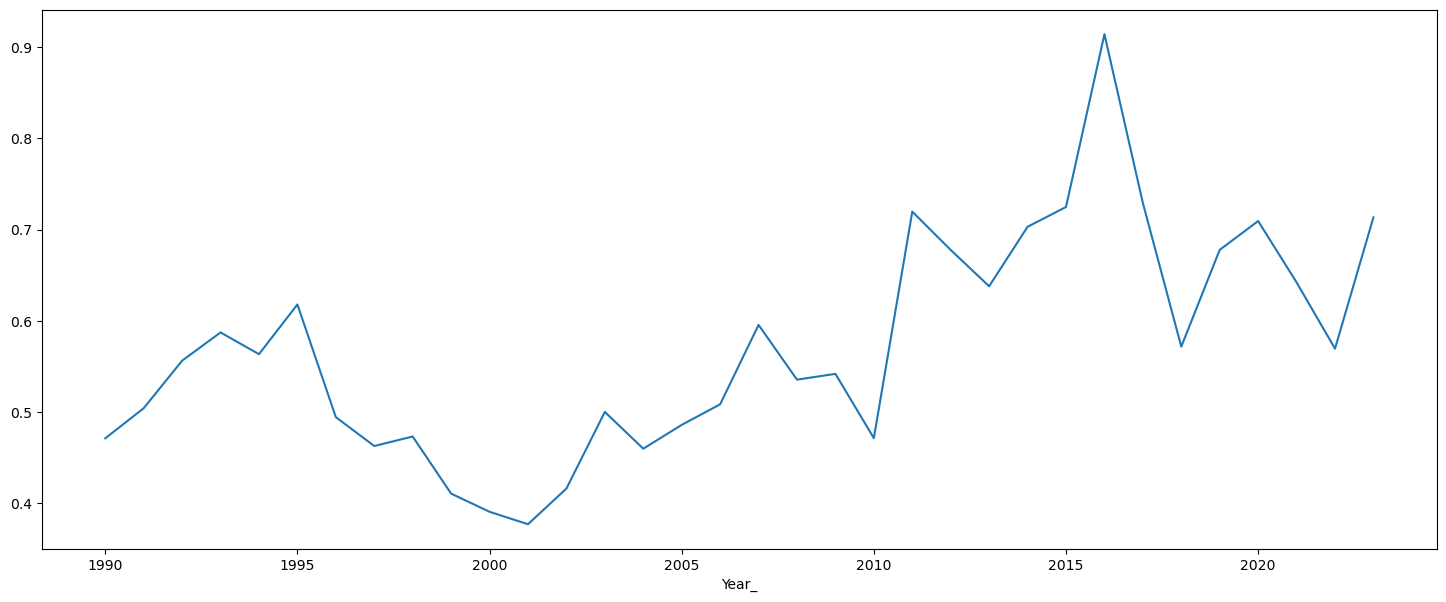

In [58]:
Yearly_Polarization.plot(figsize=(18,7))

Results were surprising to me. There are years such that "polarization" is below 0.4 and there are years that it is more than 0.9. I find it to be a remarkable difference. 

From 1990 to 1995 we see a clear increase in polarization, nearing 0.65 in 1995. Then it starts to decrease steadily, till 2001. Around 2001 we see it's lowest value. It starts to go up once again from 2001 to 2007.  It comes down to below 0.5 in the upcoming years and in 2013 it starts it largest increase. Peaking to more than 0.9 in 2016. After that it had a fast paced drop to below 0.6 and it continued its fluctiation at a small rate till 2023.

I don't have much domain knowledge about this topic and I was really hesitant to comment about the reasons behind this plot.
One thing which came to my mind is the election. Spesifically "The presidental election". It is known by many that both sides of US(Democrats and Republicants) ramp up their tone before the elections. There are many debates on many different topics. 

The last election was in 2020. Well, there seems to be a spike. The previous one was in 2016. Again, there is a large increase leading up to that date. 2012 as well. I can't prove that this is the reason behind, but it might explain a bit of the plot.

## Q3



### Finding the Number of Times Voted for each Legislator, Yearly

This is quite similar to the dataset I prepared in the first question. There, I calculated how many times they voted and didn't vote. I will call it here.

In [59]:
Voted_count_info[["Year","#text","Voted"]]

,Year,#text,Voted
0,1990,Ackerman,471
1,1990,Akaka,90
2,1990,Alexander,435
3,1990,Anderson,507
4,1990,Andrews (TX),505
...,...,...,...
14963,2023,Wilson (SC),665
14964,2023,Wittman,662
14965,2023,Womack,670
14966,2023,Yakym,670


It might be important to note that I didn't take quorums into account while I was preparing this frame. I believe it makes more sense since they are not like regular votes.

### Voting Along the Party Lines or not 

For this, I will be using a dataframe which I created earlier.Namely, "frame_without_quorums". 

In [60]:
frame_without_quorums

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name,Not Voted,Voted
430,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN,0,1
431,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN,0,1
432,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN,0,1
433,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN,0,1
434,Yea,1990,2,YEA-AND-NAY,Passed,On Approving the Journal,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311347,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC),0,1
8311348,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman,0,1
8311349,No,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,AR,legislator,Womack,W000809,Womack,Womack,0,1
8311350,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym,0,1


I will use this table but I need to do some filtering first. I will only be taking the ones which voted into consideration. My "voted" column will help me with that filtering. Apart from that I need to be taking Yea and Nay values only, just like the previous task, I will change all the no's to Nay's and "aye" to "yea". Last thing I will perform is to omit independent ones. They don't have a party, therefore there is no way that they can break their party line. 

In [61]:
Voting_Along=frame_without_quorums[["Year","RollNumber","@party","#text","vote"]][frame_without_quorums["Voted"]==1].copy()

In [62]:
Voting_Along

,Year,RollNumber,@party,#text,vote
430,1990,2,D,Ackerman,Yea
431,1990,2,D,Akaka,Yea
432,1990,2,D,Alexander,Yea
433,1990,2,D,Anderson,Yea
434,1990,2,D,Andrews (TX),Yea
...,...,...,...,...,...
8311347,2023,675,R,Wilson (SC),Aye
8311348,2023,675,R,Wittman,Aye
8311349,2023,675,R,Womack,No
8311350,2023,675,R,Yakym,Aye


In [63]:
Voting_Along["vote"]=Voting_Along["vote"].apply(lambda x: "Yea" if x == "Aye" else ("Nay" if x == "No" else x))

In [64]:
Voting_Along=Voting_Along.query("vote=='Yea' or vote=='Nay'")

In [65]:
Voting_Along["vote"].unique()

array(['Yea', 'Nay'], dtype=object)

Now as the last operation, I will omit the indepent legislatives.

In [66]:
Voting_Along=Voting_Along[Voting_Along["@party"]!="I"]

In [67]:
Voting_Along["@party"].unique()

array(['D', 'R'], dtype=object)

In [68]:
Voting_Along

,Year,RollNumber,@party,#text,vote
430,1990,2,D,Ackerman,Yea
431,1990,2,D,Akaka,Yea
432,1990,2,D,Alexander,Yea
433,1990,2,D,Anderson,Yea
434,1990,2,D,Andrews (TX),Yea
...,...,...,...,...,...
8311347,2023,675,R,Wilson (SC),Yea
8311348,2023,675,R,Wittman,Yea
8311349,2023,675,R,Womack,Nay
8311350,2023,675,R,Yakym,Yea


Now I have the table I want. But in order to see if they vote according to their party, I need to merge this dataframe with another one. I have already created a frame which I can easily use for this one as well.
The dataframe I am talking about is the "pivoted_df" frame which I created for the polarization task. There, I did a pivot to see what the distribution was for each role. I can do some operations on that table to find out the voting intention of each parties.

In [69]:
Majority_vote_by_party=pivoted_df.copy()
Majority_vote_by_party

,Year_,RollNumber_,D_Nay,D_Yea,R_Nay,R_Yea,Polarization
0,1990,2,2.0,234.0,87.0,78.0,0.600998
1,1990,3,244.0,0.0,32.0,137.0,0.845036
2,1990,4,0.0,245.0,25.0,145.0,0.301205
3,1990,5,6.0,226.0,94.0,75.0,0.596010
4,1990,6,0.0,248.0,166.0,6.0,0.971429
...,...,...,...,...,...,...,...
18976,2023,671,209.0,0.0,59.0,157.0,0.722353
18977,2023,672,207.0,0.0,63.0,155.0,0.703529
18978,2023,673,209.0,0.0,15.0,204.0,0.929907
18979,2023,674,207.0,0.0,4.0,216.0,0.981265


I will add two new columns to this table. One will be indicating the majority vote of democrats and the other will indicate the republicants.

In [70]:
Majority_vote_by_party["D_majority"] = Majority_vote_by_party.apply(lambda x: "Nay" if x["D_Nay"] >= x["D_Yea"] else "Yea", axis=1)
Majority_vote_by_party["R_majority"] = Majority_vote_by_party.apply(lambda x: "Nay" if x["R_Nay"] >= x["R_Yea"] else "Yea", axis=1)
Majority_vote_by_party

,Year_,RollNumber_,D_Nay,D_Yea,R_Nay,R_Yea,Polarization,D_majority,R_majority
0,1990,2,2.0,234.0,87.0,78.0,0.600998,Yea,Nay
1,1990,3,244.0,0.0,32.0,137.0,0.845036,Nay,Yea
2,1990,4,0.0,245.0,25.0,145.0,0.301205,Yea,Yea
3,1990,5,6.0,226.0,94.0,75.0,0.596010,Yea,Nay
4,1990,6,0.0,248.0,166.0,6.0,0.971429,Yea,Nay
...,...,...,...,...,...,...,...,...,...
18976,2023,671,209.0,0.0,59.0,157.0,0.722353,Nay,Yea
18977,2023,672,207.0,0.0,63.0,155.0,0.703529,Nay,Yea
18978,2023,673,209.0,0.0,15.0,204.0,0.929907,Nay,Yea
18979,2023,674,207.0,0.0,4.0,216.0,0.981265,Nay,Yea


My frame is almost ready. Before I do my merge, I want to drop some columns which I don't think I will be needing.

In [71]:
Majority_vote_by_party.drop(["D_Nay","D_Yea","R_Nay","R_Yea","Polarization"],axis=1,inplace=True)
Majority_vote_by_party

,Year_,RollNumber_,D_majority,R_majority
0,1990,2,Yea,Nay
1,1990,3,Nay,Yea
2,1990,4,Yea,Yea
3,1990,5,Yea,Nay
4,1990,6,Yea,Nay
...,...,...,...,...
18976,2023,671,Nay,Yea
18977,2023,672,Nay,Yea
18978,2023,673,Nay,Yea
18979,2023,674,Nay,Yea


Now, I will perform my merge. I want to join tables by two columns: the year and the roll call. 

In [72]:
Merged_Df = pd.merge(Voting_Along, Majority_vote_by_party, left_on=['Year', 'RollNumber'], right_on=['Year_', 'RollNumber_'], how='inner')

In [73]:
Merged_Df.drop(["Year_","RollNumber_"],axis=1,inplace=True)

In [74]:
Merged_Df

,Year,RollNumber,@party,#text,vote,D_majority,R_majority
0,1990,2,D,Ackerman,Yea,Yea,Nay
1,1990,2,D,Akaka,Yea,Yea,Nay
2,1990,2,D,Alexander,Yea,Yea,Nay
3,1990,2,D,Anderson,Yea,Yea,Nay
4,1990,2,D,Andrews (TX),Yea,Yea,Nay
...,...,...,...,...,...,...,...
7861409,2023,675,R,Wilson (SC),Yea,Nay,Yea
7861410,2023,675,R,Wittman,Yea,Nay,Yea
7861411,2023,675,R,Womack,Nay,Nay,Yea
7861412,2023,675,R,Yakym,Yea,Nay,Yea


I will create a new column which basically states that they voted against their own party.

In [75]:
Merged_Df["Voted_Against"] = Merged_Df.apply(lambda x: 1 if ((x["@party"] == "D" and x["vote"] != x["D_majority"]) or (x["@party"] == "R" and x["vote"] != x["R_majority"])) else 0, axis=1)


In [76]:
Merged_Df

,Year,RollNumber,@party,#text,vote,D_majority,R_majority,Voted_Against
0,1990,2,D,Ackerman,Yea,Yea,Nay,0
1,1990,2,D,Akaka,Yea,Yea,Nay,0
2,1990,2,D,Alexander,Yea,Yea,Nay,0
3,1990,2,D,Anderson,Yea,Yea,Nay,0
4,1990,2,D,Andrews (TX),Yea,Yea,Nay,0
...,...,...,...,...,...,...,...,...
7861409,2023,675,R,Wilson (SC),Yea,Nay,Yea,0
7861410,2023,675,R,Wittman,Yea,Nay,Yea,0
7861411,2023,675,R,Womack,Nay,Nay,Yea,1
7861412,2023,675,R,Yakym,Yea,Nay,Yea,0


I am also adding the "Voted Along" column

In [77]:
Merged_Df["Voted_Along"]=Merged_Df["Voted_Against"].apply(lambda x: 0 if x==1 else 1)

In [78]:
Merged_Df

,Year,RollNumber,@party,#text,vote,D_majority,R_majority,Voted_Against,Voted_Along
0,1990,2,D,Ackerman,Yea,Yea,Nay,0,1
1,1990,2,D,Akaka,Yea,Yea,Nay,0,1
2,1990,2,D,Alexander,Yea,Yea,Nay,0,1
3,1990,2,D,Anderson,Yea,Yea,Nay,0,1
4,1990,2,D,Andrews (TX),Yea,Yea,Nay,0,1
...,...,...,...,...,...,...,...,...,...
7861409,2023,675,R,Wilson (SC),Yea,Nay,Yea,0,1
7861410,2023,675,R,Wittman,Yea,Nay,Yea,0,1
7861411,2023,675,R,Womack,Nay,Nay,Yea,1,0
7861412,2023,675,R,Yakym,Yea,Nay,Yea,0,1


In [79]:
Yearly_Along_Against=Merged_Df[["Year","@party","#text","Voted_Against","Voted_Along"]].groupby(["Year","#text"]).agg({"@party":"first","Voted_Against":"sum","Voted_Along":"sum"}).reset_index()

In [80]:
Yearly_Along_Against

,Year,#text,@party,Voted_Against,Voted_Along
0,1990,Ackerman,D,25,446
1,1990,Akaka,D,3,87
2,1990,Alexander,D,50,385
3,1990,Anderson,D,40,467
4,1990,Andrews (TX),D,63,442
...,...,...,...,...,...
14931,2023,Wilson (SC),R,47,599
14932,2023,Wittman,R,32,611
14933,2023,Womack,R,109,542
14934,2023,Yakym,R,27,624


### Finding Legislatives Who Never Broke the Party Line

Since I will be doing it for both parties, I will define a simple function.

In [81]:
def find_never_broked(dff,D_or_R):

    print(dff[dff["@party"]==D_or_R][dff["Voted_Against"]==0])

First I wanted to see all the ones which never voted against their party line. 

#### Democrats

In [82]:
find_never_broked(Yearly_Along_Against,"D")

       Year        #text @party  Voted_Against  Voted_Along
842    1991        Udall      D              0            3
1420   1993         Espy      D              0            4
1610   1993      Panetta      D              0            4
1875   1994        Foley      D              0           28
3058   1996        Wyden      D              0            6
...     ...          ...    ...            ...          ...
14396  2022    Ryan (NY)      D              0          129
14397  2022    Ryan (OH)      D              0          127
14398  2022       Sablan      D              0           14
14400  2022  San Nicolas      D              0           12
14403  2022      Scanlon      D              0          543

[224 rows x 5 columns]


C:\Users\erent\AppData\Local\Temp\ipykernel_12732\3427578125.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dff[dff["@party"]==D_or_R][dff["Voted_Against"]==0])


#### Republicants

In [83]:
find_never_broked(Yearly_Along_Against,"R")

       Year             #text @party  Voted_Against  Voted_Along
2345   1995          Gingrich      R              0           57
3197   1997          Fossella      R              0           64
3650   1998          Gingrich      R              0           73
4176   1999        Livingston      R              0           18
4900   2001  Davis, Thomas M.      R              0           11
...     ...               ...    ...            ...          ...
12384  2018              Dent      R              0          175
12973  2019            Marino      R              0           23
13480  2020         Radewagen      R              0            2
13657  2021             Carey      R              0           89
14040  2021            Wright      R              0           14

[229 rows x 5 columns]


C:\Users\erent\AppData\Local\Temp\ipykernel_12732\3427578125.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dff[dff["@party"]==D_or_R][dff["Voted_Against"]==0])


### Counting Them

To fulfill the task requirement, I also counted them. Yearly, for both parties.

In [84]:
def find_never_broked_count(dff,D_or_R):

    print(dff[dff["@party"]==D_or_R][dff["Voted_Against"]==0][["Year","#text"]].groupby("Year").count())

#### Democrats

In [85]:
find_never_broked_count(Yearly_Along_Against,"D")

      #text
Year       
1991      1
1993      2
1994      1
1996      1
1997      1
1998      3
1999      1
2006      1
2008      1
2009      2
2010      2
2011      1
2012      1
2015      2
2016    172
2017      1
2018      3
2019      1
2020     15
2021      3
2022      9


C:\Users\erent\AppData\Local\Temp\ipykernel_12732\104157322.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dff[dff["@party"]==D_or_R][dff["Voted_Against"]==0][["Year","#text"]].groupby("Year").count())


#### Republicants

In [86]:
find_never_broked_count(Yearly_Along_Against,"R")

      #text
Year       
1995      1
1997      1
1998      1
1999      1
2001      4
2002      1
2003      1
2005      2
2006      1
2007      3
2008      1
2010      1
2011      2
2012      1
2013      2
2016    195
2017      5
2018      2
2019      1
2020      1
2021      2


C:\Users\erent\AppData\Local\Temp\ipykernel_12732\104157322.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dff[dff["@party"]==D_or_R][dff["Voted_Against"]==0][["Year","#text"]].groupby("Year").count())


2016 stands there as having the highest counts for both parties. It is interesting to see.

#### Finding the 5 Legislatives Who Voted Against the Most, Yearly

I already have a dataframe showing the voted_against counts. 

In [87]:
Yearly_Along_Against

,Year,#text,@party,Voted_Against,Voted_Along
0,1990,Ackerman,D,25,446
1,1990,Akaka,D,3,87
2,1990,Alexander,D,50,385
3,1990,Anderson,D,40,467
4,1990,Andrews (TX),D,63,442
...,...,...,...,...,...
14931,2023,Wilson (SC),R,47,599
14932,2023,Wittman,R,32,611
14933,2023,Womack,R,109,542
14934,2023,Yakym,R,27,624


I got some help to only get the top 5 values when grouping yearly.I t can be found [here.](https://chat.openai.com/share/61c8b3f0-b43e-435e-9c2e-6bcb309b43d7)


In [88]:
Top5_Voted_Against = Yearly_Along_Against.sort_values(by='Voted_Against', ascending=False)\
    .groupby('Year')[["Year", "#text", "@party", "Voted_Against"]]\
    .head(5).sort_values(by="Year").reset_index(drop=True)

In [89]:
pd.set_option('display.max_rows', None)


In [90]:
Top5_Voted_Against

,Year,#text,@party,Voted_Against
0,1990,Conte,R,203
1,1990,Morella,R,187
2,1990,Gilman,R,180
3,1990,Horton,R,180
4,1990,Green,R,178
5,1991,Horton,R,152
6,1991,Taylor (MS),D,141
7,1991,Gilman,R,154
8,1991,Green,R,179
9,1991,Morella,R,151


In [91]:
pd.reset_option('display.max_rows')

## Q4



### Turning it into a Classification Task

Before I start, I want to check my dataframe columns. There are two columns describing what is happening for that spesific role.The first one is "The Question ".

In [92]:
local_df["The Question"].unique()

array(['Call of the House', 'On Approving the Journal',
       'REFER BILL AND VETO JOINTLY TO FOREIGN AFFAIRS AND JUD.',
       'ON PRESIDENTIAL VETO', 'On Agreeing to the Resolution',
       'On Motion to Suspend the Rules and Pass',
       'SUSPEND THE RULES AND AGREE', 'ON AGREEING TO THE AMENDMENTS',
       'On Motion to Recommit with Instructions', 'On Passage',
       'ON AGREEING TO THE RESOLUTION', 'MOTION TO INSTRUCT CONFEREES',
       'SUSPEND RULES AND AGREE TO CONFERENCE REPORT',
       'On Agreeing to the Amendment',
       'On Ordering the Previous Question',
       'ON MOTION TO REFER TO THE JUDICIARY COMMITTEE',
       'COMMIT WITH INSTRUCTIONS', 'ON AGREEING TO THE AMENDMENT',
       'SUSPEND THE RULES AND AGREE TO SENATE AMENDMENT',
       'ON MOTION TO PROCEED IN ORDER',
       'On Agreeing to the Conference Report',
       'SUSPEND RULES AND PASSAS AMENDED',
       'RECEDE FROM DISAGREEMENT TO S ADT.#12',
       'RECEDE FROM DISAGREEMENT TO S. ADT. #22',
       'RE

I don't think there are statements which can be of my use here. They are too general. Let's take one example : "On approving the Journal". Without knowing the context, I find it to be useless to fit this text to any machine learning model. It doesn't satisy any needs of a classification task which I will try to be doing.

In [93]:
local_df["Description"].unique()


array([nan,
       'WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS FACILITATION ACT',
       'CHINESE ADJUSTMENT OF STATUS FACILITATION ACT', ...,
       'Providing for consideration of the bill (H.R. 5894) making appropriations for the Departments of Labor, Health and Human Services, and Education, and related agencies for the fiscal year ending September 30, 2024, and for other purposes',
       'Further Continuing Appropriations and Other Extensions Act, 2024',
       'Providing for consideration of the bill (H.R. 5893) Commerce, Justice, Science, and Related Agencies Appropriations Act, 2024 and providing for consideration of the bill (H.R. 5961) No Funds for Iranian Terrorism Act'],
      dtype=object)

Description column gives more valuable information for sure. It clearly mentions the underlying topic of the call. I belive this is what I need to use. 

But it also has a downside. There are many null values in that column. I need to delete them and move on with the remaining data. Since I don't want to include "quorums" for obvious reasons.I will use the dataset I created before : "frame without quorums"

In [94]:
local_df

,vote,Year,RollNumber,Type,Vote Result,The Question,Description,@party,@state,@role,#text,@name-id,@sort-field,@unaccented-name
0,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,NY,legislator,Ackerman,NaN,NaN,NaN
1,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,HI,legislator,Akaka,NaN,NaN,NaN
2,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,AR,legislator,Alexander,NaN,NaN,NaN
3,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,CA,legislator,Anderson,NaN,NaN,NaN
4,Present,1990,1,QUORUM,Passed,Call of the House,NaN,D,TX,legislator,Andrews (TX),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311347,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,SC,legislator,Wilson (SC),W000795,Wilson (SC),Wilson (SC)
8311348,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,VA,legislator,Wittman,W000804,Wittman,Wittman
8311349,No,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,AR,legislator,Womack,W000809,Womack,Womack
8311350,Aye,2023,675,RECORDED VOTE,Failed,On Agreeing to the Amendment,NaN,R,IN,legislator,Yakym,Y000067,Yakym,Yakym


I will be using the frame which doesn't include quorums for this task. I will only get the features I need.

In [95]:
Classification1=frame_without_quorums[["Year","RollNumber","Description","#text"]].copy()
Classification1.dropna(inplace=True)
Classification1

,Year,RollNumber,Description,#text
861,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Ackerman
862,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Akaka
863,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Alexander
864,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Anderson
865,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Andrews (TX)
...,...,...,...,...
8304762,2023,660,Providing for consideration of the bill (H.R. ...,Wilson (SC)
8304763,2023,660,Providing for consideration of the bill (H.R. ...,Wittman
8304764,2023,660,Providing for consideration of the bill (H.R. ...,Womack
8304765,2023,660,Providing for consideration of the bill (H.R. ...,Yakym


As I am preparing my data to be trained, I also need to bring my target,my labels, for this task. I have already created a majority preference by each party table (Merged_Df) and I believe they are the best candidates for being a label to this task.  

I will be merging them by Year and Roll Column. The reason I am doing this merge before grouping by each roll call is the fact that I will need to see regislator name for the other classification task. 

In [96]:
To_merge=Merged_Df[["Year","RollNumber","D_majority","R_majority"]]

In [97]:
Majority_vote_by_party

,Year_,RollNumber_,D_majority,R_majority
0,1990,2,Yea,Nay
1,1990,3,Nay,Yea
2,1990,4,Yea,Yea
3,1990,5,Yea,Nay
4,1990,6,Yea,Nay
...,...,...,...,...
18976,2023,671,Nay,Yea
18977,2023,672,Nay,Yea
18978,2023,673,Nay,Yea
18979,2023,674,Nay,Yea


In [98]:
Merged_Classification=pd.merge(Classification1,Majority_vote_by_party, left_on=['Year', 'RollNumber'],right_on=["Year_","RollNumber_"],how="inner")
Merged_Classification.drop(["Year_","RollNumber_"],axis=1,inplace=True)

In [99]:
Merged_Classification

,Year,RollNumber,Description,#text,D_majority,R_majority
0,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Ackerman,Nay,Yea
1,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Akaka,Nay,Yea
2,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Alexander,Nay,Yea
3,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Anderson,Nay,Yea
4,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Andrews (TX),Nay,Yea
...,...,...,...,...,...,...
5040931,2023,660,Providing for consideration of the bill (H.R. ...,Wilson (SC),Nay,Yea
5040932,2023,660,Providing for consideration of the bill (H.R. ...,Wittman,Nay,Yea
5040933,2023,660,Providing for consideration of the bill (H.R. ...,Womack,Nay,Yea
5040934,2023,660,Providing for consideration of the bill (H.R. ...,Yakym,Nay,Yea


Since I want to turn it into a classification task, I need to define what my classes are. I can't just turn the "D_majority" and "R_majority" to binary values depending on "Nay" and "Yea" because there are also some which are both "Yea" for democrats and "Yea" for republicants (Also, both Nay and Nay exist). Main idea behind what I am doing is the find exact differences between how these two groups vote in spesific topics. So I decided continueing with deleting the rows where democrats and republicants have the same tendency.

For that I will create a new column indicating whether the votes majorities are the same. Then I will drop the ones like that easily.

In [100]:
Merged_Classification["same"]=Merged_Classification.apply(lambda x : 1 if x["D_majority"]==x["R_majority"] else 0,axis=1)

In [101]:
Merged_Classification=Merged_Classification[Merged_Classification["same"]==0]


In [102]:
Merged_Classification

,Year,RollNumber,Description,#text,D_majority,R_majority,same
0,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Ackerman,Nay,Yea,0
1,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Akaka,Nay,Yea,0
2,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Alexander,Nay,Yea,0
3,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Anderson,Nay,Yea,0
4,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Andrews (TX),Nay,Yea,0
...,...,...,...,...,...,...,...
5040931,2023,660,Providing for consideration of the bill (H.R. ...,Wilson (SC),Nay,Yea,0
5040932,2023,660,Providing for consideration of the bill (H.R. ...,Wittman,Nay,Yea,0
5040933,2023,660,Providing for consideration of the bill (H.R. ...,Womack,Nay,Yea,0
5040934,2023,660,Providing for consideration of the bill (H.R. ...,Yakym,Nay,Yea,0


Now I will define two classes based on the value of D_majority. If the D_majority = Yea , I will accept it as 1. Otherwise I will accept it as 2.

In [103]:
Merged_Classification["label"]=Merged_Classification["D_majority"].apply(lambda x: 1 if x=="Yea" else 2)


C:\Users\erent\AppData\Local\Temp\ipykernel_12732\2836235240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Merged_Classification["label"]=Merged_Classification["D_majority"].apply(lambda x: 1 if x=="Yea" else 2)


In [104]:
Merged_Classification

,Year,RollNumber,Description,#text,D_majority,R_majority,same,label
0,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Ackerman,Nay,Yea,0,2
1,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Akaka,Nay,Yea,0,2
2,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Alexander,Nay,Yea,0,2
3,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Anderson,Nay,Yea,0,2
4,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,Andrews (TX),Nay,Yea,0,2
...,...,...,...,...,...,...,...,...
5040931,2023,660,Providing for consideration of the bill (H.R. ...,Wilson (SC),Nay,Yea,0,2
5040932,2023,660,Providing for consideration of the bill (H.R. ...,Wittman,Nay,Yea,0,2
5040933,2023,660,Providing for consideration of the bill (H.R. ...,Womack,Nay,Yea,0,2
5040934,2023,660,Providing for consideration of the bill (H.R. ...,Yakym,Nay,Yea,0,2


Grouping my frame by each roll call.

In [105]:
Merged_Classification_Grouped_by_roll=Merged_Classification[["Year","RollNumber","Description","label"]].groupby(["Year","RollNumber"]).agg({"Description":"first","label":"first"}).reset_index()

In [106]:
Merged_Classification_Grouped_by_roll

,Year,RollNumber,Description,label
0,1990,3,WITH INSTRUCTIONS CHINESE ADJUSTMENT OF STATUS...,2
1,1990,6,"PROVIDING FOR THE CONSIDERATION OF H.R. 2190, ...",1
2,1990,10,NATIONAL VOTER REGISTRATION ACT OF 1989,2
3,1990,11,NATIONAL VOTER REGISTRATION ACT OF 1989,1
4,1990,22,ESTABLISH COMMISSION TO INVESTIGATE EASTERN AI...,1
...,...,...,...,...
6081,2023,645,"Impeaching Alejandro Nicholas Mayorkas, Secret...",1
6082,2023,646,Providing for consideration of the bill (H.R. ...,2
6083,2023,647,Providing for consideration of the bill (H.R. ...,2
6084,2023,659,Providing for consideration of the bill (H.R. ...,2


Now I need to prepare my texts to be clear enough to be used in training. I wanted to use a similar code we used in our [Lecture9](https://github.com/kaygun/2023-Fall-381E/blob/main/lectures/lecture-09.ipynb). I will use regular expressions to get rid of all non-word characters and downcase letters. I will put all the texts and my labels to lists.

In [107]:

descriptions = []
labels = []

for index, row in Merged_Classification_Grouped_by_roll.iterrows():
    description = re.sub(r'[^\w\s]+', '', row['Description'].lower())
    descriptions.append(description)
    labels.append(row['label'])

I should check the length of my lists. Since I need to have the respected label for each sentence, lengths should be equal. 

In [108]:
len(descriptions) == len(labels)

True

I am going to be using the simplest vectorizer. It basically works by checking how common the words are. Also important to mention that I will be removing all the stopwords here.

In [109]:
vectorizer = CountVectorizer(stop_words=list(stopwords.words('english')))
X = vectorizer.fit_transform(descriptions)

I will split my set and go on with training. I wanted to choose logistic regression, since it is a classification method which I know to be working nice and fast. I wanted to use "liblinear" as my solver because I read that it works well with high dimensional models, just like mine.

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X,labels, test_size=0.2)
model = LR(max_iter=2500, solver='liblinear').fit(X_train,y_train)
y_predict = model.predict(X_test)

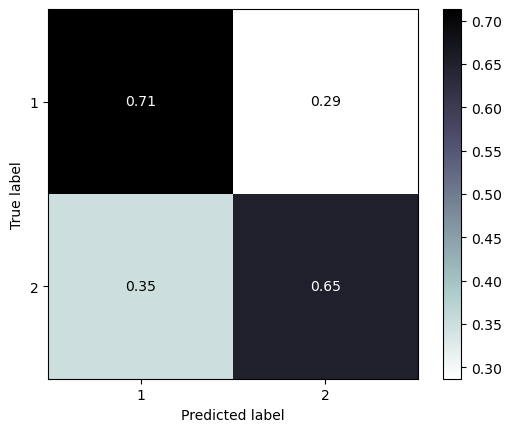

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, normalize='true', cmap='bone_r')

As I have also learned during the lecture, this number just gives an idea for one fitting. It is not possible to statistically back it with only 1 training. However, altough I acknowledge this fact, I still wanted to put this in order to show more about my model.

I want to check my classes to see the order.

In [149]:
classes = model.classes_
print(f"Class Labels: {classes}")

Class Labels: [1 2]


This model will also help me calculating the probabilities of a word of belonging to a class. 

### Finding the Important Words for Both Parties 

I used the predict_proba function to do this. I also got some help from an LLM. It can be found [here](https://chat.openai.com/share/1bb384be-b187-4699-adff-ef2163ac4106)

In [156]:
predicted_probabilities = model.predict_proba(X)
feature_names = vectorizer.get_feature_names_out()


probabilities_class_0 = predicted_probabilities[:, 0]


probabilities_class_1 = predicted_probabilities[:, 1]


texts_and_probabilities = list(zip(feature_names, probabilities_class_1, probabilities_class_0))


sorted_texts = sorted(texts_and_probabilities, key=lambda x: x[1], reverse=True)


for text, prob_class_1, prob_class_0 in sorted_texts:
    print(f"Text: {text}\nProbability (Pro Republicant): {prob_class_1}\nProbability (Pro Democrat): {prob_class_0}\n")

Text: taking
Probability (Pro Republicant): 0.999879083591064
Probability (Pro Democrat): 0.00012091640893596711

Text: tallahassee
Probability (Pro Republicant): 0.999879083591064
Probability (Pro Democrat): 0.00012091640893596711

Text: clark
Probability (Pro Republicant): 0.9965085717795429
Probability (Pro Democrat): 0.0034914282204571156

Text: class
Probability (Pro Republicant): 0.9965085717795429
Probability (Pro Democrat): 0.0034914282204571156

Text: clear
Probability (Pro Republicant): 0.9952786066529727
Probability (Pro Democrat): 0.0047213933470272584

Text: trustees
Probability (Pro Republicant): 0.9951155478209422
Probability (Pro Democrat): 0.004884452179057752

Text: truth
Probability (Pro Republicant): 0.9951155478209422
Probability (Pro Democrat): 0.004884452179057752

Text: conveyed
Probability (Pro Republicant): 0.9918371805795914
Probability (Pro Democrat): 0.00816281942040864

Text: convicted
Probability (Pro Republicant): 0.9918371805795914
Probability (Pro Demo

On top, it shows the most pro republicant words and it shows the most pro democrat ones at the bottom. 

#### Other things I tried

At this very question, I initially had different approaches. I will briefly explain them here in my last part since I want to be as informative as I can about my process.

Firstly, I tried to use a technique we saw in the class (gensim keyword extraction). Mentioned lecture can be seen [here](https://github.com/kaygun/2023-Fall-381E/blob/main/lectures/lecture-08.ipynb) 


Well, unfortunatly "from gensim.summarization import keywords" did not work for me. I had the library downloaded, did some research, even went on to downgrade the library, it still didn't work. I wanted to search for other methods.

I found other libraries to do this, thanks to this [article](https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c). I went on using the "Rake-nltk" library.


rake_nltk_var = Rake()  
rake_nltk_var.extract_keywords_from_text(full_text)

Well, unfortunatly the results were not good at all. I think most of the descriptions are quite similar and that makes it harder to extract keywords depending on the parties.  



